# Results Aggregation

In [30]:
import os
import json
import pandas as pd
import math
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Collect Experiment Results
model_ls = ['gpt-3.5-turbo', 'gpt-4-turbo', 'mistral-7bf', 'llama2-13bf', 'llama3-8bf', 'qwen2.5-7bf', 'qwen2.5-14bf']
model_map = {
    'gpt-4-turbo':'GPT-4',
    'gpt-3.5-turbo': 'GPT-3.5',
    'llama3-8bf': 'Llama3-Chat 8B',
    'qwen2.5-7bf': 'Qwen2.5-Instruct 7B',
    'qwen2.5-14bf': 'Qwen2.5-Instruct 14B',
    'mistral-7bf': 'Mistral-Instruct 7B',
    'llama2-13bf': 'Llama2-Chat 13B', 
    't5-3b': 'T5-3B',
    't5': 'T5-large (AdamW)',
    't5-large': 'T5-large' # Same hyperparameter setting as T5-3b, use Adafactor
}
scheme_map = {
    'w_def': 'w_def',
    'wo_def': 'w/o_def',
    'w_def_qf': 'w_def',
    'wo_def_qf': 'w/o_def',
    'w_def_cf': 'w_def',
    'wo_def_cf': 'w/o_def',
    'w_logic_def': 'w_logic_def',
    'v1_wo_def': 'warm-up_w/o_def',
    'v12_wo_def': 'analysis_w/o_def',
    'v13_wo_def': 'v13_w/o_def',
    'v14_wo_def': 'entail_w/o_def',
    'v2_gen_def': 'generate_def',
    'v2_gen_def_qf': 'generate_def',
    'v3_cot_wo_def': 'CoT_w/o_def',
    'v3_cot_wo_def_ff': "CoT_w/o_def",
    'v3_cot_w_def': "CoT_w_def",
    # Deprecated
    'w_ls_def': 'w_ls_def',
    'v11_wo_def': 'v11_wo_def',
    'v21_gen_def': 'v21_gen_def',
    'v4_wo_def' : "v4_wo_def",
    'v5_wo_def' : "v5_wo_def",
    'v6_wo_def' : "v6_wo_def",
}
dataset_ls = ['argotario', 'logic', 'elecdebate', 'propaganda', 'mafalda', 'reddit', 'covid']


def aggregate_results(root, output_root):
    os.makedirs(output_root, exist_ok=True)
    output_dir = os.path.join(output_root, 'raw')
    os.makedirs(output_dir, exist_ok=True)

    col_names = ['Task', 'Fine-tuning', 'Shot', 'setting', 'Context Window', 'Model', 'model_cfig', 'Scheme', 'pre-scheme', 'Acc.', 'Macro-F1', '%Failed','recall', 'precision', 'balanced_acc']
    def get_model_config(model_name, fld_name):
        datetime_str = fld_name.split("_")[-1]
        # Convert the strings to datetime objects
        run_datetime = datetime.strptime(datetime_str, '%Y%m%d%H%M%S')
        bound_datetime1 = datetime.strptime('20240601180000', '%Y%m%d%H%M%S')
        bound_datetime2 = datetime.strptime('20240501000000', '%Y%m%d%H%M%S')
        if model_name.startswith('llama'):
            if run_datetime < bound_datetime2:
                return "float16 8bit_q"
            else:
                if model_name.startswith('llama2'):
                    if run_datetime < bound_datetime1:
                        return "bfloat16 8bit_q"
                    else:
                        return "bfloat16"
                else:
                    if run_datetime < bound_datetime1:
                        return "bfloat16 bnb_q"
                    else:
                        return "bfloat16"   
        elif model_name.startswith("t5"):
            return fld_name.split("_")[-2]
        else:
            return ""
    ############# Convert #Failed to percentage
    def convert_n_failed(res_dict):
        test_size = {'argotario':312, 'logic':300, 'elecdebate':154, 'propaganda':265, 'mafalda':200, 'reddit':513, 'covid':154}
        return round(res_dict['n_failed'] * 100 / test_size[res_dict['task']], 2)

    all_res = []
    # ---------------------------- Collect for LLM zero-/few-shot inference results ----------------------------#
    for folder in os.listdir(root):
        mf = os.path.join(root, folder)
        if os.path.isdir(mf) and folder in model_ls:
            for fd in os.listdir(mf):
                df = os.path.join(mf, fd)
                if os.path.isdir(df) and (fd in dataset_ls):
                    for fld in os.listdir(df):
                        ef = os.path.join(df, fld)
                        if os.path.isdir(ef):
                            try:
                                if os.path.exists(os.path.join(ef, 'result_updated.json')):
                                    file_name = 'result_updated.json'
                                else:
                                    file_name = 'result.json'
                                res_dict = json.load(open(os.path.join(ef, file_name)))
                                setting = fld.split("_")[0]
                                
                                if setting == 'fewshot':
                                    shot = 'Few-shot'
                                elif setting.split('-')[0] in ['1', '2']:
                                    shot = setting
                                else:
                                    shot = 'Zero-shot'
                                prompt_cwindow = ""
                                for i, po in enumerate(fld.split("_")):
                                    if po.startswith("GPU"):
                                        if fld.split("_")[i-1] in ['0','1','2']:
                                            if fd == 'propaganda':
                                                prompt_cwindow = int(fld.split("_")[i-1])
                                            break
                                m_cfig = get_model_config(res_dict['model'], fld)
                                all_res.append((res_dict['task'], "", shot, setting, prompt_cwindow, model_map[res_dict['model']], m_cfig, \
                                                scheme_map[res_dict['scheme']], res_dict['scheme'], \
                                                res_dict['acc'], res_dict['f1'], convert_n_failed(res_dict),\
                                                res_dict['recall'], res_dict['precision'], res_dict['balanced_acc']))
                            except:
                                print(f"Failed to collect results from {ef}.")
    
    # ---------------------------------------------- Collect T5 results ---------------------------------------------- #
    # Collect for t5 multi-task fine-tuning results
    for t5_m in ['t5-large', 't5-3b']:
        t5_res_pth = os.path.join(root, t5_m, 'multi-task')
        try:
            for fld in os.listdir(t5_res_pth):
                ef = os.path.join(t5_res_pth, fld)
                if os.path.isdir(ef):
                    for fd in os.listdir(ef):
                        if fd in dataset_ls:
                            tf = os.path.join(ef, fd, 'inference')
                            try:
                                res_dict = json.load(open(os.path.join(tf, 'result.json')))
                                finetune = "Multi-task"
                                prompt_cwindow = 0 if fd == 'propaganda' else ""
                                m_cfig = get_model_config(res_dict['model'], fld)
                                all_res.append((res_dict['task'], finetune, "Full-shot", "baseline", prompt_cwindow, model_map[res_dict['model']], m_cfig, \
                                                scheme_map['w_def'], 'w_def', \
                                                res_dict['acc'], res_dict['f1'], convert_n_failed(res_dict),\
                                                res_dict['recall'], res_dict['precision'], res_dict['balanced_acc']))
                            except:
                                print(f"Failed to collect results from {tf}.")
                        elif fd.startswith(t5_m): # OOD inference
                            datasets_train_on = "+".join([fn for fn in os.listdir(ef) if (fn in dataset_ls) and (os.path.isdir(os.path.join(ef, fn)))])
                            ood_folder = os.path.join(ef, fd)
                            for dataset_fd in os.listdir(ood_folder):
                                if dataset_fd in dataset_ls:
                                    ood_dataset_fd = os.path.join(ood_folder, dataset_fd)
                                    for run in os.listdir(ood_dataset_fd):
                                        try:
                                            res_dict = json.load(open(os.path.join(ood_dataset_fd, run, dataset_fd, 'inference', 'result.json')))
                                            finetune = "Multi-task"
                                            prompt_cwindow = 0 if dataset_fd == 'propaganda' else ""
                                            m_cfig = f'OOD|{datasets_train_on}'
                                            all_res.append((res_dict['task'], finetune, "Full-shot", "baseline", prompt_cwindow, model_map[res_dict['model']], m_cfig, \
                                                            scheme_map['w_def'], 'w_def', \
                                                            res_dict['acc'], res_dict['f1'], convert_n_failed(res_dict),\
                                                            res_dict['recall'], res_dict['precision'], res_dict['balanced_acc']))
                                        except:
                                            print(f"Failed to collect results from {os.path.join(ood_dataset_fd, run)}.")
        except:
            print(f"Experiments not run yet...")        
    
    # ---------------------------------------------- Collect for t5 single-task fine-tuning results  ---------------------------------------------- #
    for t5_m in ['t5-large', 't5-3b']:
        t5_res_pth = os.path.join(root, t5_m)
        for fld in os.listdir(t5_res_pth):
            dataset_fld = os.path.join(t5_res_pth, fld)
            if (fld in dataset_ls) and os.path.isdir(dataset_fld):
                for one_run in os.listdir(dataset_fld):
                    res_file = os.path.join(dataset_fld, one_run, fld, 'inference', 'result.json')
                    if os.path.exists(res_file):
                        # if fld == 'elecdebate' and t5_m == 't5-large':
                        #     print('here')
                        res_dict = json.load(open(res_file))
                        finetune = "Single-task"
                        prompt_cwindow = 0 if fld == 'propaganda' else ""
                        m_cfig = get_model_config(res_dict['model'], one_run)
                        all_res.append((res_dict['task'], finetune, "Full-shot", "baseline", prompt_cwindow, model_map[res_dict['model']], m_cfig, \
                                        scheme_map['w_def'], 'w_def', \
                                        res_dict['acc'], res_dict['f1'], convert_n_failed(res_dict),\
                                        res_dict['recall'], res_dict['precision'], res_dict['balanced_acc']))
                    else:
                        print(f"File not found {res_file}.")
    
    # -------------------------------------------- Save all results into a dataframe -------------------------------------------- #
    res_df = pd.DataFrame(all_res, columns=col_names).sort_values(by=['Task', 'Model', 'Scheme'],ignore_index=True, ascending=True)
    
    for col in ['Acc.', 'Macro-F1', 'recall', 'precision', 'balanced_acc']:
        res_df[col] = res_df[col] * 100.
    

    def format_mean_std(row):
        metrics = ['Acc.', 'Macro-F1', '%Failed', 'recall', 'precision', 'balanced_acc']
        groupby = ['Task', 'Fine-tuning', 'Shot', 'setting', 'Context Window', 'Model', 'model_cfig', 'Scheme']
        format_cols = {c: row[c] for c in groupby}
        for col in metrics:
            mean, std = round(row[col], 2), round(row[col+'_std'], 2) 
            if math.isnan(std):
                std = 0.
            val = str(mean) + " (±" +str(std) + ")"
            format_cols[col] = val
        return format_cols
    
    # --------------------------------------- 10.1 Camera-ready --------------------------------------- #
    metrics = ['Acc.', 'Macro-F1', '%Failed', 'recall', 'precision', 'balanced_acc']
    # T5
    groupby_t5 = ['Task', 'Fine-tuning', 'Shot', 'setting', 'Context Window', 'Model', 'model_cfig', 'Scheme']
    df_t5 = res_df[res_df['Model'].str.startswith('T5')].copy()
    df_t5_mean = df_t5.groupby(groupby_t5)[metrics].mean().reset_index()
    df_t5_std = df_t5.groupby(groupby_t5)[metrics].std().reset_index()
    df_avr_t5 = df_t5_mean.join(df_t5_std.set_index(groupby_t5), on=groupby_t5, rsuffix='_std').sort_values(by=['Task', 'setting', 'Macro-F1'], ignore_index=True, ascending=False)
    df_avr_t5.to_excel(os.path.join(output_dir, 't5.xlsx'), index=False)

    # GPT-4: Average over all runs under each Scheme, regardless of variant difference in each scheme
    groupby_gpt4 = ['Task', 'Fine-tuning', 'Shot', 'setting', 'Context Window', 'Model', 'model_cfig', 'Scheme']
    df_gpt4 = res_df[res_df['Model'] == 'GPT-4'].copy()
    df_gpt4_mean = df_gpt4.groupby(groupby_gpt4)[metrics].mean().reset_index()
    df_gpt4_std = df_gpt4.groupby(groupby_gpt4)[metrics].std().reset_index()
    df_avr_gpt4 = df_gpt4_mean.join(df_gpt4_std.set_index(groupby_gpt4), on=groupby_gpt4, rsuffix='_std').sort_values(by=['Task', 'setting', 'Macro-F1'], ignore_index=True, ascending=False)
    
    df_gpt4_mean.to_excel(os.path.join(output_dir, 'gpt4_mean.xlsx'), index=False)
    df_gpt4_std.to_excel(os.path.join(output_dir, 'gpt4_std.xlsx'), index=False)
    df_avr_gpt4.to_excel(os.path.join(output_dir, 'gpt4.xlsx'), index=False)

    # Other LLMs (Except GPT-4): Select the best performed utterance variants from each scheme
    groupby = ['Task', 'Fine-tuning', 'Shot', 'setting', 'Context Window', 'Model', 'model_cfig', 'Scheme', 'pre-scheme'] #'Scheme'
    df_others = res_df[~res_df['Model'].isin(['GPT-4', 'T5-large', 'T5-3B'])].copy()
    df_others_mean = df_others.groupby(groupby)[metrics].mean().reset_index().sort_values(by=['Task', 'Model', 'setting', 'Scheme', 'Macro-F1'], ignore_index=True, ascending=False)
    
    df_others_mean.to_excel(os.path.join(output_dir, 'others_prescheme.xlsx'), index=False)
    
    gby = ['Task', 'Model', 'setting', 'Scheme']
    df_others_mean = df_others_mean.groupby(gby).head(1).reset_index(drop=True)
    df_others_std = df_others.groupby(groupby)[metrics].std().reset_index()
    df_avr_others = df_others_mean.join(df_others_std.set_index(groupby), on=groupby, rsuffix='_std').sort_values(by=['Task', 'Model','Macro-F1'], ignore_index=True, ascending=False)
    df_avr_others = df_avr_others.drop(columns='pre-scheme')

    df_others_mean.to_excel(os.path.join(output_dir, 'others_mean.xlsx'), index=False)
    df_others_std.to_excel(os.path.join(output_dir, 'others_std.xlsx'), index=False)
    df_avr_others.to_excel(os.path.join(output_dir, 'others.xlsx'), index=False)

    df_avr = pd.concat([df_avr_t5, df_avr_gpt4, df_avr_others]).reset_index(drop=True)
    # --------------------------------------- 10.1 Camera-ready --------------------------------------- #

    df_avr_std = df_avr.apply(format_mean_std, axis=1, result_type='expand')
    
    res_df = df_avr_std.sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False)
    
    
    res_df.to_csv(os.path.join(output_dir, 'all_results.csv'), index=False)
    res_df.to_excel(os.path.join(output_dir, "all_results.xlsx"), index=False)

    return res_df

In [31]:
res_df = aggregate_results(root='./results/', output_root='./camera-ready')

In [68]:
res_df['Shot'].value_counts()
#res_df[res_df['Shot']=='2-shot']
#res_df['setting'].value_counts()
#res_df[res_df['Model'].str.startswith('T5')]
a = pd.read_excel('./camera-ready/raw/others_mean.xlsx')
a[a['pre-scheme'].str.endswith('_cf')]['pre-scheme'].value_counts()
#a[a['pre-scheme'].str.endswith('_qf')]['pre-scheme'].value_counts()
a[a['pre-scheme'].str.endswith('_qf')]['pre-scheme'].value_counts()

pre-scheme
v2_gen_def_qf    20
wo_def_qf        13
w_def_qf          9
Name: count, dtype: int64

# Baseline Results

In [32]:
def gen_baseline_results(input_df, root=None, file_name=None):
    os.makedirs(root, exist_ok=True)
    datasets = ['argotario', 'logic', 'reddit', 'elecdebate', 'propaganda', 'mafalda', 'covid']

    input_df = input_df.drop(input_df[(input_df['Task']=='propaganda') & (input_df['Context Window']==2)].index)
    all_baseline_res = input_df[input_df['Scheme'].isin(['w_def', 'w/o_def']) & (input_df['Shot'].isin(["Zero-shot", "Full-shot"]))].copy().reset_index(drop=True).sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False)
    
    # the following code also contais w_ls_def and w_logic_def which are not included as baseline results
    #all_baseline_res_ = input_df[input_df['setting']=='baseline'].copy().reset_index(drop=True).sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False)

    all_baseline_res = all_baseline_res.drop(all_baseline_res[(all_baseline_res['Model'].isin(['Llama3-Chat 8B', 'Llama2-Chat 13B'])) & (~all_baseline_res['model_cfig'].isin(['bfloat16', ""]))].index)
    all_baseline_res = all_baseline_res.sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False)
    
    # metrics = ['Macro-F1'] #'Acc.',  '%Failed', 'recall', 'precision', 'balanced_acc'
    for mt in ['Macro-F1', 'Acc.', '%Failed']:
        all_baseline_res[mt] = all_baseline_res[mt].apply(lambda x: float(x.split()[0]))
    
    groupby = ['Task', 'Fine-tuning', 'Shot', 'setting', 'Model', 'model_cfig']#'Context Window',
    
    final_columns = ['Shot', 'Model', 'Argotario', 'Logic', 'Reddit', 'ElecDebate', 'Propaganda', 'MAFALDA',  'COVID-19']
    
    # -------------------------------------------- T5 -------------------------------------------- #
    def get_t5_model_name(row):
        if row['Fine-tuning'] == 'Multi-task':
            #if (row['model_cfig'].startswith('20240605')) or (row['model_cfig'].startswith('202407271258')) or (row['model_cfig'].startswith('202407281205')) or (row['model_cfig'] == 'OOD|propaganda+elecdebate+argotario+logic'):
            if (row['model_cfig'] == 'ALEP') or (row['model_cfig'] == 'OOD|propaganda+elecdebate+argotario+logic'):
                name = row['Model'] + ' Multi-ALEP'
            else:
                name = row['Model'] + ' Multi-ALR'
        else:
            name = row['Model'] + ' Single-task'
        return name
    t5_res = []
    for t5_m in ['T5-3B', 'T5-large']:
        t5_results = all_baseline_res[all_baseline_res['Model'].isin([t5_m])].groupby(groupby).head(1).reset_index(drop=True)
        t5_results.to_excel(os.path.join(root, 't5_results.xlsx'), index=False)
        t5_results = t5_results.drop(index=t5_results[t5_results['model_cfig'].str.startswith('202404')].index).reset_index(drop=True)
        
        t5_results['T5_model'] = t5_results.apply(get_t5_model_name, axis=1)

        for t5_model in [t5_m + " " + m_name for m_name in ['Single-task', 'Multi-ALR', 'Multi-ALEP']]:
            records = t5_results[t5_results['T5_model'] == t5_model].copy()
            records = records.reset_index(drop=True).set_index('Task').to_dict('index')
            one_model_res = ['Full-Shot Finetune', t5_model]
            for dataset in datasets:
                try:
                    one_model_res.append(records[dataset]['Macro-F1'])
                except:
                    one_model_res.append("-")
            t5_res.append(one_model_res)
    df_t5_res = pd.DataFrame(t5_res, columns=final_columns)
    
    # -------------------------------------------- LLMs -------------------------------------------- #
    llm_results = all_baseline_res[~all_baseline_res['Model'].isin(['T5-large', 'T5-3B'])].copy().reset_index(drop=True).sort_values(by=['Task', 'Model','Macro-F1'], ignore_index=True, ascending=False)
    llm_single_round_baseline_results  = llm_results.groupby(groupby).head(1).reset_index(drop=True) #.sort_values(by=['Task', 'Model','Macro-F1'], ignore_index=True, ascending=False)
    
    llm_model_map = {
        'gpt-4-turbo':'GPT-4',
        'gpt-3.5-turbo': 'GPT-3.5',
        'qwen2.5-14bf': 'Qwen2.5-Instruct 14B',
        'qwen2.5-7bf': 'Qwen2.5-Instruct 7B',
        'llama3-8bf': 'Llama3-Chat 8B',
        'mistral-7bf': 'Mistral-Instruct 7B',
        'llama2-13bf': 'Llama2-Chat 13B'   
    }
    
    llm_res = []
    for _, model_name in llm_model_map.items():
        records = llm_single_round_baseline_results[llm_single_round_baseline_results['Model'] == model_name].copy()
        records = records.reset_index(drop=True).set_index('Task').to_dict('index')
        one_model_res = ['Zero-Shot Single-Round', model_name]
        for dataset in datasets:
            try:
                scheme = records[dataset]['Scheme']
                one_model_res.append(records[dataset]['Macro-F1'] if scheme == 'w_def' else f"{records[dataset]['Macro-F1']}" + f"({scheme})")
            except:
                print(records)
        llm_res.append(one_model_res)
    df_llm_res = pd.DataFrame(llm_res, columns=final_columns)
    
    df_baseline_res = pd.concat([df_t5_res, df_llm_res]).reset_index(drop=True)

    
    df_baseline_res.to_excel(os.path.join(root, file_name), index=False)
    return df_baseline_res

In [33]:
df_baseline_res = gen_baseline_results(res_df, root='./camera-ready/baseline', file_name='baseline_results.xlsx')
df_baseline_res

Shot                 Model       Argotario  \
0       Full-Shot Finetune     T5-3B Single-task           69.13   
1       Full-Shot Finetune       T5-3B Multi-ALR           72.38   
2       Full-Shot Finetune      T5-3B Multi-ALEP           70.51   
3       Full-Shot Finetune  T5-large Single-task           58.26   
4       Full-Shot Finetune    T5-large Multi-ALR           65.65   
5       Full-Shot Finetune   T5-large Multi-ALEP           64.14   
6   Zero-Shot Single-Round                 GPT-4           78.94   
7   Zero-Shot Single-Round               GPT-3.5  63.59(w/o_def)   
8   Zero-Shot Single-Round  Qwen2.5-Instruct 14B  67.84(w/o_def)   
9   Zero-Shot Single-Round   Qwen2.5-Instruct 7B  58.95(w/o_def)   
10  Zero-Shot Single-Round        Llama3-Chat 8B           45.83   
11  Zero-Shot Single-Round   Mistral-Instruct 7B  54.46(w/o_def)   
12  Zero-Shot Single-Round       Llama2-Chat 13B            50.2   

             Logic          Reddit      ElecDebate      Propaganda  \
0            64.95            83.2           62.37           38.36   
1            63.54           81.88           33.22           12.58   
2            61.65           56.98           56.35           43.33   
3            55.23           77.77           41.48           38.62   
4            59.48           80.42           37.22            8.82   
5            57.67           38.87           56.15           39.75   
6            50.43            79.1  42.26(w/o_def)   34.8(w/o_def)   
7            39.65  70.42(w/o_def)           41.01           22.39   
8   41.82(w/o_def)  65.22(w/o_def)           37.25            18.7   
9   35.48(w/o_def)           58.58           43.34           16.03   
10  27.45(w/o_def)           49.41  39.36(w/o_def)            17.3   
11  28.99(w/o_def)           44.39  33.23(w/o_def)  16.89(w/o_def)   
12           25.11  34.15(w/o_def)           35.57           10.61   

           MAFALDA        COVID-19  
0                -               -  
1            31.52           12.28  
2             35.6           14.59  
3                -               -  
4            25.13           13.07  
5             25.6           14.08  
6   48.74(w/o_def)           20.47  
7            31.27           17.45  
8   33.03(w/o_def)            17.6  
9   31.27(w/o_def)  15.19(w/o_def)  
10  24.85(w/o_def)   11.0(w/o_def)  
11  23.44(w/o_def)           14.69  
12           22.09           14.15

In [34]:
def gen_appendix_baseline_results(input_df, root, file_name):
    scheme_map = {
        'w_def' : "WD",
        'w/o_def':  "WoD",
    }
    dataset_ls = ['argotario', 'logic', 'reddit', 'elecdebate', 'propaganda', 'mafalda', 'covid']
    input_df = input_df.drop(input_df[(input_df['Task']=='propaganda') & (input_df['Context Window']==2)].index)
    df = input_df[(input_df['Scheme'].isin(['w_def','w/o_def'])) & (input_df['Shot'].isin(["Zero-shot", "Full-shot"]))].copy().reset_index(drop=True)
    df = df.drop(df[(df['Model'].isin(['Llama3-Chat 8B', 'Llama2-Chat 13B'])) & (~df['model_cfig'].isin(['bfloat16', ""]))].index).reset_index(drop=True)
    df = df.drop(df[(df['Model'].str.startswith('T5')) & (df['model_cfig'].str.startswith('202404'))].index).reset_index(drop=True)
    
    def convert_model_name(row):
        if row['Model'].startswith('T5'):
            if row['Fine-tuning'] == 'Multi-task':
                #if (row['model_cfig'].startswith('20240605')) or (row['model_cfig'].startswith('202407271258')) or (row['model_cfig'].startswith('202407281205')) or (row['model_cfig'] == 'OOD|propaganda+elecdebate+argotario+logic'):
                if (row['model_cfig'] == 'ALEP') or (row['model_cfig'] == 'OOD|propaganda+elecdebate+argotario+logic'):
                    name = row['Model'] + ' Multi-ALEP'
                else:
                    name = row['Model'] + ' Multi-ALR'
            else:
                name = row['Model'] + ' Single-task'
        else:
            name = row['Model']
        return name
    df['Model'] = df.apply(convert_model_name, axis=1)
    all_res= []
    t5s = []
    for t5_m in ['T5-3B', 'T5-large']:
        for setup in [' Single-task', ' Multi-ALR', ' Multi-ALEP']:
            t5s.append(t5_m + setup)
    llms = ['GPT-4', 'GPT-3.5', 'Qwen2.5-Instruct 14B', 'Qwen2.5-Instruct 7B', 'Llama3-Chat 8B', 'Mistral-Instruct 7B', 'Llama2-Chat 13B']
    for task in dataset_ls:
        for model in t5s + llms:
            df_task_model = df[(df['Task']==task) & (df['Model']==model)].copy().reset_index(drop=True).sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False)
            all_res.append(df_task_model)
    all_baseline_res = pd.concat(all_res).reset_index(drop=True)
    all_baseline_res = all_baseline_res[['Task', 'Shot', 'Model', 'Scheme', 'Macro-F1', 'Acc.', '%Failed']]
    all_baseline_res['Scheme'] = all_baseline_res['Scheme'].apply(lambda x: scheme_map[x])
    for metric in ['Macro-F1', 'Acc.', '%Failed']:
        all_baseline_res[metric] = all_baseline_res[metric].apply(lambda x: float(x.split()[0]))
    
    # --------------------------- 10.2 Camera-ready --------------------------- #
    # Only presents the best performed T5-large and T5-3B
    def get_model_type(row):
        return row['Model'].split()[0]
        
    t5_res = all_baseline_res[all_baseline_res['Model'].str.startswith('T5')].copy().reset_index(drop=True)
    t5_res['model_type'] = t5_res.apply(get_model_type, axis=1)
    t5_res = t5_res.sort_values(by=['Task', 'model_type', 'Macro-F1'], ignore_index=True, ascending=False)
    t5_res = t5_res.groupby(['Task', 'model_type']).head(1).reset_index(drop=True)
    t5_res = t5_res.drop(columns='model_type')
    llm_res = all_baseline_res[~all_baseline_res['Model'].str.startswith('T5')].copy().reset_index(drop=True)
    all_baseline_res = pd.concat([t5_res, llm_res]).reset_index(drop=True).sort_values(by=['Task', 'Macro-F1'], ignore_index=True, ascending=False)
    # --------------------------- 10.2 Camera-ready --------------------------- #

    all_baseline_res.to_excel(os.path.join(root, file_name), index=False)
    return all_baseline_res

all_baseline_res = gen_appendix_baseline_results(res_df, root='./camera-ready/baseline', file_name='appendix_baseline_results.xlsx')
#all_baseline_res

# Best Multi-Round Prompt Scheme Results vs. Baselines

In [35]:
def generate_main_results(input_df, root, file_name=None, report_best=True, gen_appendix=False, with_scheme_tag=False):
    os.makedirs(root, exist_ok=True)
    task_ls = ['argotario', 'logic', 'reddit', 'elecdebate', 'propaganda', 'mafalda', 'covid']
    
    # Scheme Name Convertion
    scheme_map = {
        'w_def' : "With Definitions",
        'w/o_def':  "Without Definitions",
        'generate_def':  "Definition Generation",
        'analysis_w/o_def':  "General Fallacy Analysis",
        'warm-up_w/o_def':  "General Fallacy Analysis with Warm Up",
        'CoT_w/o_def':  "Zero-shot CoT",
        #'CoT':  "Zero-shot CoT",
        'entail_w/o_def':  "Premises & Conclusion(v1)",
        'entail_w/o_def_2':  "Premises & Conclusion(v2)",
    }
    round_map = {
        "With Definitions": 1,
        "Without Definitions": 1,
        "Definition Generation": 2,
        "General Fallacy Analysis": 2,
        "General Fallacy Analysis with Warm Up": 3,
        "Zero-shot CoT": 2,
        "Premises & Conclusion(v1)": 3,
        "Premises & Conclusion(v2)": 3,
    }
    
    input_df = input_df.drop(input_df[(input_df['Task']=='propaganda') & (input_df['Context Window']==2)].index)
    df = input_df[~input_df['Scheme'].isin(['w_logic_def', 'w_ls_def', 'v21_gen_def', 'v4_wo_def', 'v5_wo_def', 'v6_wo_def', "CoT_w_def"])].copy().reset_index(drop=True)
    df.loc[df['Scheme']=='v13_w/o_def', 'Scheme'] = 'entail_w/o_def_2'
    df['Scheme'] = df['Scheme'].apply(lambda x: scheme_map[x])
    df = df[df['Shot'].isin(["Zero-shot"])].copy().reset_index(drop=True)
    df = df.drop(df[(df['Model'].str.startswith('Llama')) & (~df['model_cfig'].isin(['bfloat16', ""]))].index).reset_index(drop=True)
    df = df.drop(df[(df['Model'].str.startswith('T5')) & (df['model_cfig'].str.startswith('202404'))].index).reset_index(drop=True)
    for mt in ['Macro-F1', 'Acc.', '%Failed']:
        df[mt] = df[mt].apply(lambda x: float(x.split()[0])) # must convert to float otherwize sort_values will wrongly behave

    if not gen_appendix: # for main paper, only multiround result
        if report_best:
            df = df[~df['Scheme'].isin(["With Definitions", "Without Definitions"])].copy().reset_index(drop=True)
            model_ls = ['GPT-4', 'GPT-3.5', 'Qwen2.5-Instruct 14B', 'Qwen2.5-Instruct 7B', 'Llama3-Chat 8B', 'Mistral-Instruct 7B', 'Llama2-Chat 13B']
            
            all_task_best_models = []
            column_names = ['Dataset', 'Shot', 'Model', '#Round', 'Scheme', 'Macro-F1', 'Acc.', '%Failed']
            for task in task_ls:
                df_task = df[df['Task'] == task].copy()
                df_task = df_task.sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False).reset_index(drop=True)

                best_res_per_dataset = df_task.groupby(['Task', 'Model']).head(1).reset_index(drop=True)
                records = best_res_per_dataset.set_index('Model').to_dict('index')
                this_task_res = []
                for model in model_ls:
                    one_model_task_res = [task, records[model]['Shot'].replace("-shot", ""), model, round_map[records[model]['Scheme']], records[model]['Scheme'], 
                                        str(records[model]['Macro-F1']) + f"({records[model]['Scheme']})" if with_scheme_tag else records[model]['Macro-F1'], 
                                        records[model]['Acc.'], 
                                        records[model]['%Failed']
                                        ]
                    this_task_res.append(one_model_task_res)
                df_this_task = pd.DataFrame(this_task_res, columns=column_names)
                all_task_best_models.append(df_this_task)
            df_best_res = pd.concat(all_task_best_models).reset_index(drop=True)
        
            ## Remove Scheme: Dataset F1 as columns
            best_llm_res = []
            for model in model_ls:
                records = df_best_res[df_best_res['Model'] == model].copy()
                records = records.reset_index(drop=True).set_index('Dataset').to_dict('index')
                one_model_res = ['Zero-Shot Multi-Round', model]
                #print(records)
                for dataset in task_ls:
                    one_model_res.append(records[dataset]['Macro-F1'])
                best_llm_res.append(one_model_res)
                #break
            final_columns = ['Shot', 'Model', 'Argotario', 'Logic', 'Reddit', 'ElecDebate', 'Propaganda', 'MAFALDA',  'COVID-19']
            df_best_llm_res_no_scheme = pd.DataFrame(best_llm_res, columns=final_columns)
            df_best_llm_res_no_scheme.to_excel(os.path.join(root, "best_multiround_results.xlsx"), index=False)
            return df_best_llm_res_no_scheme
        else:
            # report results following guidance rule...
            #open_datasets = ['argotario', 'logic', 'reddit', 'mafalda']
            #domain_specific = ['elecdebate', 'propaganda', 'covid']
            dataset_domain_dict = {
                'argotario': 'open',
                'logic': 'open',
                'reddit': 'open',
                'mafalda': 'open',
                'elecdebate': 'specific',
                'propaganda': 'specific',
                'covid': 'specific'
            }
            GPT_best_schemes = {
                'open': ['Definition Generation'], #'Zero-shot CoT'
                'specific': ['With Definitions'] #'Zero-shot CoT'
            }
            Llama_best_schemes = {
                'open': ["General Fallacy Analysis with Warm Up"], #"General Fallacy Analysis",
                'specific': ['Zero-shot CoT'] # "General Fallacy Analysis with Warm Up", 'Definition Generation'
            }
            model_scheme_dict = {
                'GPT-4': GPT_best_schemes,
                'GPT-3.5': GPT_best_schemes,
                'Llama3-Chat 8B': Llama_best_schemes,
                'Mistral-Instruct 7B': Llama_best_schemes,
                'Llama2-Chat 13B': Llama_best_schemes
            }
            #df = df[~df['Scheme'].isin(["With Definitions", "Without Definitions"])].copy().reset_index(drop=True)
            model_ls = ['GPT-4', 'GPT-3.5', 'Llama3-Chat 8B', 'Mistral-Instruct 7B', 'Llama2-Chat 13B']
            all_task_best_models = []
            column_names = ['Dataset', 'Shot', 'Model', '#Round', 'Scheme', 'Macro-F1', 'Acc.', '%Failed']
            #for task in task_ls:
            temp_df = []
            for task in task_ls:
                for model in model_ls:
                    #if model in ['GPT-4', 'GPT-3.5']:
                    #if task in open_datasets:
                    sub_df = df[(df['Task'] == task) & (df['Model']==model) & (df['Scheme'].isin(model_scheme_dict[model][dataset_domain_dict[task]]))].copy()
                    sub_df = sub_df.sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False).reset_index(drop=True)
                    sub_df = sub_df.head(1).reset_index(drop=True)
                    #sub_df = sub_df.as['Macro-F1']
                    sub_df['Macro-F1'] = sub_df['Macro-F1'].astype(str) + " (" + sub_df['Scheme'] + ")"
                    temp_df.append(sub_df)
                    # else:
                    #     GPT_best_schemes['specific']
                    #else:
            df_best_res = pd.concat(temp_df).reset_index(drop=True)
            #print(df_best_res)
            ############################## Remove Scheme: Dataset F1 as columns 
            llms = ['GPT-4', 'GPT-3.5', 'Llama3-Chat 8B', 'Mistral-Instruct 7B', 'Llama2-Chat 13B']
            best_llm_res = []
            for model in llms:
                records = df_best_res[df_best_res['Model'] == model].copy()
                records = records.reset_index(drop=True).set_index('Task').to_dict('index')
                one_model_res = ['Zero-Shot', model]
                #print(records)
                for dataset in task_ls:
                    one_model_res.append(records[dataset]['Macro-F1'])
                best_llm_res.append(one_model_res)
                #break
            final_columns = ['Shot', 'Model', 'Argotario', 'Logic', 'Reddit', 'ElecDebate', 'Propaganda', 'MAFALDA',  'COVID-19']
            df_best_llm_res_no_scheme = pd.DataFrame(best_llm_res, columns=final_columns)
            df_best_llm_res_no_scheme.to_excel(os.path.join(root, "rule_best_multiround_results.xlsx"), index=False)
            return df_best_llm_res_no_scheme
    else:
        model_ls = ['T5-large', 'T5-3B', 'GPT-4', 'GPT-3.5',  'Qwen2.5-Instruct 14B', 'Qwen2.5-Instruct 7B', 'Llama3-Chat 8B', 'Mistral-Instruct 7B', 'Llama2-Chat 13B']
        all_res = []
        for task in task_ls:
            for model in model_ls:
                if model.startswith('T5'):
                    df_tm = df[(df['Task']==task) & (df['Model']==model)].copy().reset_index(drop=True).sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False).reset_index(drop=True)
                    df_tm = df_tm.groupby(['Task', 'Model']).head(1).copy()
                else:
                    df_tm = df[(df['Task']==task) & (df['Model']==model) & (~df['Scheme'].isin(["With Definitions", "Without Definitions"]))].copy().reset_index(drop=True).sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False).reset_index(drop=True)
                    df_tm = df_tm.groupby(['Task', 'Model']).head(2).copy()
                all_res.append(df_tm)
        res_df = pd.concat(all_res).reset_index(drop=True)
        res_df = res_df[['Task', 'Shot', 'Model', 'Scheme', 'Macro-F1', 'Acc.', '%Failed']]
        res_df.to_excel(os.path.join(root, file_name), index=False)
        return res_df

In [36]:
# For main paper
best_multiround = generate_main_results(res_df, root='./camera-ready/main', file_name='best_multiround_w_tag.xlsx', gen_appendix=False, with_scheme_tag=True)
best_multiround_wo_tag = generate_main_results(res_df, root='./camera-ready/main', file_name='best_multiround.xlsx', gen_appendix=False, with_scheme_tag=False)
best_multiround

Shot                 Model  \
0  Zero-Shot Multi-Round                 GPT-4   
1  Zero-Shot Multi-Round               GPT-3.5   
2  Zero-Shot Multi-Round  Qwen2.5-Instruct 14B   
3  Zero-Shot Multi-Round   Qwen2.5-Instruct 7B   
4  Zero-Shot Multi-Round        Llama3-Chat 8B   
5  Zero-Shot Multi-Round   Mistral-Instruct 7B   
6  Zero-Shot Multi-Round       Llama2-Chat 13B   

                                      Argotario  \
0                  79.87(Definition Generation)   
1                  66.77(Definition Generation)   
2                          68.87(Zero-shot CoT)   
3                   60.2(Definition Generation)   
4              61.39(Premises & Conclusion(v2))   
5  57.26(General Fallacy Analysis with Warm Up)   
6               48.79(General Fallacy Analysis)   

                                          Logic  \
0               50.54(General Fallacy Analysis)   
1               41.11(General Fallacy Analysis)   
2                          45.89(Zero-shot CoT)   
3                          40.09(Zero-shot CoT)   
4  35.66(General Fallacy Analysis with Warm Up)   
5  31.43(General Fallacy Analysis with Warm Up)   
6               28.85(General Fallacy Analysis)   

                             Reddit  \
0              81.11(Zero-shot CoT)   
1      71.08(Definition Generation)   
2              77.08(Zero-shot CoT)   
3  64.58(Premises & Conclusion(v2))   
4  57.83(Premises & Conclusion(v1))   
5               59.7(Zero-shot CoT)   
6   45.82(General Fallacy Analysis)   

                                     ElecDebate  \
0                  41.25(Definition Generation)   
1                  37.77(Definition Generation)   
2  34.09(General Fallacy Analysis with Warm Up)   
3                  44.55(Definition Generation)   
4                          40.81(Zero-shot CoT)   
5                  32.91(Definition Generation)   
6                  36.37(Definition Generation)   

                                     Propaganda  \
0                          35.37(Zero-shot CoT)   
1                          26.67(Zero-shot CoT)   
2                           26.6(Zero-shot CoT)   
3               18.95(General Fallacy Analysis)   
4                          21.35(Zero-shot CoT)   
5                          20.41(Zero-shot CoT)   
6  11.11(General Fallacy Analysis with Warm Up)   

                                        MAFALDA  \
0                          52.86(Zero-shot CoT)   
1  40.73(General Fallacy Analysis with Warm Up)   
2              45.94(Premises & Conclusion(v2))   
3              35.37(Premises & Conclusion(v1))   
4              34.18(Premises & Conclusion(v1))   
5              29.08(Premises & Conclusion(v1))   
6  15.68(General Fallacy Analysis with Warm Up)   

                          COVID-19  
0             25.18(Zero-shot CoT)  
1  17.24(General Fallacy Analysis)  
2             23.31(Zero-shot CoT)  
3  22.88(General Fallacy Analysis)  
4             19.83(Zero-shot CoT)  
5             18.53(Zero-shot CoT)  
6     14.16(Definition Generation)

In [26]:
# For Appendix
appendix_multiround = generate_main_results(res_df, root='./camera-ready/main', file_name='appendix_best_zs_vs_best_t5.xlsx', gen_appendix=True)
#best_w_scheme[best_w_scheme['Model']=='GPT-4']#
#best_w_scheme

In [9]:
rule_wo_sheme = generate_main_results(res_df, root='./camera=ready/main', report_best=False, gen_appendix=False)
rule_wo_sheme

Shot                Model  \
0  Zero-Shot                GPT-4   
1  Zero-Shot              GPT-3.5   
2  Zero-Shot       Llama3-Chat 8B   
3  Zero-Shot  Mistral-Instruct 7B   
4  Zero-Shot      Llama2-Chat 13B   

                                       Argotario  \
0                  79.87 (Definition Generation)   
1                  66.77 (Definition Generation)   
2  54.02 (General Fallacy Analysis with Warm Up)   
3  57.26 (General Fallacy Analysis with Warm Up)   
4  44.42 (General Fallacy Analysis with Warm Up)   

                                           Logic  \
0                  50.03 (Definition Generation)   
1                  35.74 (Definition Generation)   
2  35.66 (General Fallacy Analysis with Warm Up)   
3  31.43 (General Fallacy Analysis with Warm Up)   
4  28.24 (General Fallacy Analysis with Warm Up)   

                                          Reddit                ElecDebate  \
0                  79.34 (Definition Generation)  41.93 (With Definitions)   
1                  67.99 (Definition Generation)  41.01 (With Definitions)   
2   55.3 (General Fallacy Analysis with Warm Up)     40.81 (Zero-shot CoT)   
3  44.58 (General Fallacy Analysis with Warm Up)     27.82 (Zero-shot CoT)   
4  42.68 (General Fallacy Analysis with Warm Up)     22.41 (Zero-shot CoT)   

                 Propaganda                                        MAFALDA  \
0  33.45 (With Definitions)                  45.85 (Definition Generation)   
1   20.6 (With Definitions)                  35.25 (Definition Generation)   
2     21.35 (Zero-shot CoT)  33.71 (General Fallacy Analysis with Warm Up)   
3     20.41 (Zero-shot CoT)  28.55 (General Fallacy Analysis with Warm Up)   
4      7.72 (Zero-shot CoT)  15.68 (General Fallacy Analysis with Warm Up)   

                   COVID-19  
0  20.47 (With Definitions)  
1  17.45 (With Definitions)  
2     19.83 (Zero-shot CoT)  
3     18.53 (Zero-shot CoT)  
4      8.82 (Zero-shot CoT)

# Main Results

In [37]:
table_1 = pd.concat([df_baseline_res, best_multiround_wo_tag]).reset_index(drop=True)
table_1.to_excel(os.path.join('./camera-ready', 'Table-2_main_results.xlsx'), index=False)
table_1

Shot                 Model       Argotario  \
0       Full-Shot Finetune     T5-3B Single-task           69.13   
1       Full-Shot Finetune       T5-3B Multi-ALR           72.38   
2       Full-Shot Finetune      T5-3B Multi-ALEP           70.51   
3       Full-Shot Finetune  T5-large Single-task           58.26   
4       Full-Shot Finetune    T5-large Multi-ALR           65.65   
5       Full-Shot Finetune   T5-large Multi-ALEP           64.14   
6   Zero-Shot Single-Round                 GPT-4           78.94   
7   Zero-Shot Single-Round               GPT-3.5  63.59(w/o_def)   
8   Zero-Shot Single-Round  Qwen2.5-Instruct 14B  67.84(w/o_def)   
9   Zero-Shot Single-Round   Qwen2.5-Instruct 7B  58.95(w/o_def)   
10  Zero-Shot Single-Round        Llama3-Chat 8B           45.83   
11  Zero-Shot Single-Round   Mistral-Instruct 7B  54.46(w/o_def)   
12  Zero-Shot Single-Round       Llama2-Chat 13B            50.2   
13   Zero-Shot Multi-Round                 GPT-4           79.87   
14   Zero-Shot Multi-Round               GPT-3.5           66.77   
15   Zero-Shot Multi-Round  Qwen2.5-Instruct 14B           68.87   
16   Zero-Shot Multi-Round   Qwen2.5-Instruct 7B            60.2   
17   Zero-Shot Multi-Round        Llama3-Chat 8B           61.39   
18   Zero-Shot Multi-Round   Mistral-Instruct 7B           57.26   
19   Zero-Shot Multi-Round       Llama2-Chat 13B           48.79   

             Logic          Reddit      ElecDebate      Propaganda  \
0            64.95            83.2           62.37           38.36   
1            63.54           81.88           33.22           12.58   
2            61.65           56.98           56.35           43.33   
3            55.23           77.77           41.48           38.62   
4            59.48           80.42           37.22            8.82   
5            57.67           38.87           56.15           39.75   
6            50.43            79.1  42.26(w/o_def)   34.8(w/o_def)   
7            39.65  70.42(w/o_def)           41.01           22.39   
8   41.82(w/o_def)  65.22(w/o_def)           37.25            18.7   
9   35.48(w/o_def)           58.58           43.34           16.03   
10  27.45(w/o_def)           49.41  39.36(w/o_def)            17.3   
11  28.99(w/o_def)           44.39  33.23(w/o_def)  16.89(w/o_def)   
12           25.11  34.15(w/o_def)           35.57           10.61   
13           50.54           81.11           41.25           35.37   
14           41.11           71.08           37.77           26.67   
15           45.89           77.08           34.09            26.6   
16           40.09           64.58           44.55           18.95   
17           35.66           57.83           40.81           21.35   
18           31.43            59.7           32.91           20.41   
19           28.85           45.82           36.37           11.11   

           MAFALDA        COVID-19  
0                -               -  
1            31.52           12.28  
2             35.6           14.59  
3                -               -  
4            25.13           13.07  
5             25.6           14.08  
6   48.74(w/o_def)           20.47  
7            31.27           17.45  
8   33.03(w/o_def)            17.6  
9   31.27(w/o_def)  15.19(w/o_def)  
10  24.85(w/o_def)   11.0(w/o_def)  
11  23.44(w/o_def)           14.69  
12           22.09           14.15  
13           52.86           25.18  
14           40.73           17.24  
15           45.94           23.31  
16           35.37           22.88  
17           34.18           19.83  
18           29.08           18.53  
19           15.68           14.16

In [55]:
tasks = ['Argotario', 'Logic', 'Reddit', 'ElecDebate', 'Propaganda', 'MAFALDA',  'COVID-19']
multiround_gains = []
for model in ['GPT-4', 'GPT-3.5', 'Qwen2.5-Instruct 14B', 'Qwen2.5-Instruct 7B', 'Llama3-Chat 8B', 'Mistral-Instruct 7B', 'Llama2-Chat 13B']:
    gains_over_dataset = [model]
    gains = []
    for dataset in tasks:
        multi = float(table_1[(table_1['Model'] == model) & (table_1['Shot'] == 'Zero-Shot Multi-Round')][dataset].values[0])
        single = table_1[(table_1['Model'] == model) & (table_1['Shot'] == 'Zero-Shot Single-Round')][dataset].values[0]
        if isinstance(single, str):
            single = float(single.strip('(w/o_def)'))
        gain = multi - single
        gains_over_dataset.append(gain)
        gains.append(gain)
    model_avg_gain = round(sum(gains) / len(gains), 2)
    gains_over_dataset.append(model_avg_gain)
    multiround_gains.append(gains_over_dataset)
df_multiround_gains = pd.DataFrame(multiround_gains, columns=['Model'] + tasks + ['Avg'])
df_multiround_gains

Model  Argotario  Logic  Reddit  ElecDebate  Propaganda  \
0                 GPT-4       0.93   0.11    2.01       -1.01        0.57   
1               GPT-3.5       3.18   1.46    0.66       -3.24        4.28   
2  Qwen2.5-Instruct 14B       1.03   4.07   11.86       -3.16        7.90   
3   Qwen2.5-Instruct 7B       1.25   4.61    6.00        1.21        2.92   
4        Llama3-Chat 8B      15.56   8.21    8.42        1.45        4.05   
5   Mistral-Instruct 7B       2.80   2.44   15.31       -0.32        3.52   
6       Llama2-Chat 13B      -1.41   3.74   11.67        0.80        0.50   

   MAFALDA  COVID-19       Avg  
0     4.12      4.71  1.634286  
1     9.46     -0.21  2.227143  
2    12.91      5.71  5.760000  
3     4.10      7.69  3.968571  
4     9.33      8.83  7.978571  
5     5.64      3.84  4.747143  
6    -6.41      0.01  1.271429

# Prompt Scheme Ranks

In [38]:
def rank_schemes_per_llm_type(input_df, root, split_by_model=False, split_by_dataset=False, include_acc=False, topn=None):
    #input_df = input_df[~input_df['Model'].isin(["Qwen2.5-Instruct 7B"])].copy()

    input_df = input_df[~input_df['Scheme'].isin(['w_logic_def', 'w_ls_def', 'v21_gen_def', 'v4_wo_def', 'v5_wo_def', 'v6_wo_def', "CoT_w_def"])].copy()
    # remove propaganda experiments with context window = 2
    input_df = input_df.drop(input_df[(input_df['Task']=='propaganda') & (input_df['Context Window']==2)].index)
    input_df.loc[input_df['Scheme']=='v13_w/o_def', 'Scheme'] = 'entail_w/o_def'
    for mt in ['Macro-F1', 'Acc.', '%Failed']:
        input_df[mt] = input_df[mt].apply(lambda x: float(x.split()[0])) # must convert to float otherwize sort_values will wrongly behave

    scheme_map = {
        'w_def' : "With Definitions",
        'w/o_def':  "Without Definitions",
        'generate_def':  "Definition Generation",
        'analysis_w/o_def':  "General Fallacy Analysis",
        'warm-up_w/o_def':  "General Fallacy Analysis with Warm Up",
        'CoT_w/o_def':  "Zero-shot CoT",
        #'CoT_w_def':  "Zero-shot CoT",
        'entail_w/o_def':  "Premises & Conclusion",
    }
    round_map = {
        "With Definitions": 1,
        "Without Definitions": 1,
        "Definition Generation": 2,
        "General Fallacy Analysis": 2,
        "General Fallacy Analysis with Warm Up": 3,
        "Zero-shot CoT": 2,
        "Premises & Conclusion": 3,
    }
    overall_ranks, per_dataset_ranks = [], []

    if split_by_model:
        model_types = ['GPT-based', 'Small LLMs']
    else:
        model_types = ['All']
    data_types = ['Open-domain', "Domain-specific"] if split_by_dataset else ['All']
    
    for task_type in data_types:
        for type in model_types:
            df = input_df.copy()
            df['Scheme'] = df['Scheme'].apply(lambda x: scheme_map[x])
            zs_res = df[df['Shot'] == 'Zero-shot'].copy().reset_index(drop=True)
            if type == 'GPT-based':
                llm_types = ['GPT-4', 'GPT-3.5']
            elif type == 'Small LLMs':
                llm_types = ['Qwen2.5-Instruct 7B', 'Qwen2.5-Instruct 14B', 'Llama3-Chat 8B', 'Mistral-Instruct 7B', 'Llama2-Chat 13B']# ,
            # elif type == 'GPT-4':
            #     llm_types = ['GPT-4']
            # elif type == 'GPT-3.5':
            #     llm_types = ['GPT-3.5']
            # elif type == "GPT-4":
            #     llm_types = ['GPT-4']
            # elif type == 'Llama3-Chat 8B':
            #     llm_types = ['Llama3-Chat 8B']
            # elif type == 'Mistral-Instruct 7B':
            #     llm_types = ['Mistral-Instruct 7B']
            # elif type == 'Llama2-Chat 13B':
            #     llm_types = ['Llama2-Chat 13B']
            if type != 'All':
                zs_res = zs_res[zs_res['Model'].isin(llm_types)]
            if type == 'Small LLMs':
                zs_res = zs_res.drop(zs_res[~zs_res['model_cfig'].isin(['bfloat16', ""])].index)
            
            if task_type == 'Open-domain':
                dsets = ['argotario', 'logic', 'reddit', 'mafalda']
            elif task_type == 'Domain-specific':
                dsets = ['elecdebate', 'propaganda','covid']
            if task_type != 'All':
                zs_res = zs_res[zs_res['Task'].isin(dsets)]
            
            zs_res['Rank_Macro-F1'] = zs_res.groupby(['Task', 'Model'])['Macro-F1'].rank('average', ascending=False)
            zs_res['Rank_Acc'] = zs_res.groupby(['Task', 'Model'])['Acc.'].rank('average', ascending=False)
            #zs_res['%Failed'] = zs_res['%Failed'].apply(lambda x: float(x.split()[0]))
            rank_overall = zs_res.groupby(['Scheme'])[['Rank_Macro-F1','Rank_Acc', '%Failed']].mean().reset_index().sort_values(by=['Rank_Macro-F1', 'Rank_Acc', '%Failed'],ignore_index=True, ascending=True)
            rank_per_dataset = zs_res.groupby(['Task', 'Scheme'])[['Rank_Macro-F1','Rank_Acc', '%Failed']].mean().reset_index().sort_values(by=['Task', 'Rank_Macro-F1', 'Rank_Acc', '%Failed'], ignore_index=True, ascending=True)
            rank_overall['Model Type'], rank_per_dataset['Model Type'] = type, type
            rank_overall['Dataset Type'], rank_per_dataset['Dataset Type'] = task_type, task_type
            for rk in ['Rank_Macro-F1', 'Rank_Acc', '%Failed']:
                rank_overall[rk] = rank_overall[rk].apply(lambda x: round(x, 2))
                rank_per_dataset[rk] = rank_per_dataset[rk].apply(lambda x: round(x, 2))
            rank_overall['Round'] = rank_overall['Scheme'].apply(lambda x: round_map[x])
            rank_per_dataset['Round'] = rank_per_dataset['Scheme'].apply(lambda x: round_map[x])
            column_order = ['Dataset Type', 'Model Type', 'Scheme', 'Round', 'Rank_Macro-F1', 'Rank_Acc', '%Failed']
            rank_overall = rank_overall[column_order]
            rank_per_dataset = rank_per_dataset[['Dataset Type', 'Model Type', 'Task']+['Scheme', 'Round', 'Rank_Macro-F1', 'Rank_Acc', '%Failed']]
            overall_ranks.append(rank_overall)
            per_dataset_ranks.append(rank_per_dataset)
    
    df_overall_ranks = pd.concat(overall_ranks).reset_index(drop=True)
    df_per_dataset_ranks = pd.concat(per_dataset_ranks).reset_index(drop=True)
    if topn is not None:
        df_overall_ranks = df_overall_ranks.groupby(['Dataset Type', 'Model Type']).head(topn).reset_index(drop=True)
        df_per_dataset_ranks = df_per_dataset_ranks.groupby(['Dataset Type','Model Type', 'Task']).head(topn).reset_index(drop=True)
        
    if not split_by_model:
        df_overall_ranks = df_overall_ranks.drop(columns='Model Type')
        df_per_dataset_ranks = df_per_dataset_ranks.drop(columns='Model Type')
    if not split_by_dataset:
        df_overall_ranks = df_overall_ranks.drop(columns='Dataset Type')
        df_per_dataset_ranks = df_per_dataset_ranks.drop(columns='Dataset Type')
    if not include_acc:
        df_overall_ranks = df_overall_ranks.drop(columns='Rank_Acc')
        df_per_dataset_ranks = df_per_dataset_ranks.drop(columns='Rank_Acc')
    
    output_dir = os.path.join(root, 'scheme_rank')
    os.makedirs(output_dir, exist_ok=True)
    if split_by_model:
        file_name = 'LLM_'
    else:
        file_name = 'Overall_'
    if split_by_dataset:
        file_name += 'Domain_'
    file_name += 'scheme_rank'
    df_overall_ranks.to_excel(os.path.join(output_dir, file_name+'.xlsx'), index=False)
    df_per_dataset_ranks.to_excel(os.path.join(output_dir, file_name + '_per_dataset.xlsx'), index=False)
    return df_overall_ranks, df_per_dataset_ranks

In [10]:
df_overall_ranks, df_per_dataset_ranks = rank_schemes_per_llm_type(res_df, root='./camera-ready', split_by_model=True, split_by_dataset=True, include_acc=False, topn=2)
df_overall_ranks

Dataset Type  Model Type                                 Scheme  Round  \
0      Open-domain   GPT-based                  Definition Generation      2   
1      Open-domain   GPT-based                       With Definitions      1   
2      Open-domain  Small LLMs  General Fallacy Analysis with Warm Up      3   
3      Open-domain  Small LLMs                          Zero-shot CoT      2   
4  Domain-specific   GPT-based                       With Definitions      1   
5  Domain-specific   GPT-based                          Zero-shot CoT      2   
6  Domain-specific  Small LLMs                          Zero-shot CoT      2   
7  Domain-specific  Small LLMs               General Fallacy Analysis      2   

   Rank_Macro-F1  %Failed  
0           2.75     3.28  
1           3.25     4.00  
2           3.00    11.49  
3           3.63     5.19  
4           2.50     3.65  
5           3.33     7.93  
6           3.07     7.57  
7           3.93    19.59

In [39]:
df_overall_ranks, df_per_dataset_ranks = rank_schemes_per_llm_type(res_df, root='./camera-ready', split_by_model=False, split_by_dataset=False, include_acc=False, topn=8)
df_overall_ranks

Scheme  Round  Rank_Macro-F1  %Failed
0                          Zero-shot CoT      2           3.42     6.00
1  General Fallacy Analysis with Warm Up      3           3.69    12.47
2               General Fallacy Analysis      2           3.87    15.17
3                  Definition Generation      2           4.41     3.09
4                       With Definitions      1           4.53     4.57
5                    Without Definitions      1           4.55     5.43
6                  Premises & Conclusion      3           5.56    12.20

In [22]:
df_detailed_ranks, df_detailed_per_dataset_ranks = rank_schemes_per_llm_type(res_df, root='./camera-ready', split_by_model=True, split_by_dataset=False, include_acc=False, topn=8)

# Ablation Study: Few-shot vs. Zero-shot

In [46]:
# Few shot vs. 
def few_vs_zero(input_df, root):
    os.makedirs(root, exist_ok=True)
    llms = ['GPT-4', 'GPT-3.5', 'Qwen2.5-Instruct 14B', 'Qwen2.5-Instruct 7B', 'Llama3-Chat 8B', 'Mistral-Instruct 7B', 'Llama2-Chat 13B']
    
    scheme_map = {
        'w_def' : "With Definitions",
        'w/o_def':  "Without Definitions",
        'generate_def':  "Definition Generation",
        'analysis_w/o_def':  "General Fallacy Analysis",
        'warm-up_w/o_def':  "General Fallacy Analysis with Warm Up",
        'CoT_w/o_def':  "Zero-shot CoT",
        'entail_w/o_def':  "Premises & Conclusion(v1)",
        'entail_w/o_def_2':  "Premises & Conclusion(v2)",
    }

    df = input_df.copy()
    df = df.drop(df[(df['Task']=='propaganda') & (df['Context Window']==2)].index)
    df = df[~df['Scheme'].isin(['w_logic_def', 'w_ls_def', 'v21_gen_def', 'v4_wo_def', 'v5_wo_def', 'v6_wo_def', "CoT_w_def"])].copy().reset_index(drop=True)
    df.loc[df['Scheme']=='v13_w/o_def', 'Scheme'] = 'entail_w/o_def_2'

    for mt in ['Macro-F1', 'Acc.', '%Failed']:
        df[mt] = df[mt].apply(lambda x: float(x.split()[0])) # must convert to float otherwize sort_values will wrongly behave

    # Few-shot results
    df_fs = df[df['setting'].isin(['1-shot', '2-shot'])].copy().reset_index(drop=True)
    task_ls = list(dict(df_fs['Task'].value_counts()).keys())
    
    # Baseline w/o_def results
    df_zs = df[(df['Task'].isin(task_ls)) & (df['Shot']=='Zero-shot') & (df['setting'] == 'baseline') & (df['Scheme'] == 'w/o_def')].copy().reset_index(drop=True)
    df_zs = df_zs.sort_values(by=['Task', 'Model'], ignore_index=True, ascending=False).reset_index(drop=True)
    #df_zs['Shot'] = df_zs['Shot'].apply(lambda x: x+"(WoD)")

    # Best Zero-shot results
    df1 = df[(df['Task'].isin(task_ls)) & (df['Shot']=='Zero-shot')].copy().reset_index(drop=True)
    df1 = df1.sort_values(by=['Task', 'Model', 'Macro-F1'], ignore_index=True, ascending=False).reset_index(drop=True)
    df_best_zs = df1.groupby(['Task', 'Model']).head(1).reset_index(drop=True)
    df_best_zs['Shot'] = df_best_zs['Shot'].apply(lambda x: x+"*")
    
    df_res = pd.concat([df_fs, df_zs, df_best_zs]).reset_index(drop=True)
    df_res = df_res.sort_values(by=['Task', 'Model', 'Shot'], ignore_index=True, ascending=True).reset_index(drop=True)
    
    # For Appendix
    all_task_res = []
    column_names = ['Task', 'Model', 'Shot', 'Scheme', 'Macro-F1', 'Acc.', '%Failed']
    for task in ['logic', 'elecdebate', 'propaganda']:
        df_this_task = df_res[df_res['Task'] == task].copy().reset_index(drop=True)
        for model in llms:
            df_t_m = df_this_task[df_this_task['Model']==model][column_names].copy().reset_index(drop=True)
            all_task_res.append(df_t_m)
    df_res = pd.concat(all_task_res).reset_index(drop=True)
    df_res['Scheme'] = df_res['Scheme'].apply(lambda x: scheme_map[x])
    # for metric in ['Macro-F1', 'Acc.', '%Failed']:
    #     df_res[metric] = df_res[metric].apply(lambda x: x.split()[0])
    df_res.to_excel(os.path.join(root, "appendix_fewshot_vs_zeroshot.xlsx"), index=False)
    
    # For main paper
    all_fs_res = []
    for model in llms:
        df_this_model = df_res[df_res['Model'] == model].copy().reset_index(drop=True)
        for shot in ['1-shot', '2-shot', 'Zero-shot', 'Zero-shot*']:
            records = df_this_model[df_this_model['Shot'] == shot].copy().reset_index(drop=True)
            #print(records)
            records = records.reset_index(drop=True).set_index('Task').to_dict('index')
            one_model_res = [model, shot]
            for dataset in ['logic', 'elecdebate', 'propaganda']:
                #print(records)
                one_model_res.append(f"{records[dataset]['Macro-F1']}({records[dataset]['Scheme']})" if shot == 'Zero-shot*' else records[dataset]['Macro-F1'])
            all_fs_res.append(one_model_res)
    noscheme_fs_res = pd.DataFrame(all_fs_res, columns=['Model', 'Shot', 'Logic', 'ElecDebate', 'Propaganda'])
    noscheme_fs_res.to_excel(os.path.join(root, "Table-4_fs_vs_zs_results.xlsx"), index=False)
    return df_res, noscheme_fs_res

In [47]:
few_shot_res, fs_res_no_scheme = few_vs_zero(res_df, root='./camera-ready/fewshot')
few_shot_res
fs_res_no_scheme

Model        Shot  \
0                  GPT-4      1-shot   
1                  GPT-4      2-shot   
2                  GPT-4   Zero-shot   
3                  GPT-4  Zero-shot*   
4                GPT-3.5      1-shot   
5                GPT-3.5      2-shot   
6                GPT-3.5   Zero-shot   
7                GPT-3.5  Zero-shot*   
8   Qwen2.5-Instruct 14B      1-shot   
9   Qwen2.5-Instruct 14B      2-shot   
10  Qwen2.5-Instruct 14B   Zero-shot   
11  Qwen2.5-Instruct 14B  Zero-shot*   
12   Qwen2.5-Instruct 7B      1-shot   
13   Qwen2.5-Instruct 7B      2-shot   
14   Qwen2.5-Instruct 7B   Zero-shot   
15   Qwen2.5-Instruct 7B  Zero-shot*   
16        Llama3-Chat 8B      1-shot   
17        Llama3-Chat 8B      2-shot   
18        Llama3-Chat 8B   Zero-shot   
19        Llama3-Chat 8B  Zero-shot*   
20   Mistral-Instruct 7B      1-shot   
21   Mistral-Instruct 7B      2-shot   
22   Mistral-Instruct 7B   Zero-shot   
23   Mistral-Instruct 7B  Zero-shot*   
24       Llama2-Chat 13B      1-shot   
25       Llama2-Chat 13B      2-shot   
26       Llama2-Chat 13B   Zero-shot   
27       Llama2-Chat 13B  Zero-shot*   

                                           Logic  \
0                                          54.48   
1                                          55.14   
2                                          48.45   
3                50.54(General Fallacy Analysis)   
4                                          37.13   
5                                          34.55   
6                                           38.6   
7                41.11(General Fallacy Analysis)   
8                                          43.08   
9                                          44.47   
10                                         41.82   
11                          45.89(Zero-shot CoT)   
12                                         33.22   
13                                         28.62   
14                                         35.48   
15                          40.09(Zero-shot CoT)   
16                                         22.94   
17                                         24.64   
18                                         27.45   
19  35.66(General Fallacy Analysis with Warm Up)   
20                                         30.08   
21                                         27.04   
22                                         28.99   
23  31.43(General Fallacy Analysis with Warm Up)   
24                                          1.76   
25                                          1.74   
26                                         24.06   
27               28.85(General Fallacy Analysis)   

                      ElecDebate                                    Propaganda  
0                          44.36                                         33.18  
1                          44.64                                         31.57  
2                          42.26                                          34.8  
3     42.26(Without Definitions)                          35.37(Zero-shot CoT)  
4                          31.41                                         12.23  
5                          24.07                                         12.08  
6                           37.1                                         21.84  
7        41.01(With Definitions)                          26.67(Zero-shot CoT)  
8                          27.91                                         20.54  
9                          31.07                                         20.73  
10                         35.76                                         16.04  
11       37.25(With Definitions)                           26.6(Zero-shot CoT)  
12                         35.53                                         13.67  
13                         31.69                                         15.58  
14                         42.28                                         15.66  
15  44.55(Definition Generation)               18.95(

# Ablation Study: With Formal Definitions

In [48]:
def compare_w_def(input_df, root):
    llms = ['GPT-4', 'GPT-3.5', 'Qwen2.5-Instruct 14B', 'Qwen2.5-Instruct 7B', 'Llama3-Chat 8B', 'Mistral-Instruct 7B', 'Llama2-Chat 13B']
    df = input_df.copy()
    scheme_map = {
        'w_logic_def': "With Formal Definitions",
        'w_def' : "With Definitions",
        'w/o_def':  "Without Definitions",
        'generate_def':  "Definition Generation",
        'analysis_w/o_def':  "General Fallacy Analysis",
        'warm-up_w/o_def':  "General Fallacy Analysis with Warm Up",
        'CoT_w/o_def':  "Zero-shot CoT",
        'entail_w/o_def':  "Premises & Conclusion(v1)",
        'entail_w/o_def_2':  "Premises & Conclusion(v2)",
    }
    df = df[~df['Scheme'].isin(['v21_gen_def', 'w_ls_def','v4_wo_def', 'v5_wo_def', 'v6_wo_def', 'CoT_w_def'])].copy().reset_index()
    df.loc[df['Scheme']=='v13_w/o_def', 'Scheme'] = 'entail_w/o_def_2'
    df['Scheme'] = df['Scheme'].apply(lambda x: scheme_map[x])
    for mt in ['Macro-F1', 'Acc.', '%Failed']:
        df[mt] = df[mt].apply(lambda x: float(x.split()[0])) # must convert to float otherwize sort_values will wrongly behave

    df = df[(df['Task'] == 'mafalda') & (df['Scheme'].isin(["With Definitions", "With Formal Definitions"]))].copy().reset_index(drop=True)
    logic_def_res = []
    for model in llms:
        records = df[df['Model']==model].copy().reset_index(drop=True)
        records = records.set_index('Scheme').to_dict('index')
        one_model_res = [model]
        for score in ['Macro-F1', '%Failed']:
            for sch in ["With Definitions", "With Formal Definitions"]:
                one_model_res.append(records[sch][score])
            
        logic_def_res.append(one_model_res)
    df_logic_def = pd.DataFrame(logic_def_res, columns=['Model', "With Definitions_F1", "With Formal Definitions_F1", "With Definitions_%Failed", "With Formal Definitions_%Failed"])
    df_logic_def.to_excel(os.path.join(root, "Table-5_compare_formal_defs.xlsx"), index=False)
    return df_logic_def

compare_w_def(res_df, root='./camera-ready')
    

Model  With Definitions_F1  With Formal Definitions_F1  \
0                 GPT-4                48.38                       49.78   
1               GPT-3.5                31.27                       20.99   
2  Qwen2.5-Instruct 14B                29.39                       34.66   
3   Qwen2.5-Instruct 7B                30.62                       29.30   
4        Llama3-Chat 8B                24.43                       23.97   
5   Mistral-Instruct 7B                21.72                       16.18   
6       Llama2-Chat 13B                22.09                       21.30   

   With Definitions_%Failed  With Formal Definitions_%Failed  
0                      0.67                             0.83  
1                      2.50                             3.00  
2                      3.10                             0.70  
3                      5.00                             2.20  
4                     12.90                             8.90  
5                      3.30                             5.30  
6                     27.70                             8.10

# Context Window

In [38]:
# ablation study : context window
pp_ctw_res = res_df.loc[(res_df['Task']=='propaganda') & (res_df['Shot']=='Zero-shot') & (res_df['Context Window'].isin([0])), columns].copy().sort_values(by=['Task','Model', 'Acc.', 'Macro-F1'],ignore_index=True, ascending=True)
pp_ctw_res1 = pp_ctw_res.groupby(['Task','Shot','setting','Model', 'Label Space', 'Context Window'])[['Acc.', 'Macro-F1', '#Failed']].mean().reset_index().sort_values(by=['Model','Acc.', 'Macro-F1'],ignore_index=True, ascending=False)
pp_ctw_res2 = res_df.loc[(res_df['Task']=='propaganda') & (res_df['Shot']=='Zero-shot') & (res_df['Model']=="GPT-3.5 175B") & (res_df['Context Window']=="") & (res_df['Label Space'].isin(['w_def','w/o_def','generate_def'])), columns].copy().sort_values(by=['Task','Model', 'Acc.', 'Macro-F1'],ignore_index=True, ascending=False)

elc_ctw_res = res_df.loc[(res_df['Task'] == 'elecdebate') & (res_df['Shot']=='Zero-shot') & (res_df['Model'] == 'GPT-3.5 175B') & (res_df['Label Space'].isin(['w_def','w/o_def'])), columns] \
.sort_values(by=['Acc.', 'Macro-F1'],ignore_index=True, ascending=False)
ctw = pd.concat([pp_ctw_res1, pp_ctw_res2, elc_ctw_res]).sort_values(by=['Task','Label Space', 'Acc.', 'Macro-F1'],ignore_index=True, ascending=False).drop(columns=['Fine-tuning', 'recall', 'precision', 'balanced_acc'])
ctw
for col in ['Acc.', 'Macro-F1', '#Failed']:
    ctw[col] = ctw[col].apply(lambda x: round(x, 2))
ctw.loc[ctw['Context Window']=="", 'Context Window'] = 2
ctw.to_excel("ctw.xlsx", index=False)
ctw

Task       Shot   setting         Model   Label Space Context Window  \
0  propaganda  Zero-shot  baseline  GPT-3.5 175B         w_def              0   
1  propaganda  Zero-shot  baseline  GPT-3.5 175B         w_def              2   
2  propaganda  Zero-shot  baseline  GPT-3.5 175B       w/o_def              0   
3  propaganda  Zero-shot  baseline  GPT-3.5 175B       w/o_def              2   
4  propaganda  Zero-shot   multipt  GPT-3.5 175B  generate_def              0   
5  propaganda  Zero-shot   multipt  GPT-3.5 175B  generate_def              2   
6  elecdebate  Zero-shot  baseline  GPT-3.5 175B         w_def              2   
7  elecdebate  Zero-shot  baseline  GPT-3.5 175B         w_def              0   
8  elecdebate  Zero-shot  baseline  GPT-3.5 175B       w/o_def              2   
9  elecdebate  Zero-shot  baseline  GPT-3.5 175B       w/o_def              0   

    Acc.  Macro-F1  #Failed  
0  41.93     12.82     0.00  
1  40.76     14.72     0.00  
2  39.00     14.58     4.33  
3  35.88     13.06     9.00  
4  42.25     13.87     0.00  
5  39.92     14.83     5.00  
6  28.57     24.71     1.00  
7  27.27     22.85     1.00  
8  29.22     27.39     1.00  
9  25.97     24.98     1.00

# 画图

### Chat Context 长度对正确率的影响
### Fallacy Type 混淆矩阵

In [37]:
import json
import matplotlib.pyplot as plt
import numpy as np
import regex
import os
from sklearn.metrics import confusion_matrix
from evaluate.convert import confusion_convert_to_name
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import random

from utils.fallacy_utils import (
    ARGOTARIO_FALLACY_DEFINITIONS, 
    LOGIC_FALLACY_DEFINITIONS, 
    REDDIT_FALLACY_DEFINITIONS,
    MAFALDA_FALLACY_DEFINITIONS,
    ELECDEBATE_FALLACY_DEFINITIONS,
    PROPAGANDA_FALLACY_DEFINITIONS,
    COVID_FALLACY_DEFINITIONS,
) 
from evaluate.convert import *

dataset_ls = ['argotario', 'logic', 'reddit', 'mafalda', 'elecdebate', 'propaganda', 'covid']
all_fallacies = [ARGOTARIO_FALLACY_DEFINITIONS, 
    LOGIC_FALLACY_DEFINITIONS, 
    REDDIT_FALLACY_DEFINITIONS,
    MAFALDA_FALLACY_DEFINITIONS,
    ELECDEBATE_FALLACY_DEFINITIONS,
    PROPAGANDA_FALLACY_DEFINITIONS,
    COVID_FALLACY_DEFINITIONS
]
all_converters = [argotario_convert_to_name, logic_convert_to_name, reddit_convert_to_name,
                  mafalda_convert_to_name, elecdebate_convert_to_name, propaganda_convert_to_name, covid_convert_to_name]
all_known_fallacy_types = []
for fal_sch in all_fallacies:
    all_known_fallacy_types.extend([k.lower() for k in fal_sch])
#all_known_fallacy_types
fallacy_types_ = [
    "Appeal to Emotion",
    "Red Herring",
    "Hasty Generalization",
    "Ad Hominem",
    "Appeal to False Authority", # Appeal to Authority
    "Ad Populum",
    "False Dilemma",
    "False Causality (Post Hoc Fallacy)", #
    'Equivocation',
    'Straw Man',
    "Slippery Slope",
    "Circular Reasoning",
    'Appeal to Nature',
    'Appeal to Worse Problems',
    #'Doubt Credibility',
    'Appeal to Fear',
    'Causal Oversimplification',
    'False Analogy',
    'No Fallacy'
]
fallacy_types = [f.lower() for f in fallacy_types_]
fallacy_id_map = dict(zip(fallacy_types, list(range(len(fallacy_types)))))
print(fallacy_id_map)

per_dataset_fallacy_id_map = {}
for one_dataset, fal_scheme in zip(dataset_ls, all_fallacies):
    per_dataset_fallacy_id_map[one_dataset] = {f.lower() : i for i, (f, _) in enumerate(fal_scheme.items())}
    if one_dataset in ['argotario', 'mafalda', 'covid']:
        per_dataset_fallacy_id_map[one_dataset]['no fallacy'] = len(list(fal_scheme.keys()))
per_dataset_converters = dict(zip(dataset_ls, all_converters))
#per_dataset_fallacy_id_map

{'appeal to emotion': 0, 'red herring': 1, 'hasty generalization': 2, 'ad hominem': 3, 'appeal to false authority': 4, 'ad populum': 5, 'false dilemma': 6, 'false causality (post hoc fallacy)': 7, 'equivocation': 8, 'straw man': 9, 'slippery slope': 10, 'circular reasoning': 11, 'appeal to nature': 12, 'appeal to worse problems': 13, 'appeal to fear': 14, 'causal oversimplification': 15, 'false analogy': 16, 'no fallacy': 17}


In [38]:
def extract_answer(text, dataset=None):
    #print(text)
    #last_reply = text.split(E_INST)[-1].replace("\n", " ")
    last_reply = text.strip("\n``` ").replace("\n", " ")
    last_reply = " ".join(last_reply.split())
    last_reply = regex.sub(r"\{.*\{", "{", last_reply)
    last_reply = regex.sub(r"\}.*\}", "}", last_reply).strip()
    if ("\"explanation\":" in last_reply):
        if ("\"explanation\": \"" not in last_reply):
            last_reply = last_reply.replace("\"explanation\":", "\"explanation\": \"")
        if ("}" in last_reply):
            if ("\" }" not in last_reply) and ("\"}" not in last_reply): 
                last_reply = last_reply.replace("}", "\" }")
            if ("\" }" not in last_reply) and ("\"}" in last_reply):
                last_reply = last_reply.replace("\"}", "\" }") 
        exp_content = last_reply.split("\"explanation\": \"")[1].split("\" }")[0]
        exp_content_clean = exp_content.replace("\"", "\'")
        last_reply = last_reply.replace(exp_content, exp_content_clean)
        if "'}" in last_reply:
            last_reply = last_reply.replace("'}", "\" }")
    if ('''"explanation": "''') in last_reply:
        if (not last_reply.endswith('''}''')):
            last_reply = last_reply.rstrip("'}\"")
            last_reply = last_reply + "\" }"
            exp_content = last_reply.split("\"explanation\": \"")[1].split("\" }")[0]
            exp_content_clean = exp_content.replace("\"", "'")
            last_reply = last_reply.replace(exp_content, exp_content_clean)
    # extract json
    try:
        ans = json.loads(regex.findall(r"\{.*\}", last_reply)[0])['fallacy']
    except:
        try: 
            ans = json.loads(regex.findall(r"\{.*\}", last_reply)[0])['propaganda_technique']
        except:
            try:
                ans = json.loads(regex.findall(r"\{.*\}", last_reply)[0])['propaganda technique']
            except:
                # Failed to extract json format output
                return 'failed', last_reply
    if dataset is None:
        if isinstance(ans, list):
            return [confusion_convert_to_name(" ".join(str(a).lower().replace("\n","").split())) for a in ans]
        else:
            ans = confusion_convert_to_name(str(ans).lower().replace("\n",""))
            return ans
    else:
        if isinstance(ans, list):
            return [per_dataset_converters[dataset](" ".join(str(a).lower().replace("\n","").split())) for a in ans]
        else:
            ans = per_dataset_converters[dataset](str(ans).lower().replace("\n",""))
            return ans

def get_pred_gold_fallacy(js, dataset):
    gold_labels = js['label'] if dataset != 'mafalda' else [l for l in js['label']+js["other_labels"] if l!=""]
    golds = [confusion_convert_to_name(f.lower()) for f in gold_labels if confusion_convert_to_name(f.lower()) in fallacy_types]
    default_gold_label = golds[0]
    pred, gold, ood_pred, ood_gold = [], [], [], []
    pred_ans = extract_answer(js['prediction'])
    if isinstance(pred_ans, list):
        for a in pred_ans:
            if a in fallacy_types:
                pred.append(a)
                if a in golds:
                    gold.append(a)
                else:
                    gold.append(random.choice(golds))
            if a not in all_known_fallacy_types:
                ood_pred.append(a)
                ood_gold.append(default_gold_label)
    else:
        if pred_ans in fallacy_types:
            pred.append(pred_ans)
            if pred_ans in golds:
                gold.append(pred_ans)
            else:
                gold.append(random.choice(golds))
        if pred_ans not in all_known_fallacy_types:
            ood_pred.append(pred_ans)
            ood_gold.append(default_gold_label)
    return pred, gold, ood_pred, ood_gold

def per_dataset_get_pred_gold_fallacy(js, dataset):
    this_dataset_fallacy_types = list(per_dataset_fallacy_id_map[dataset].keys())
    gold_labels = js['label'] if dataset != 'mafalda' else [l for l in js['label']+js["other_labels"] if l!=""]
    #print(gold_labels)
    golds = [per_dataset_converters[dataset](f.lower()) for f in gold_labels if per_dataset_converters[dataset](f.lower()) in this_dataset_fallacy_types]
    assert all([g in this_dataset_fallacy_types for g in golds])
    default_gold_label = golds[0]
    pred, gold = [], []
    pred_ans = extract_answer(js['prediction'], dataset=dataset)
    if isinstance(pred_ans, list):
        for a in pred_ans:
            if a in this_dataset_fallacy_types:
                pred.append(a)
                if a in golds:
                    gold.append(a)
                else:
                    gold.append(default_gold_label)
    else:
        if pred_ans in this_dataset_fallacy_types:
            pred.append(pred_ans)
            if pred_ans in golds:
                gold.append(pred_ans)
            else:
                gold.append(default_gold_label)
    return pred, gold


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23}
{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


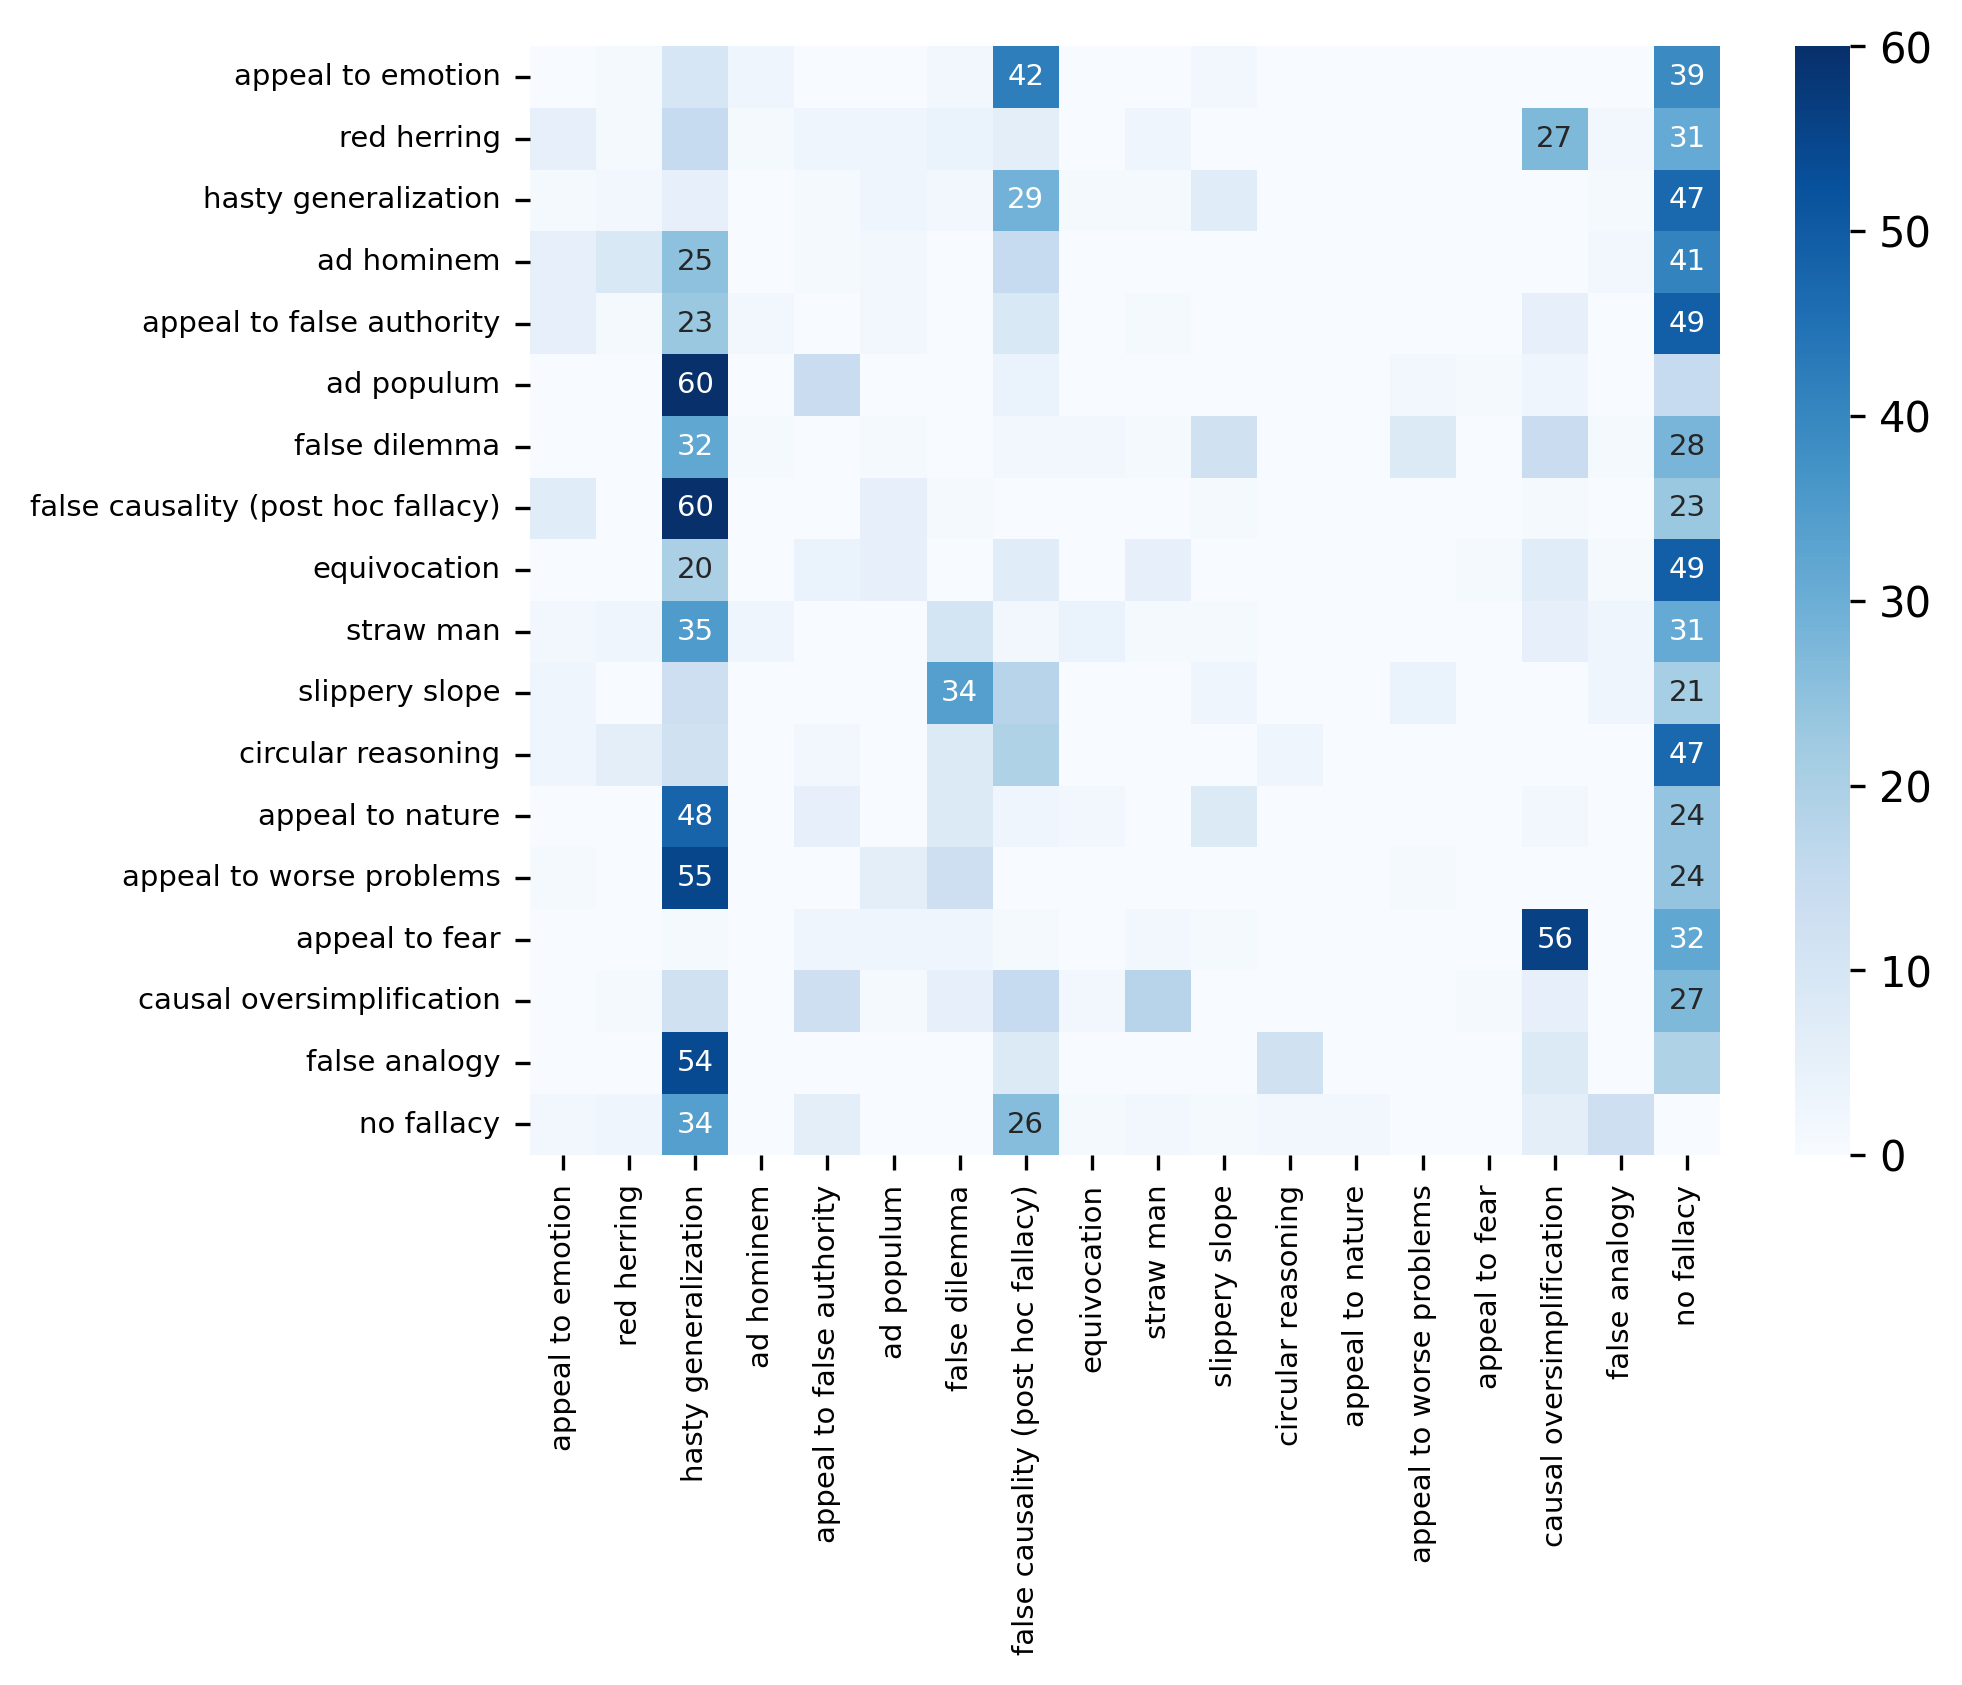

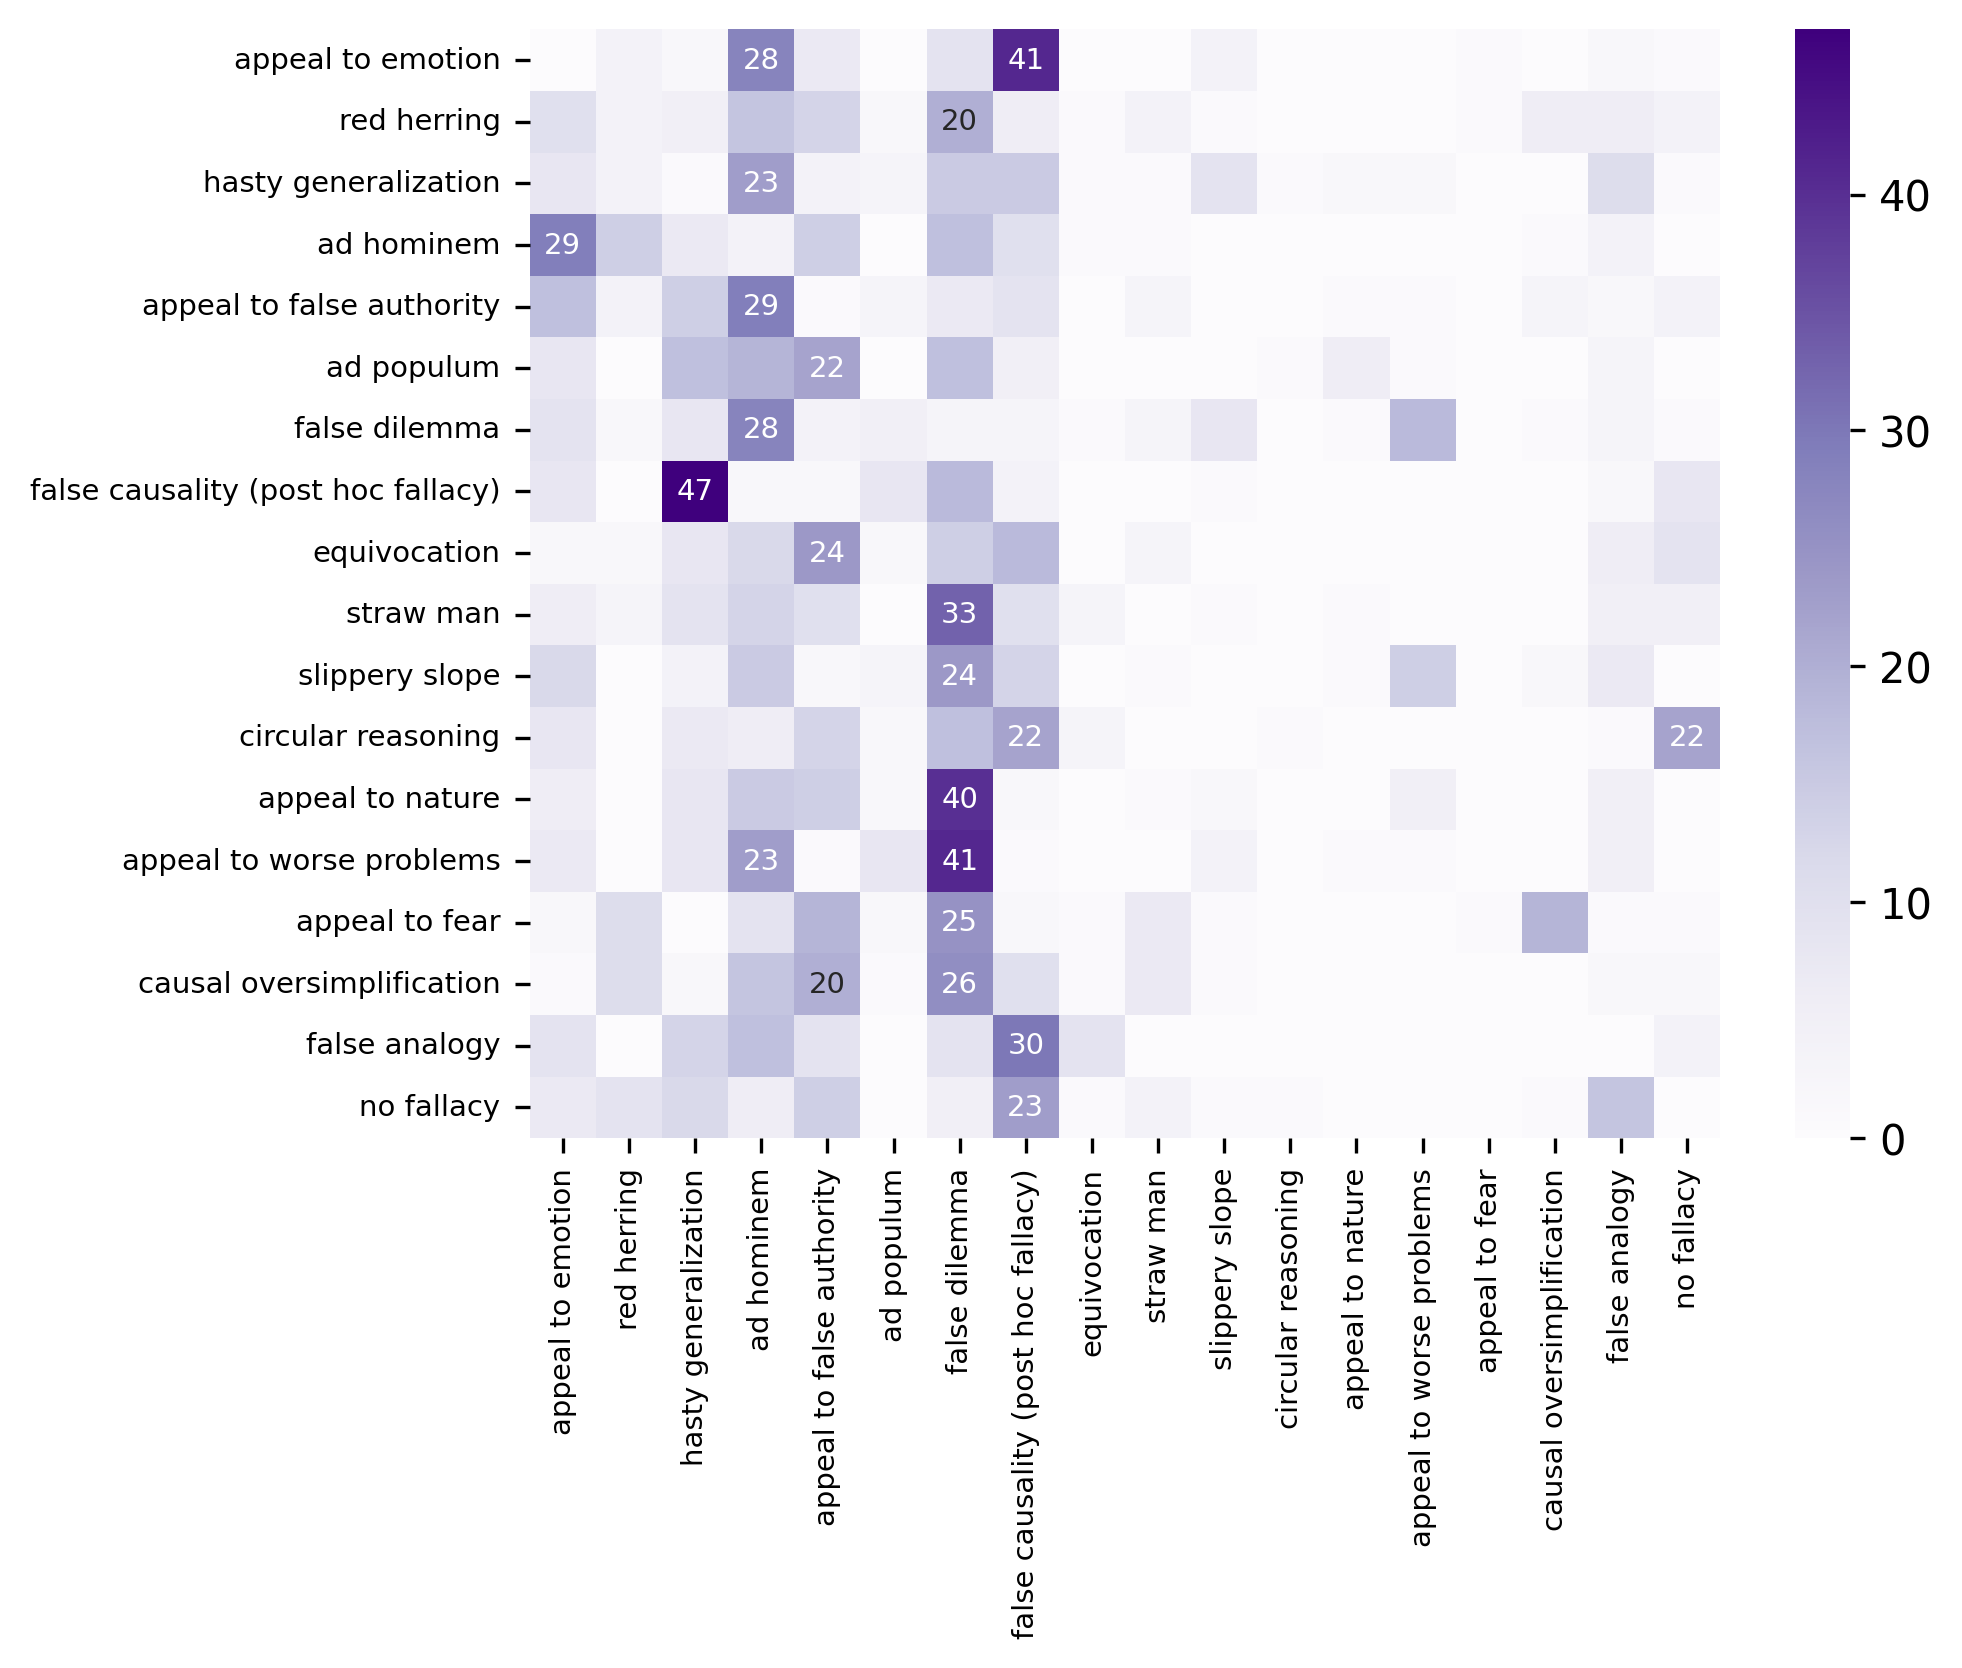

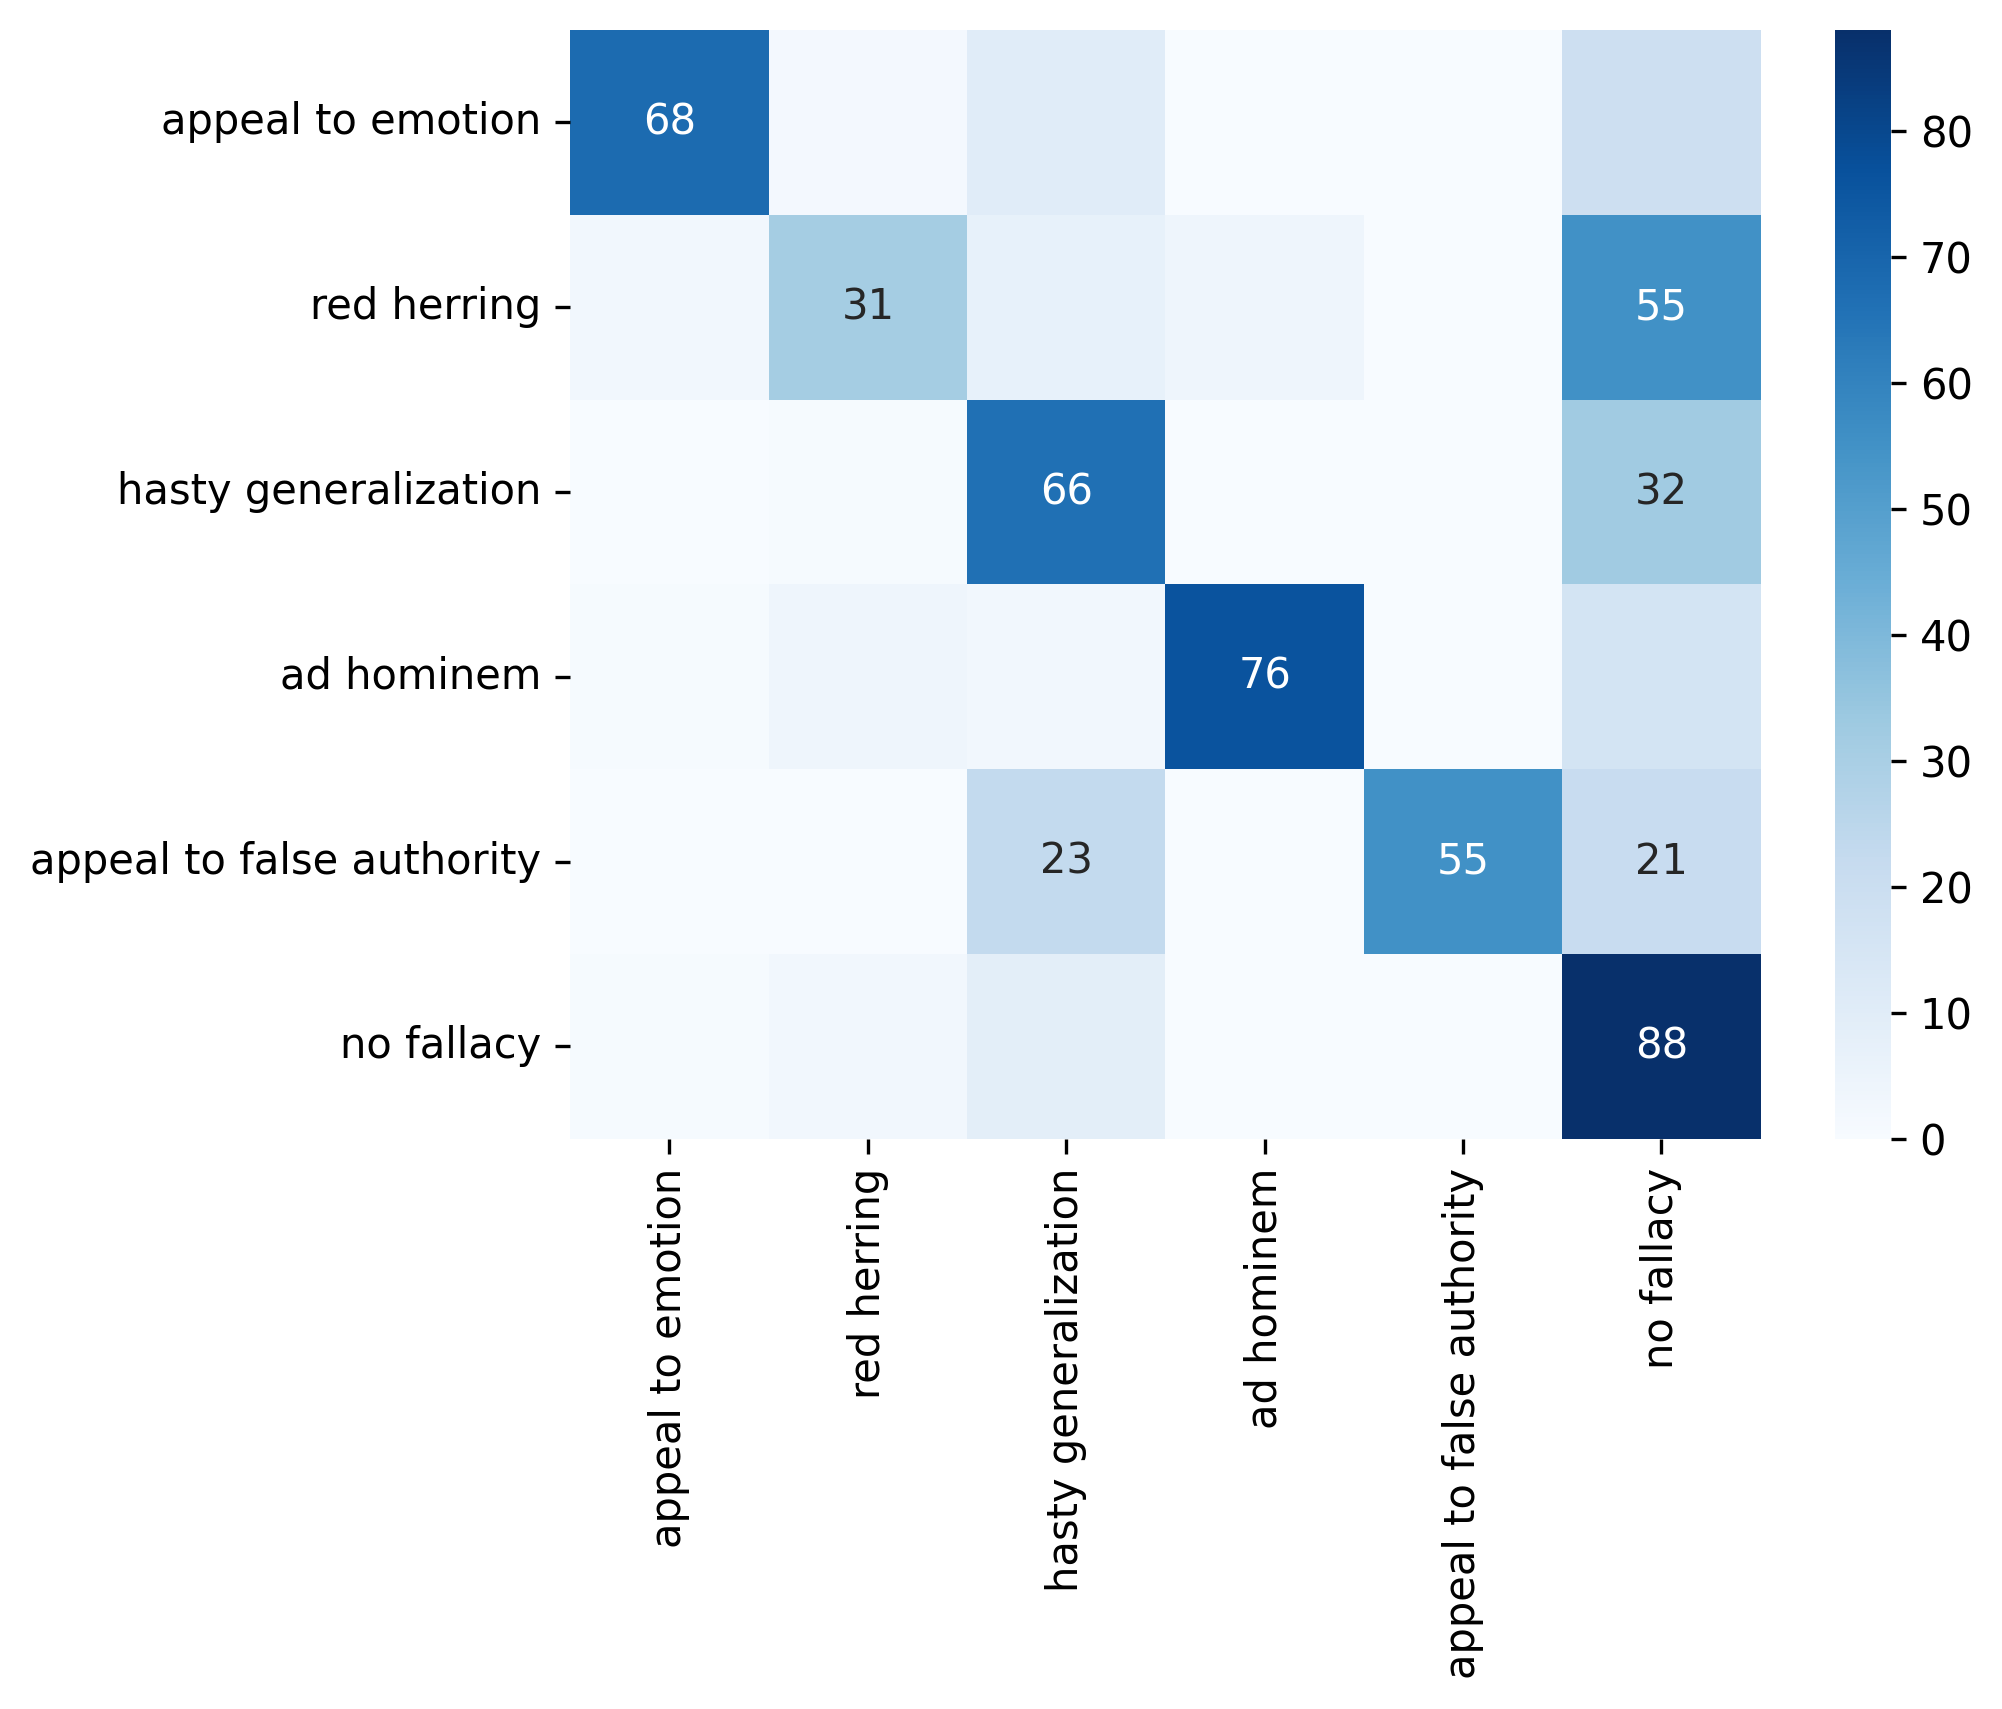

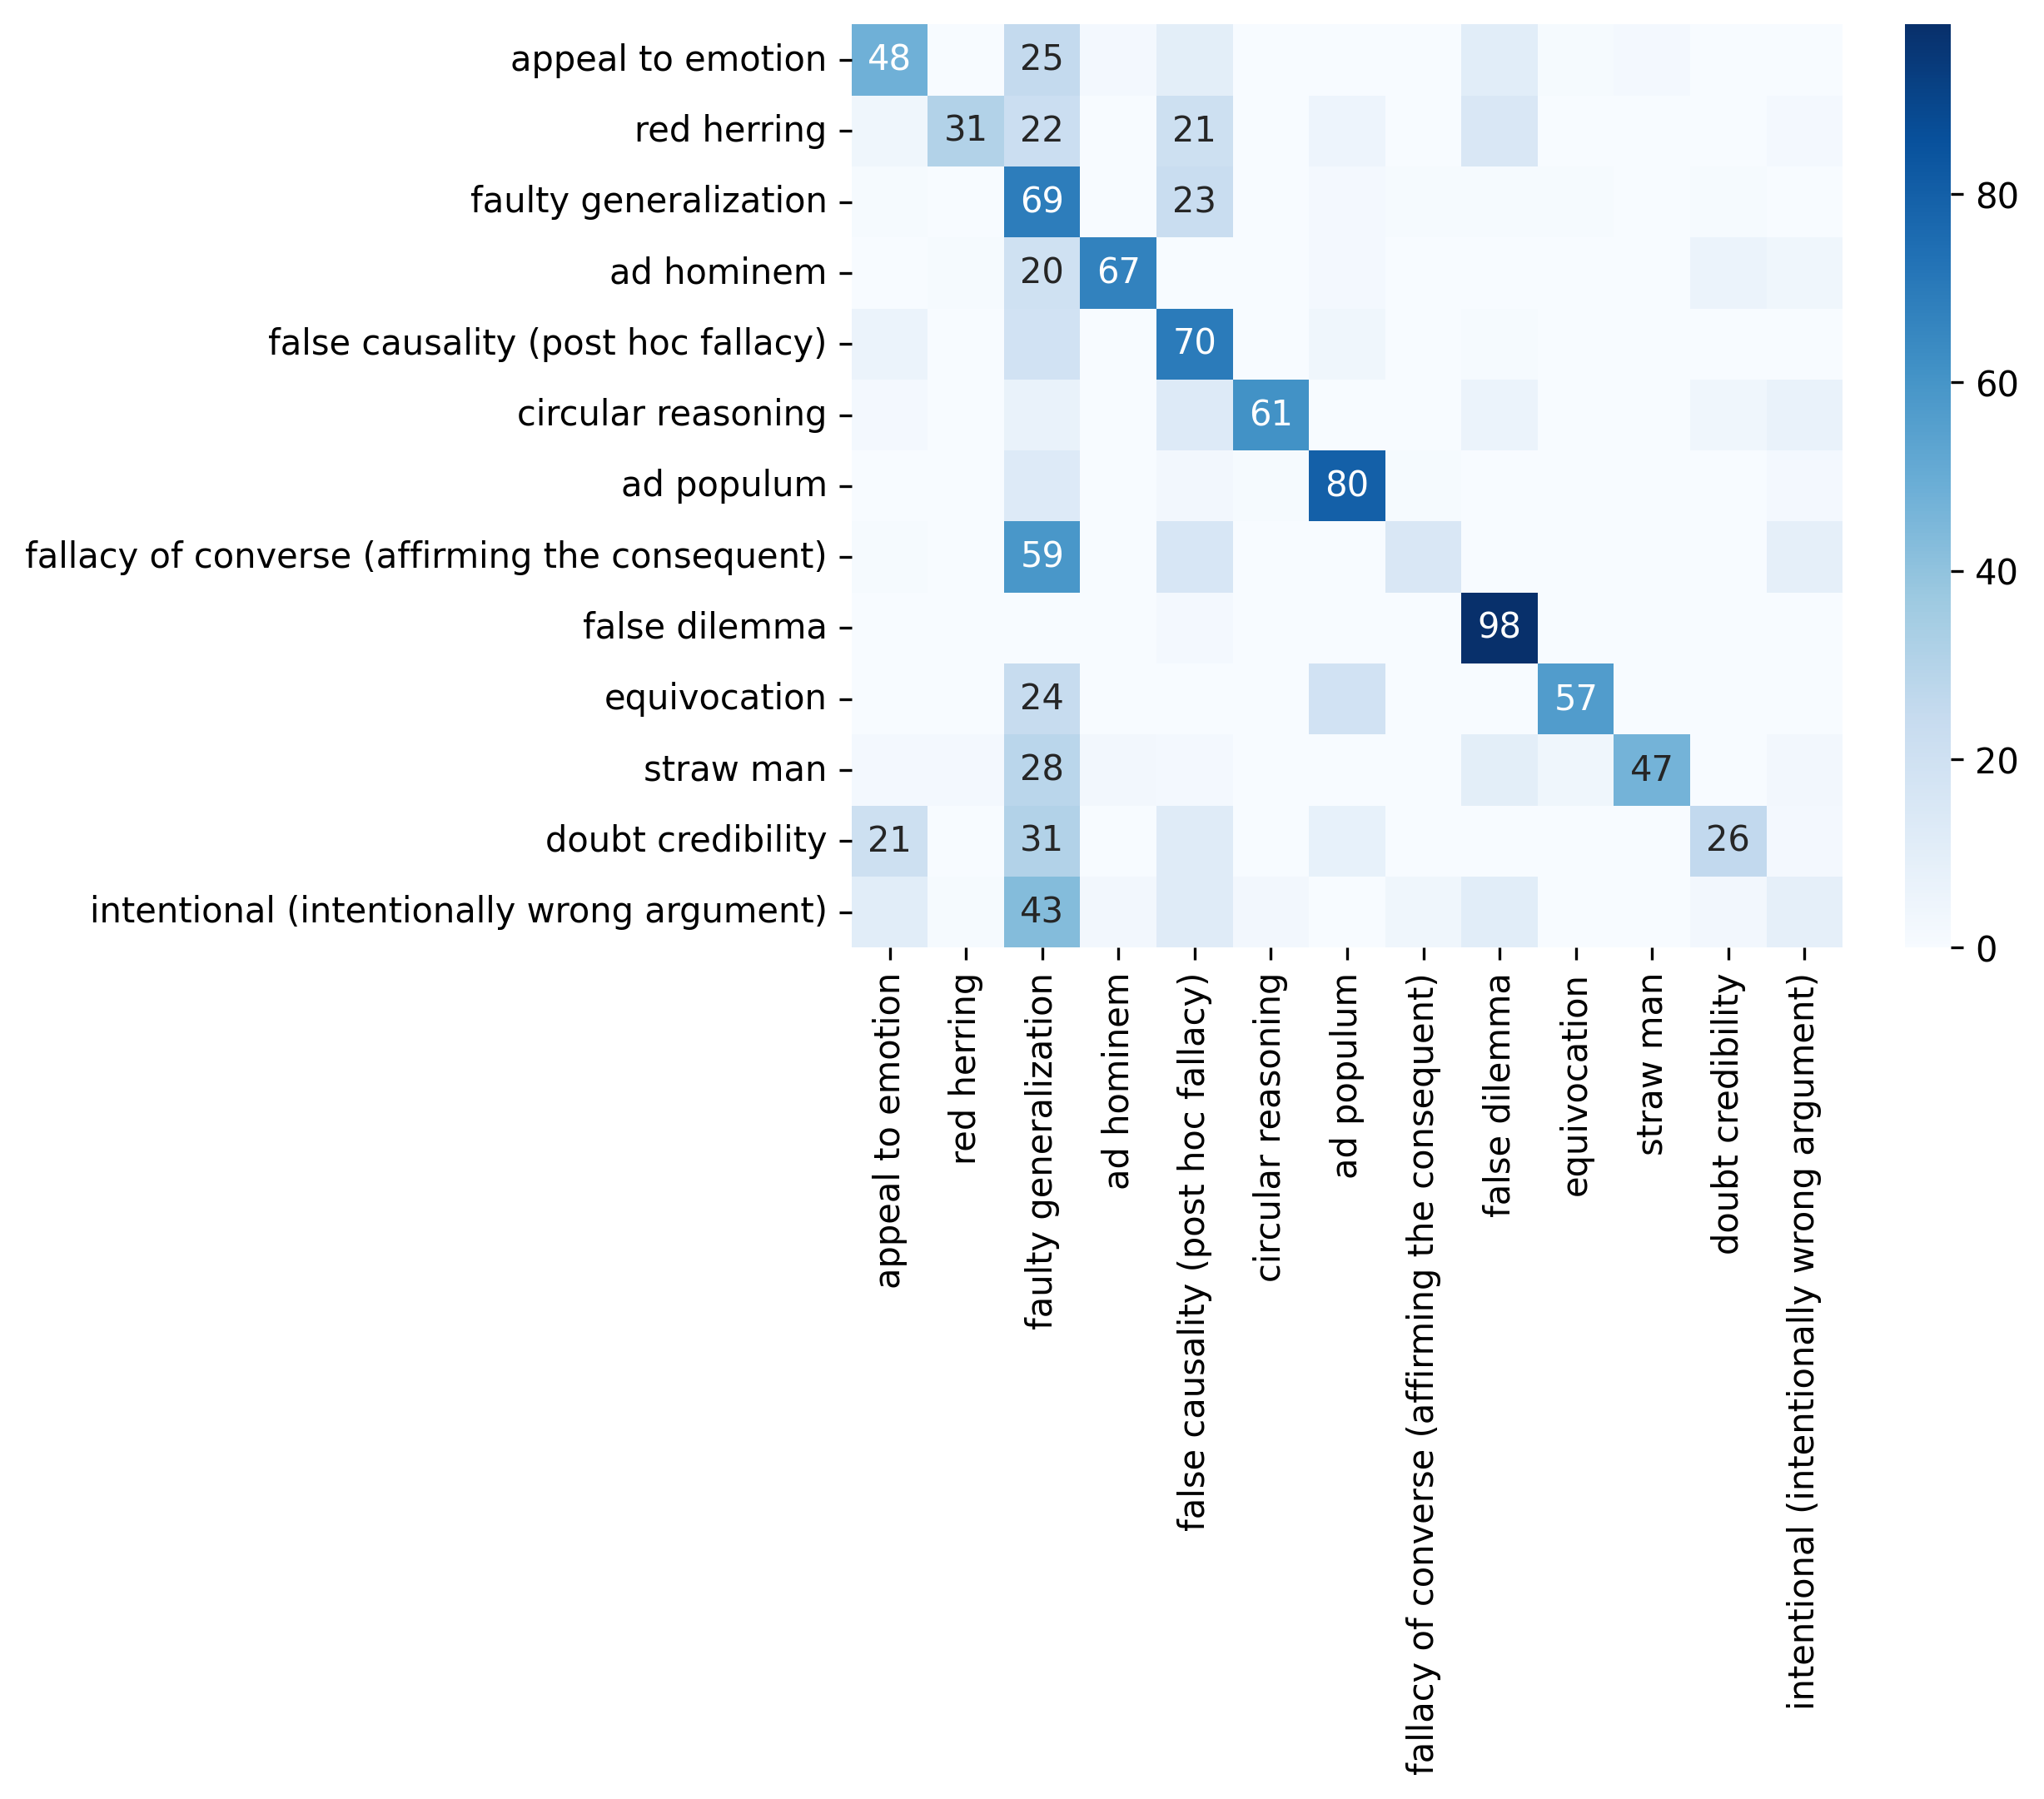

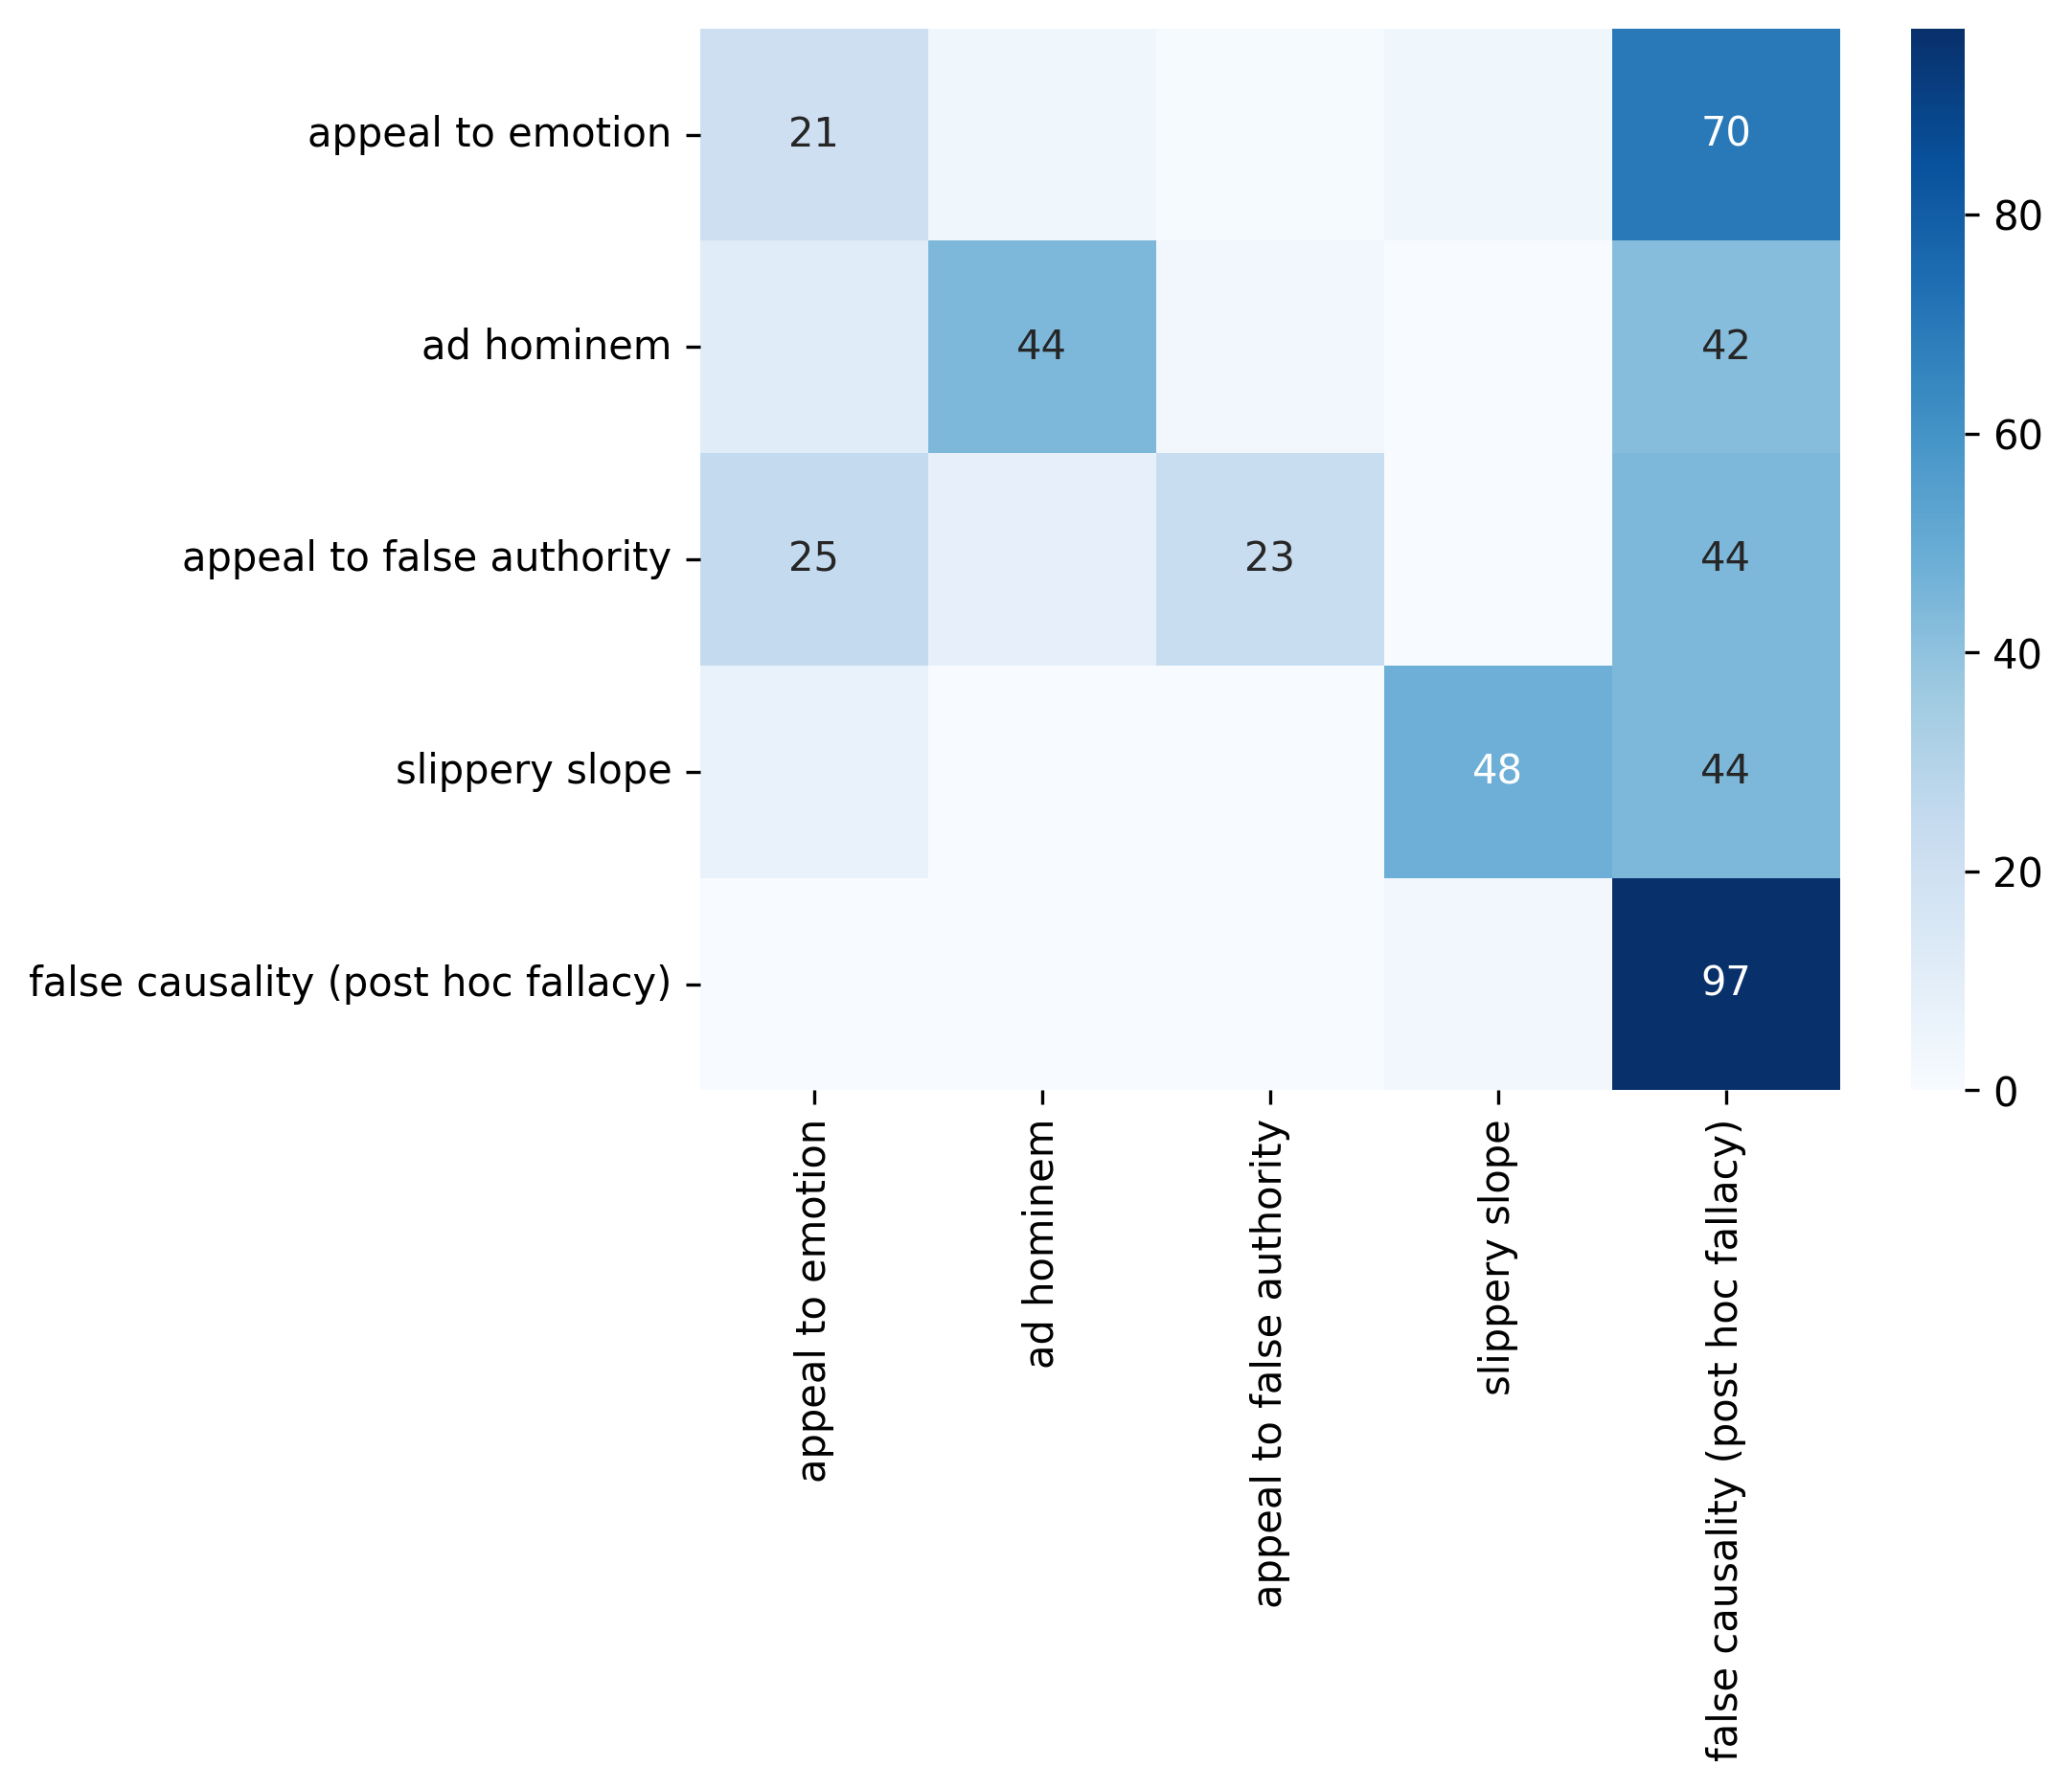

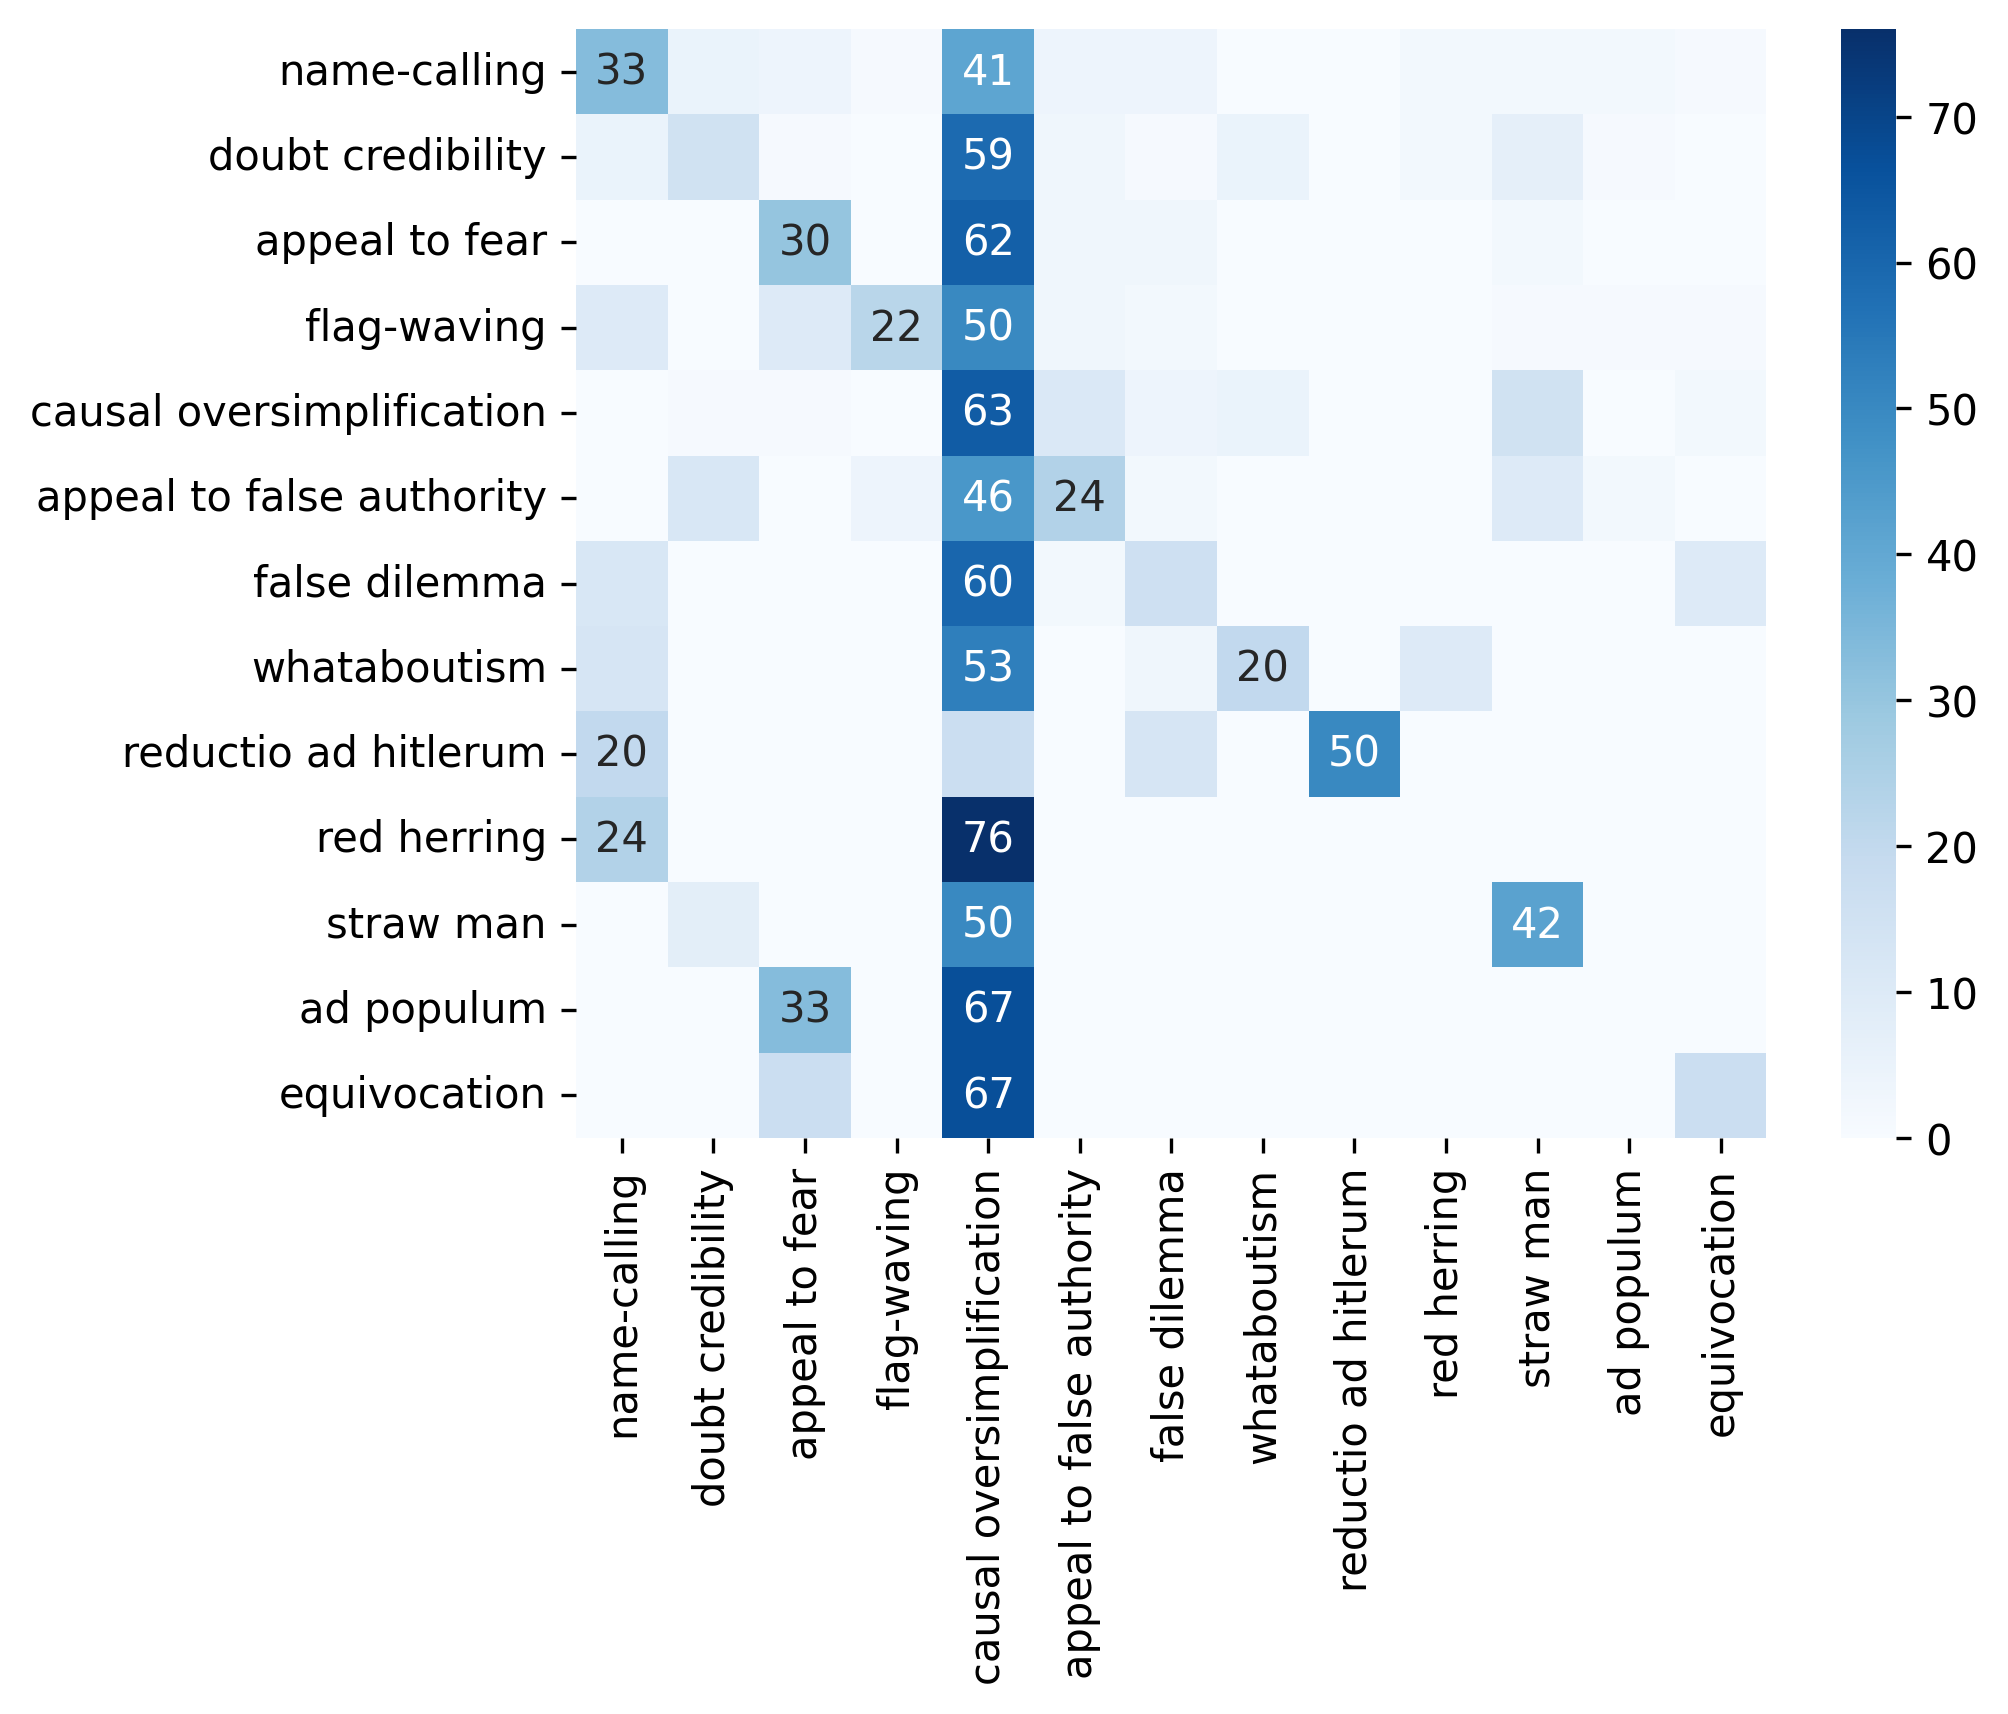

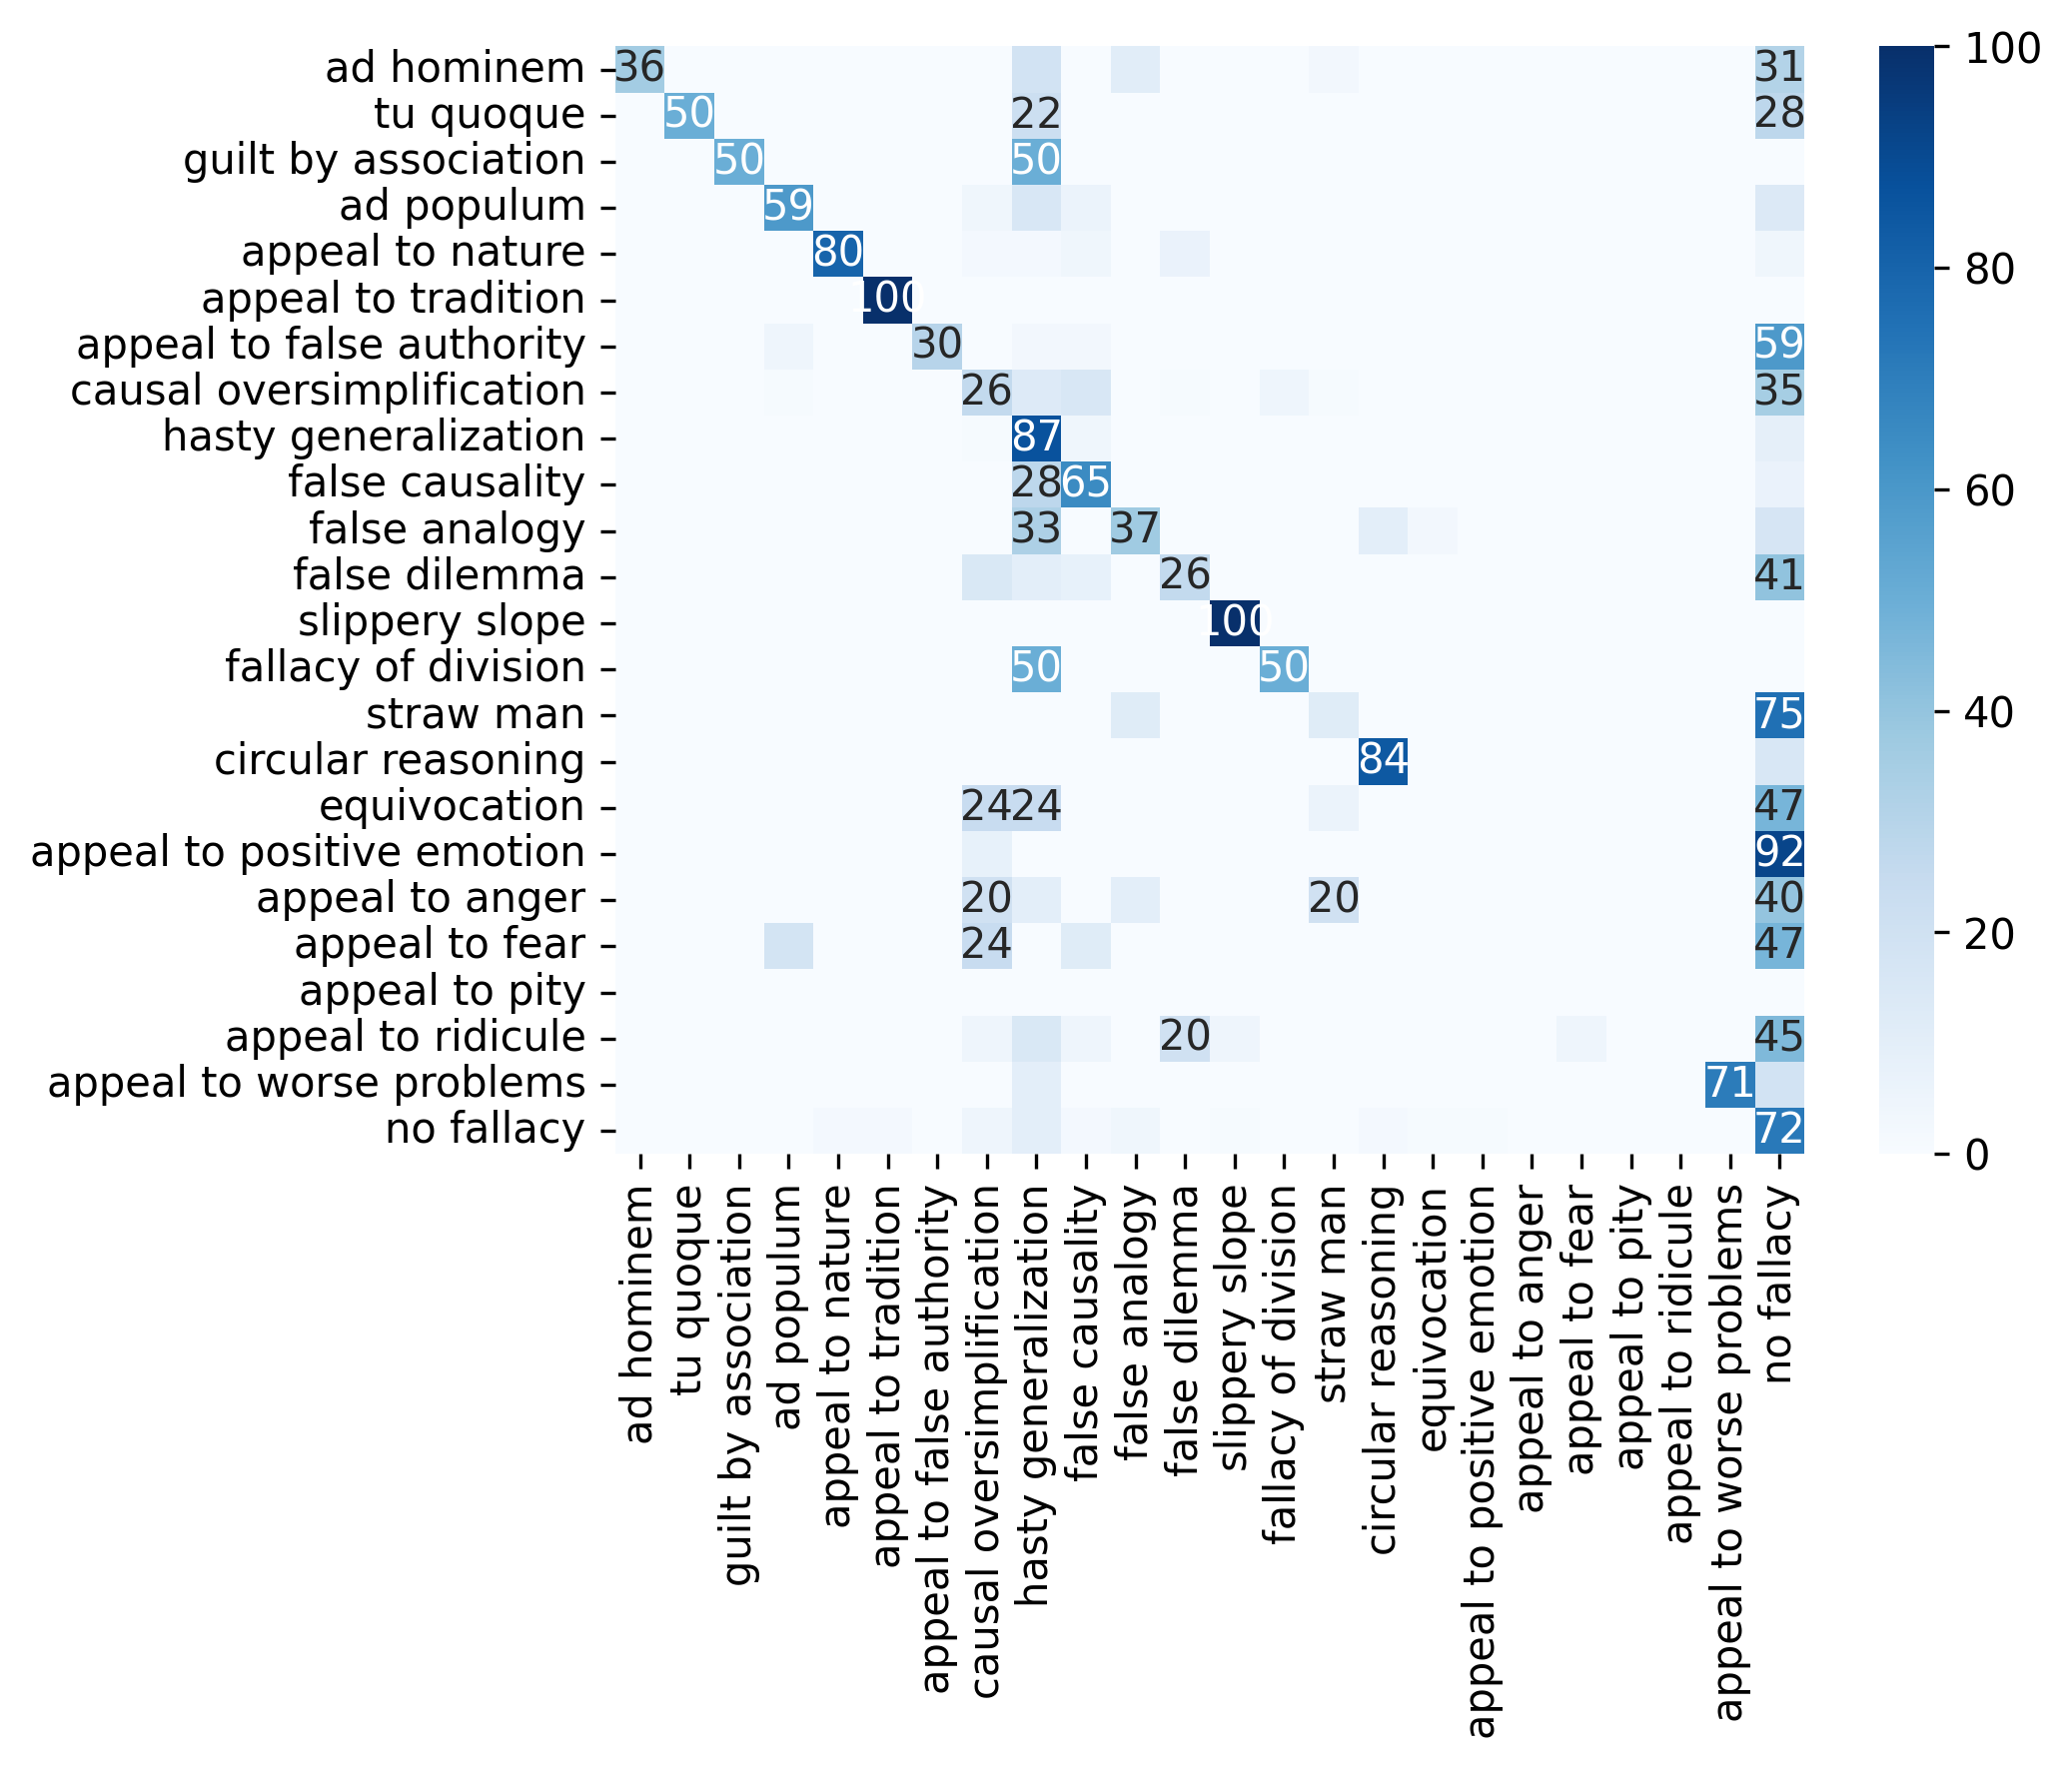

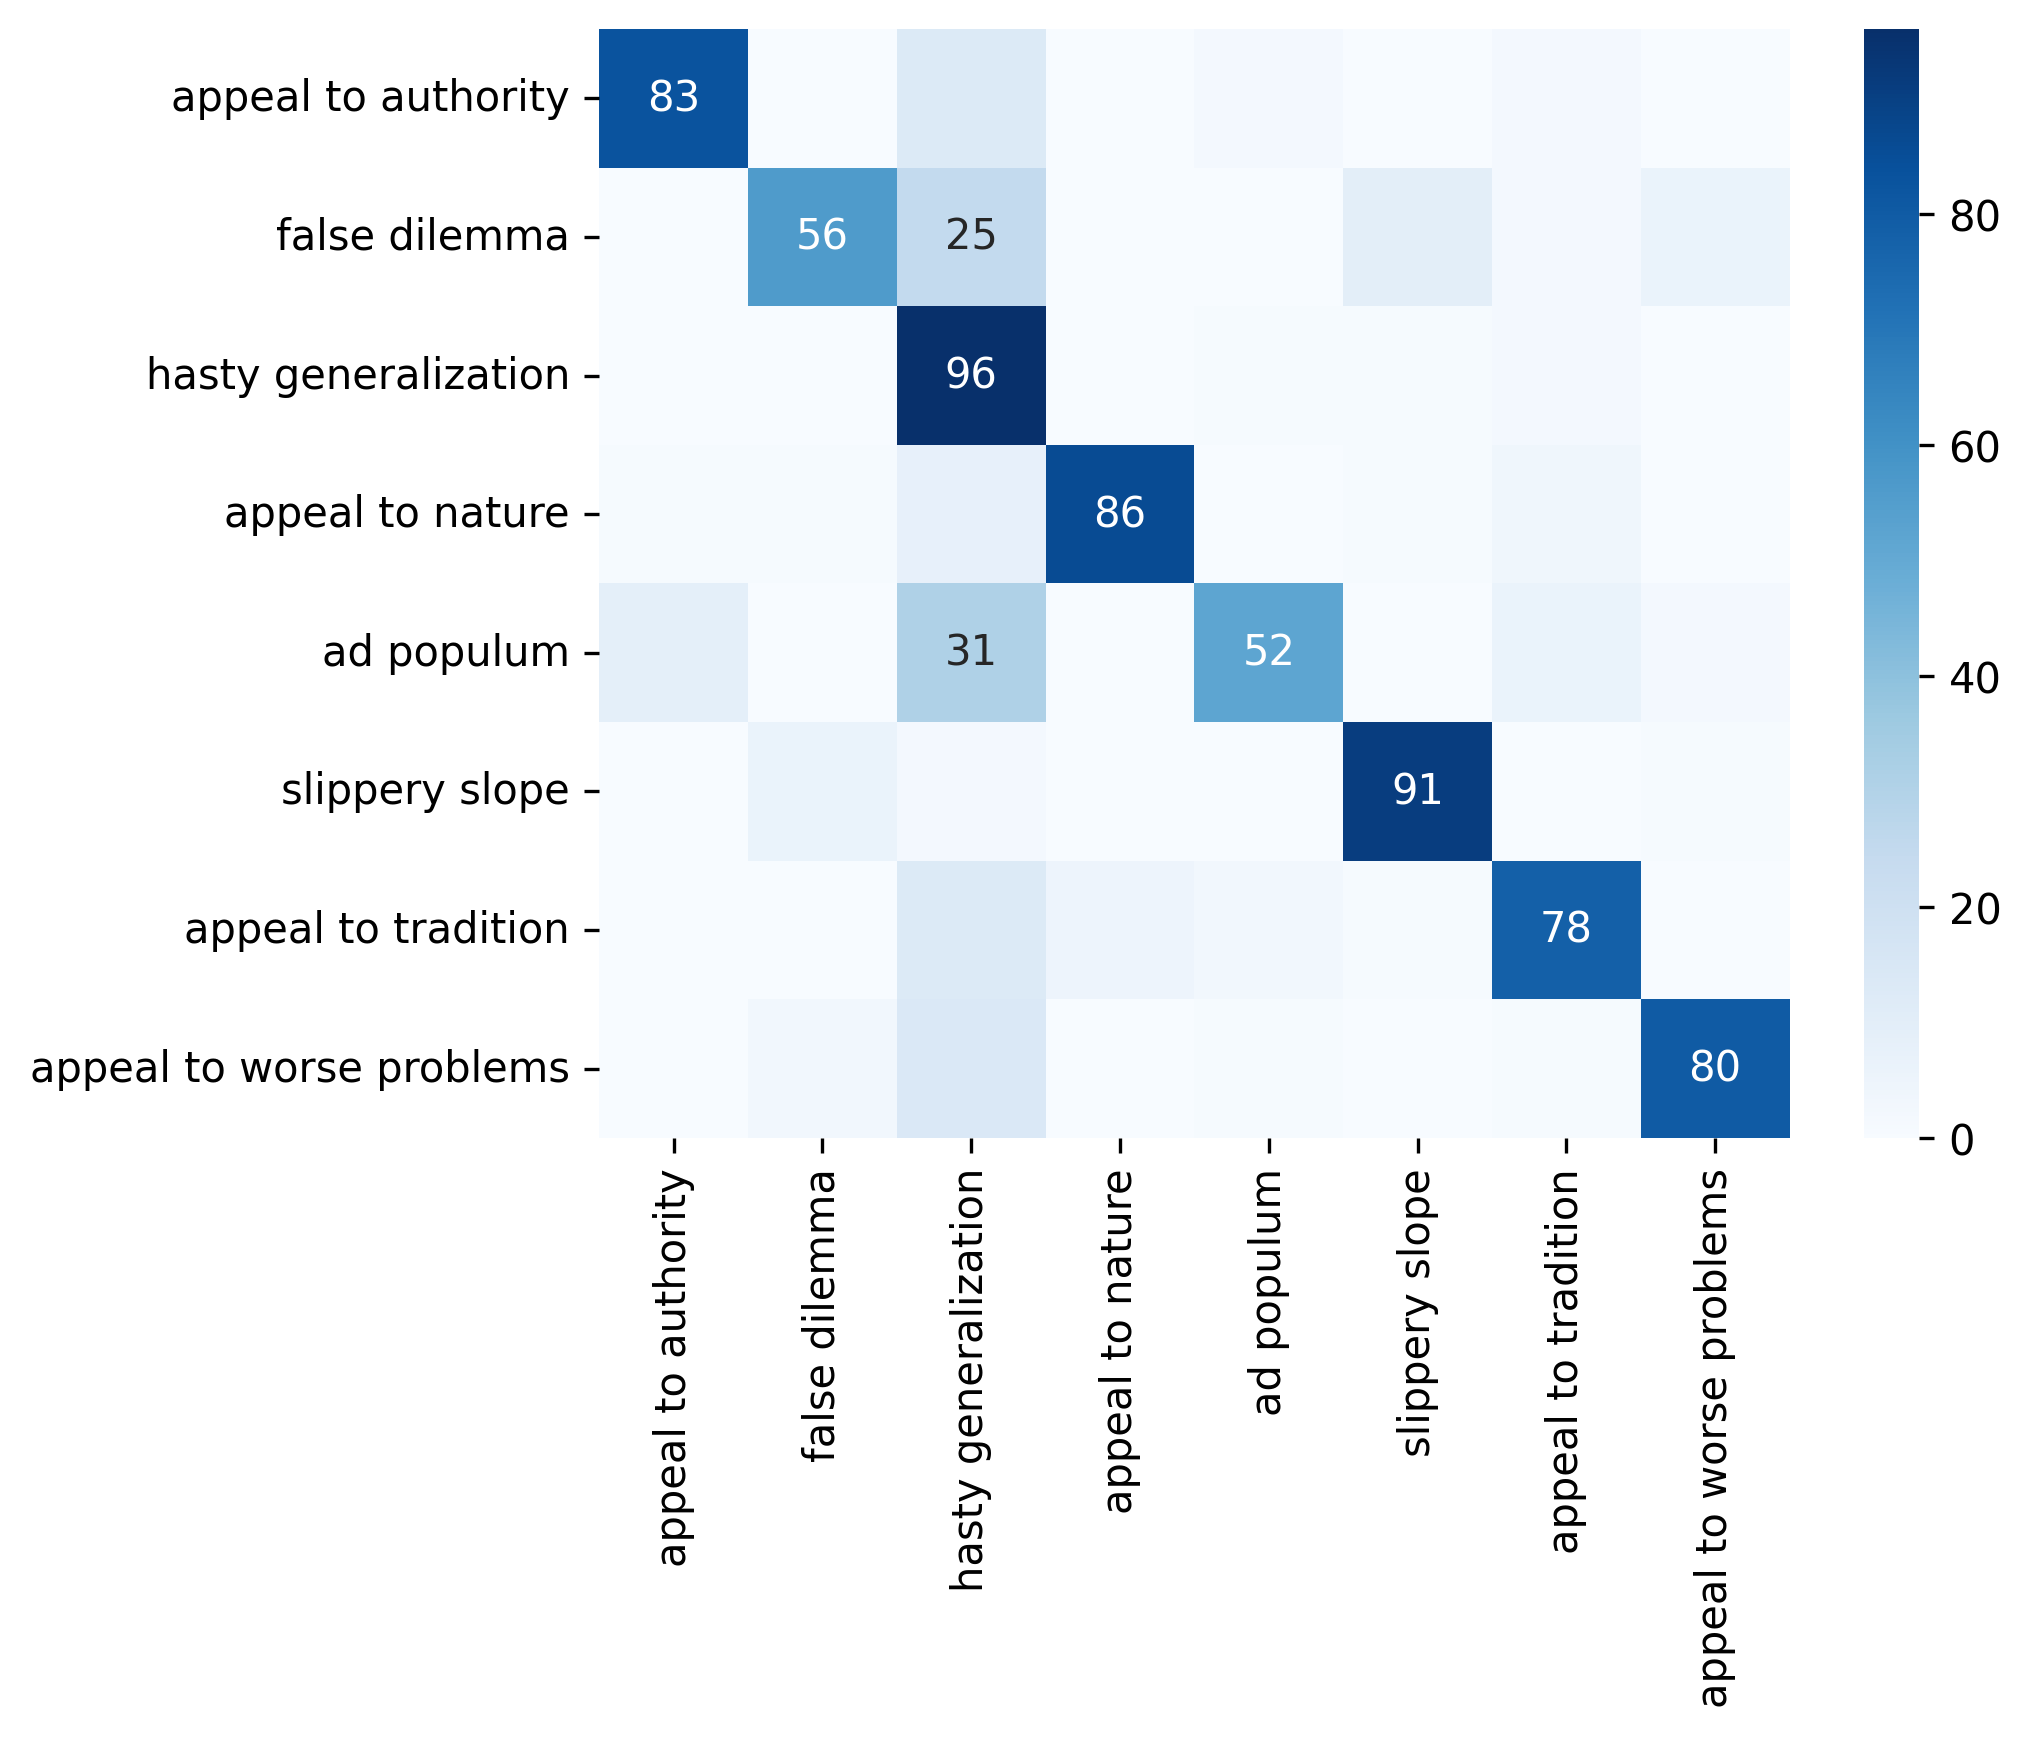

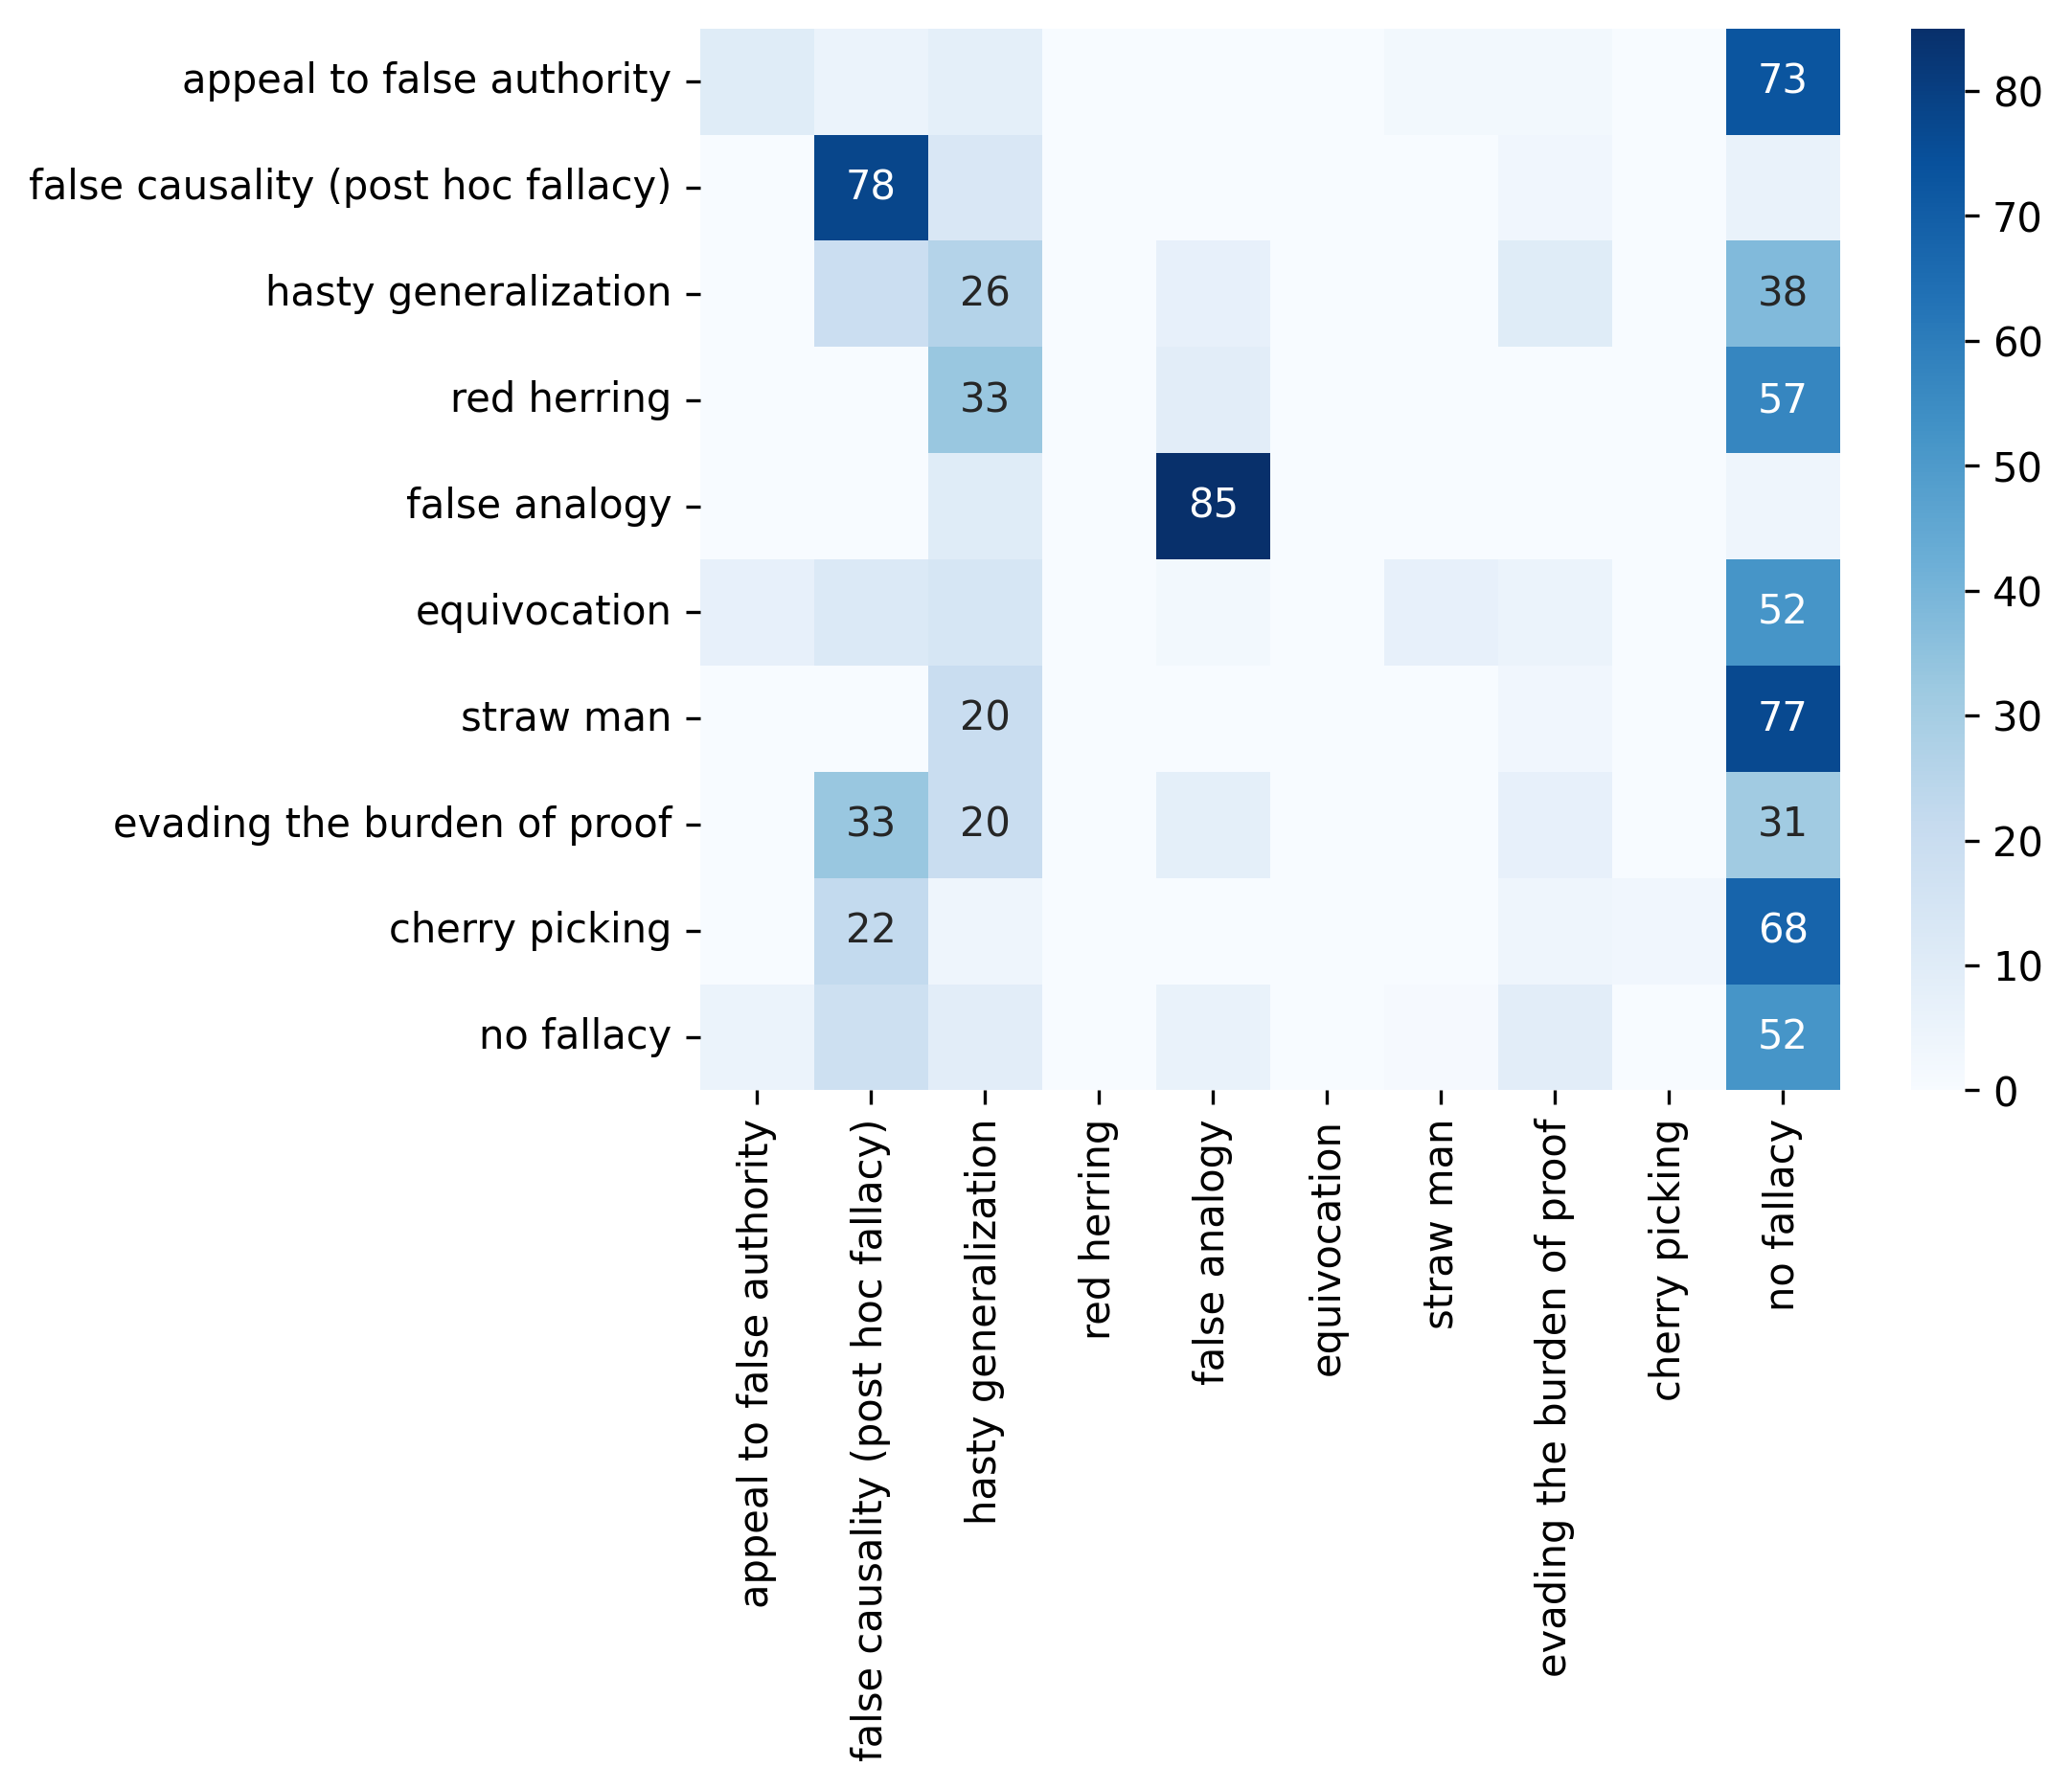

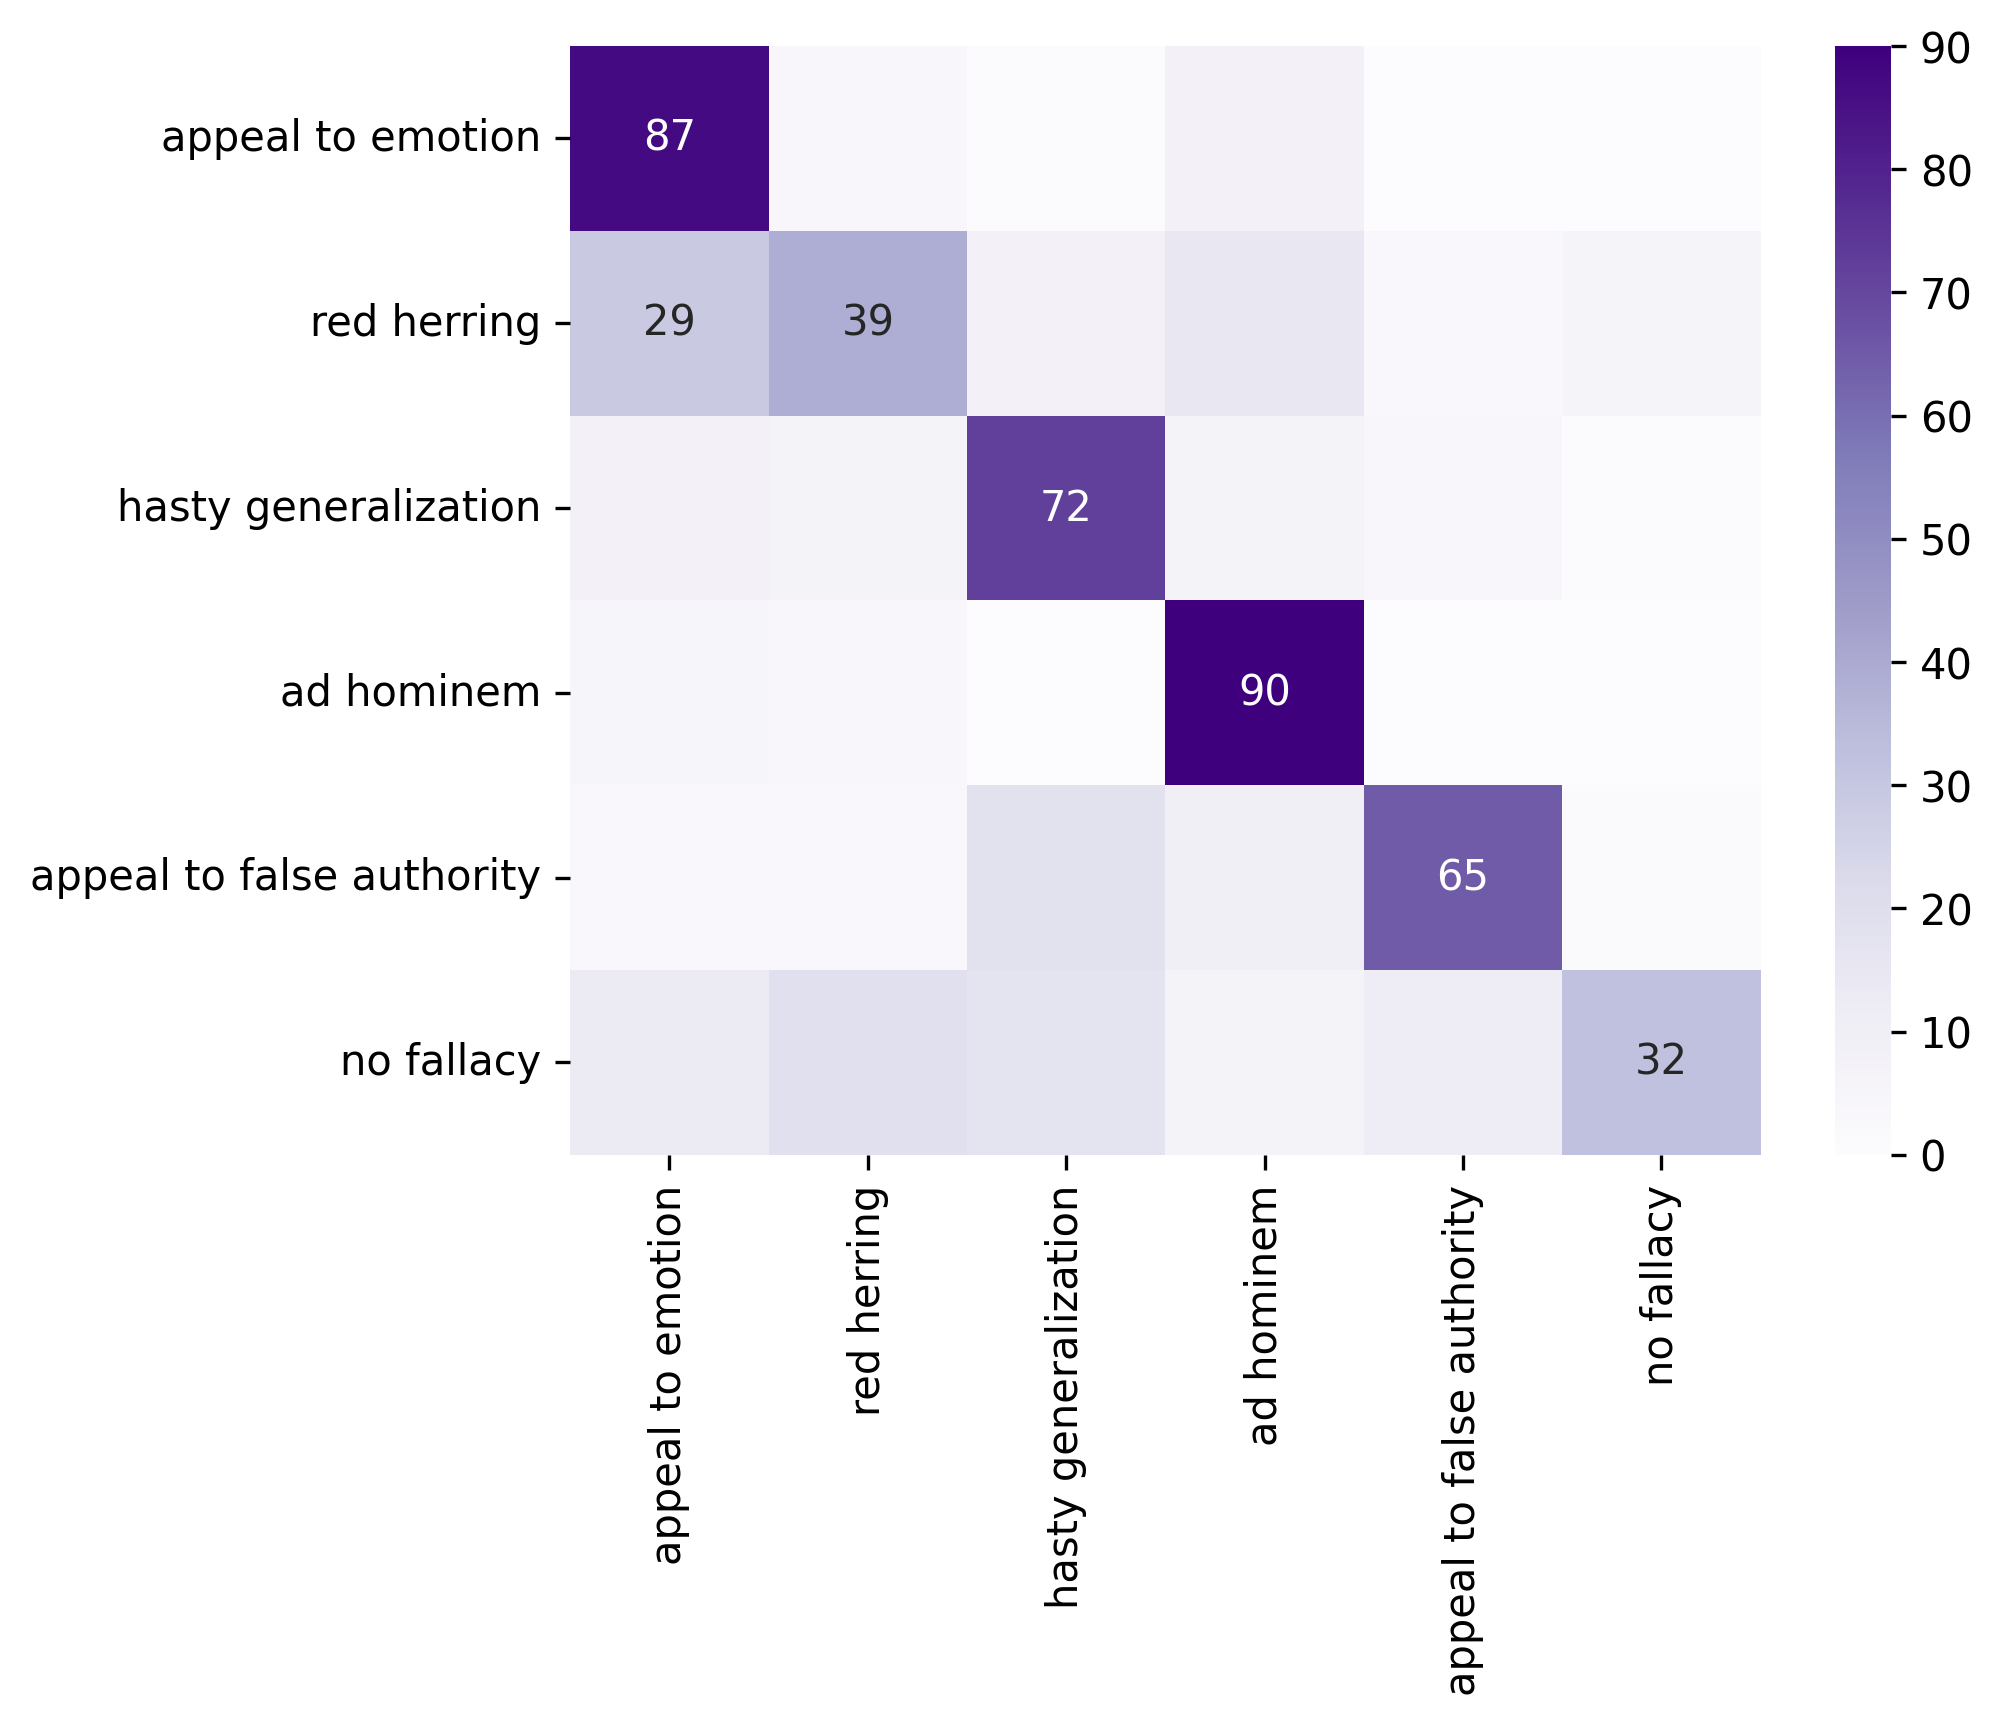

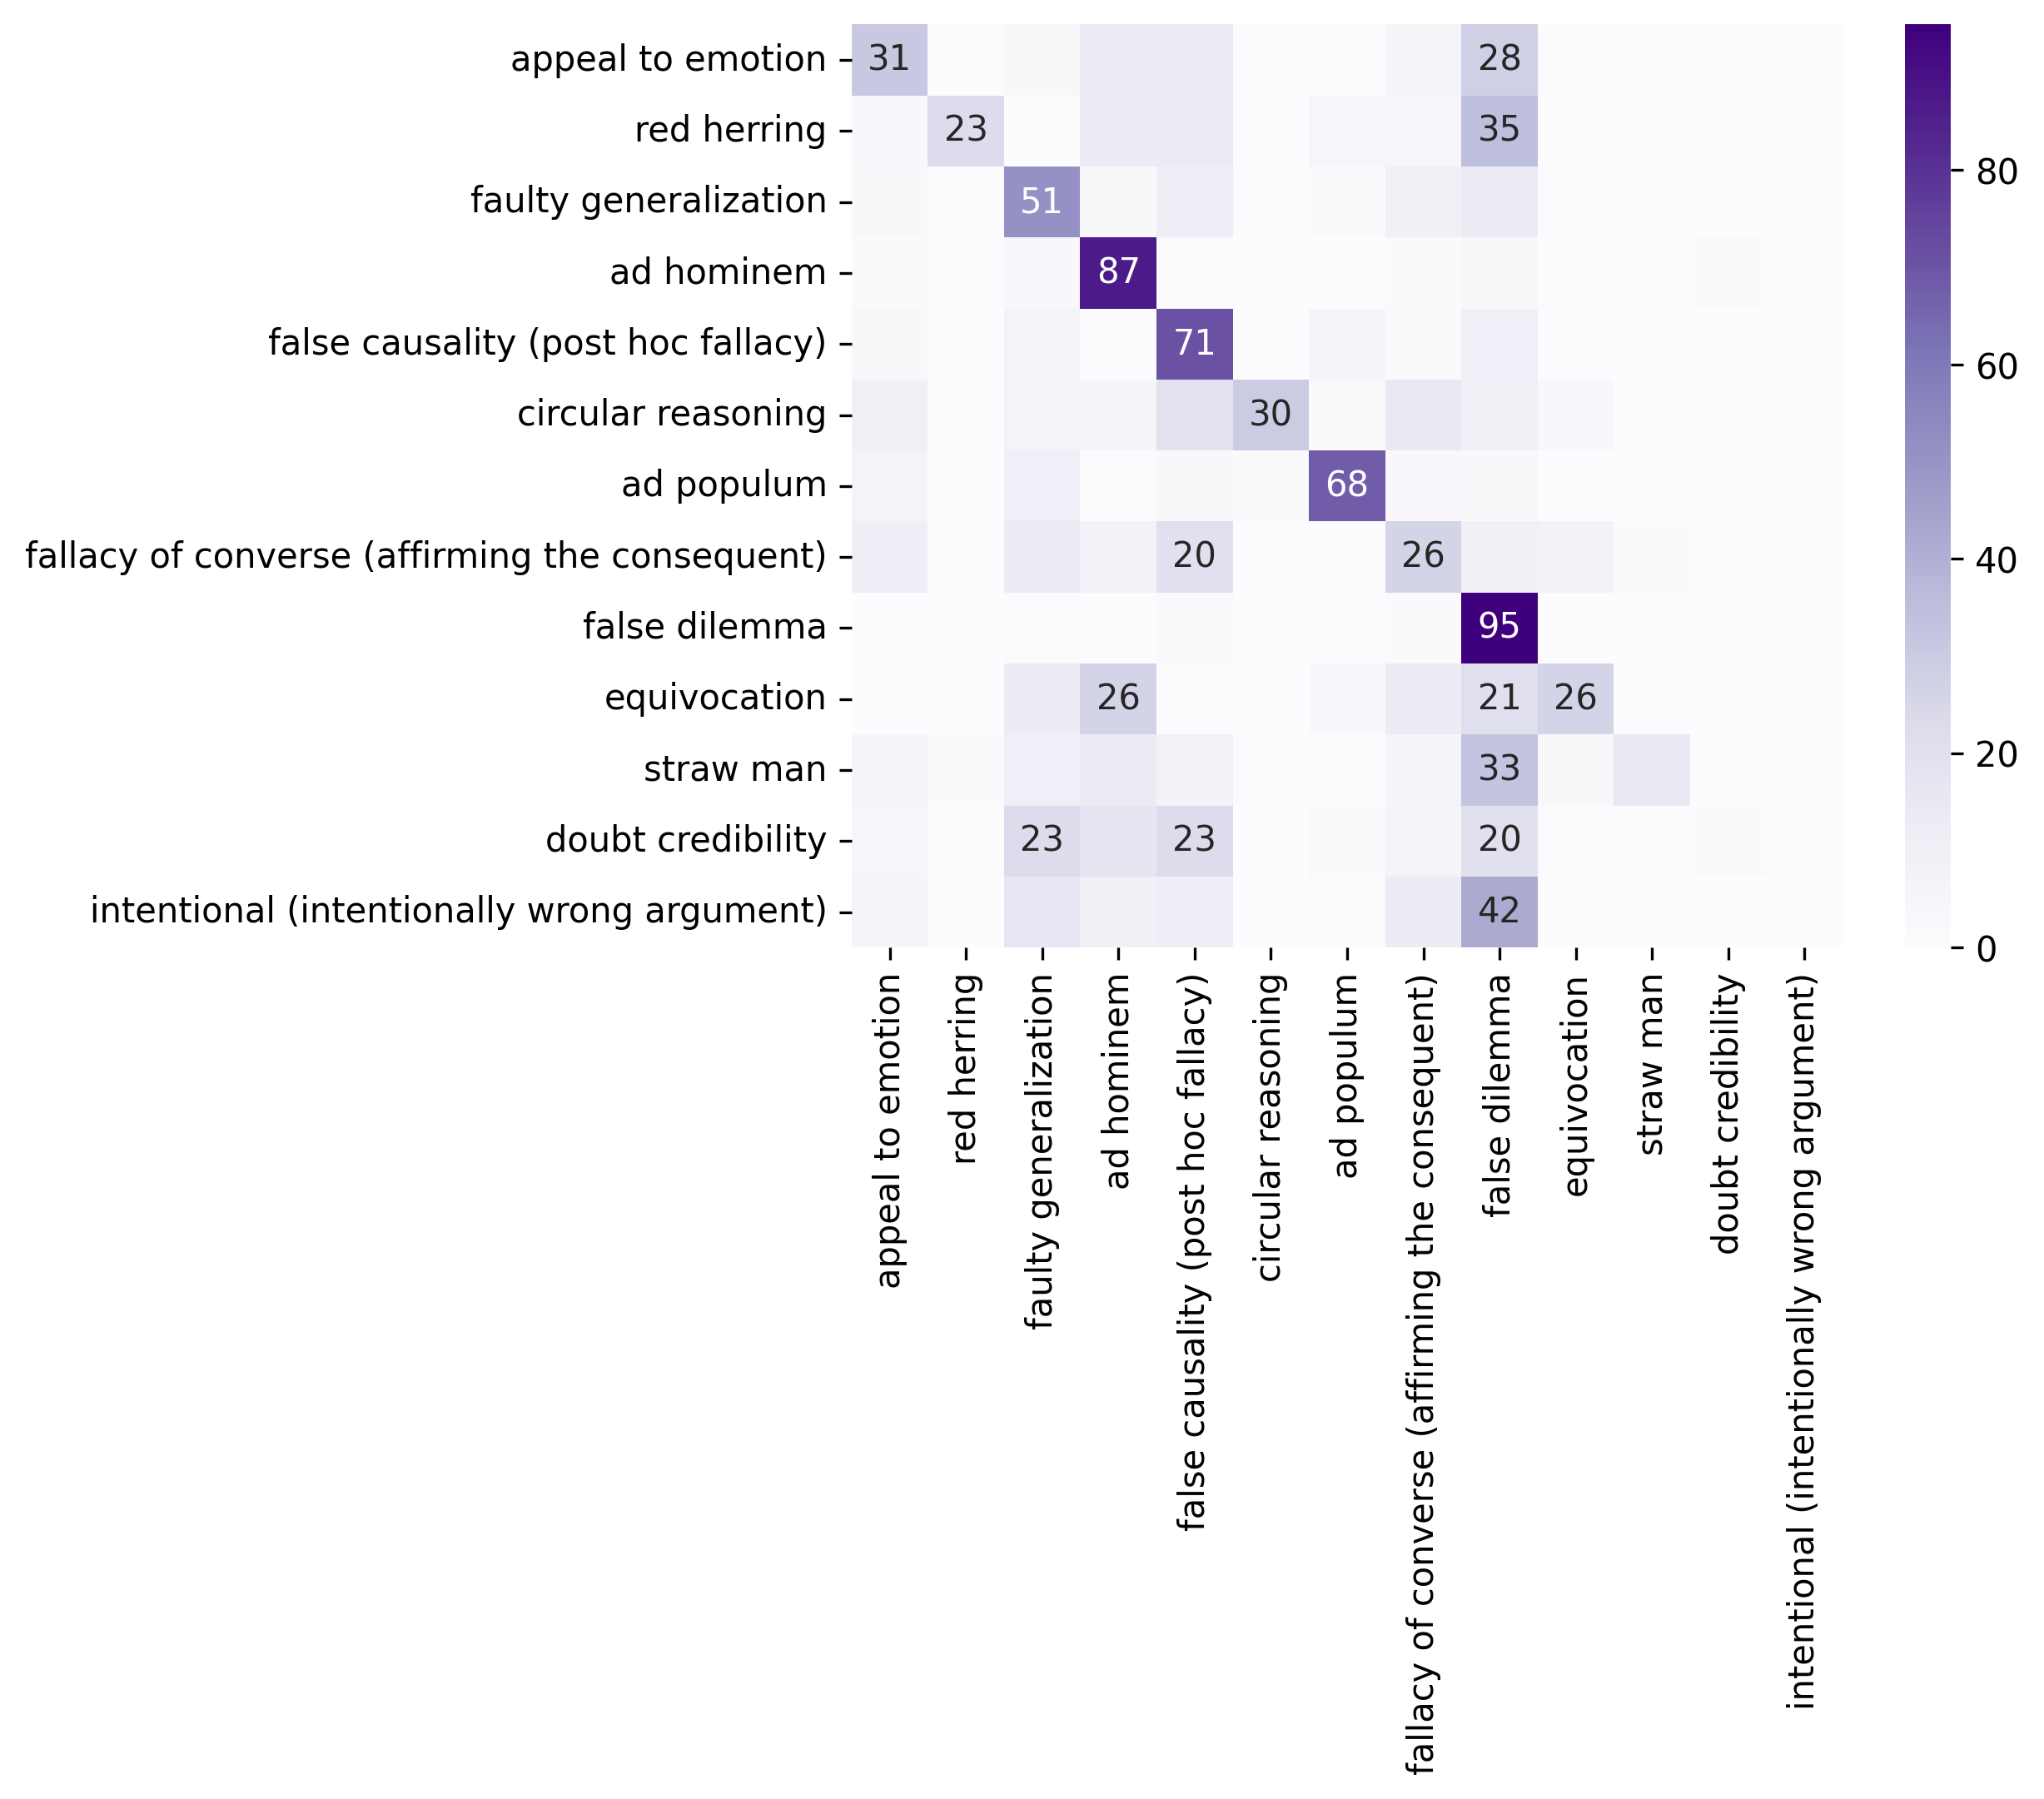

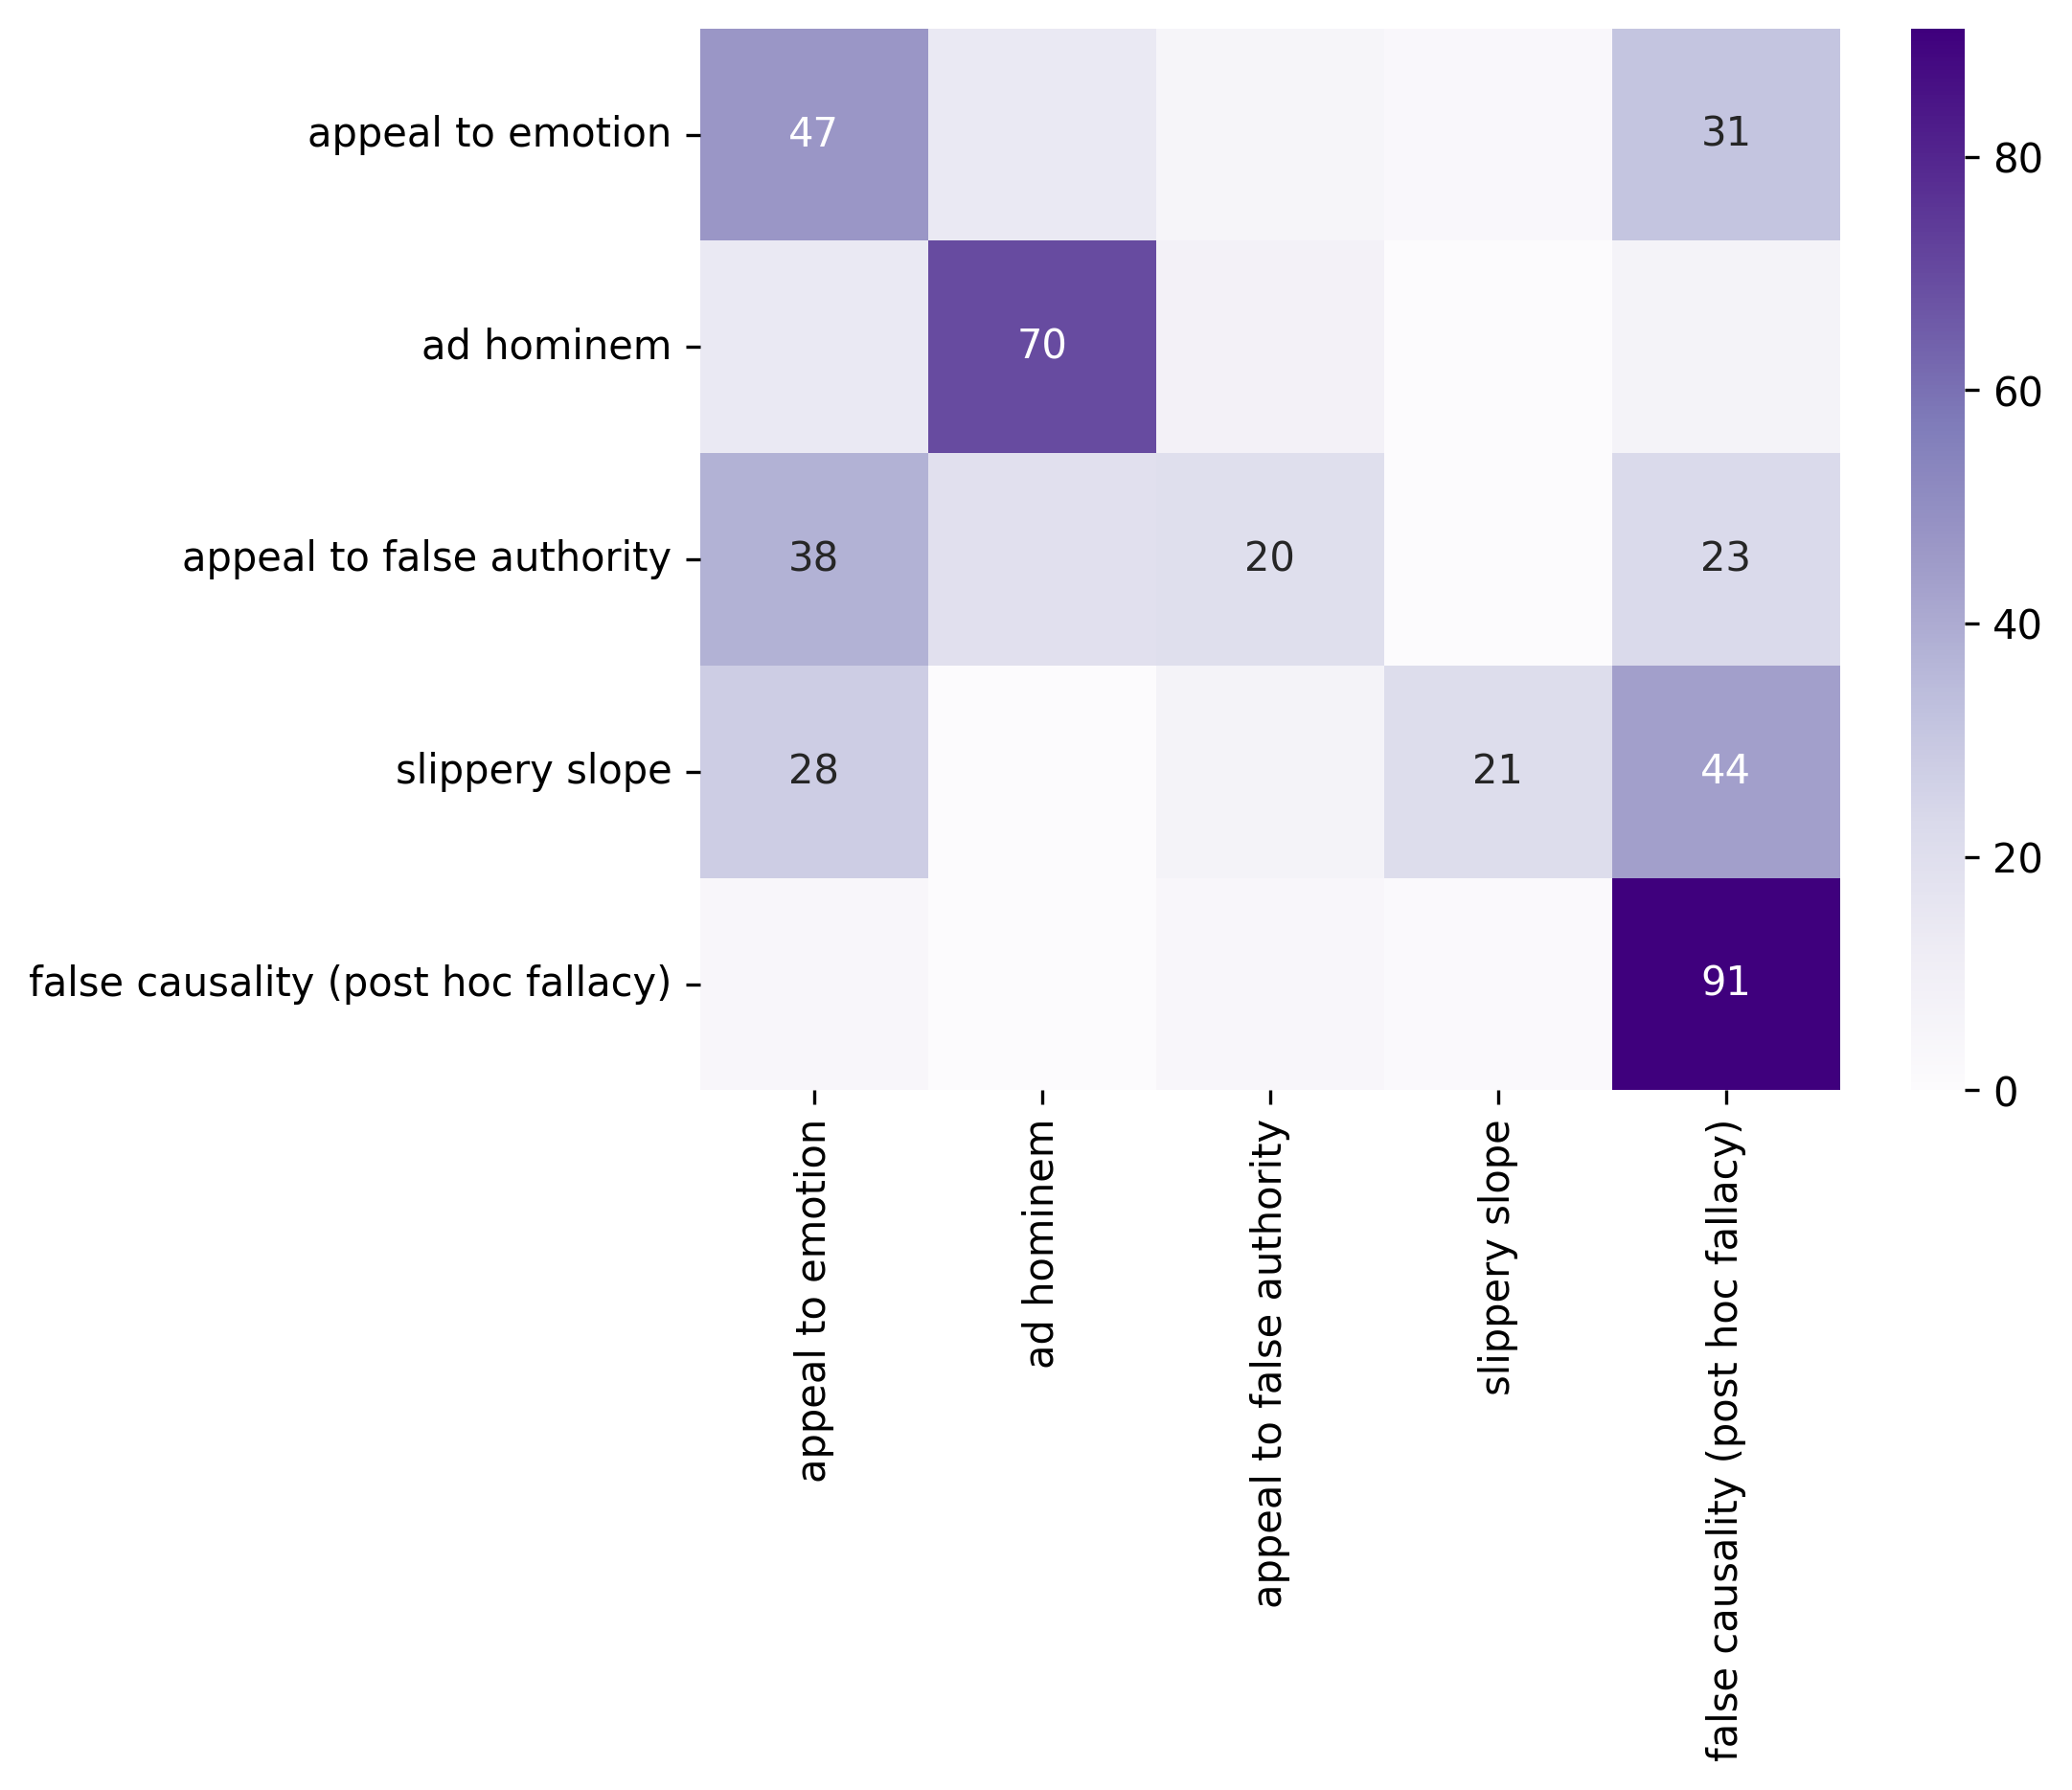

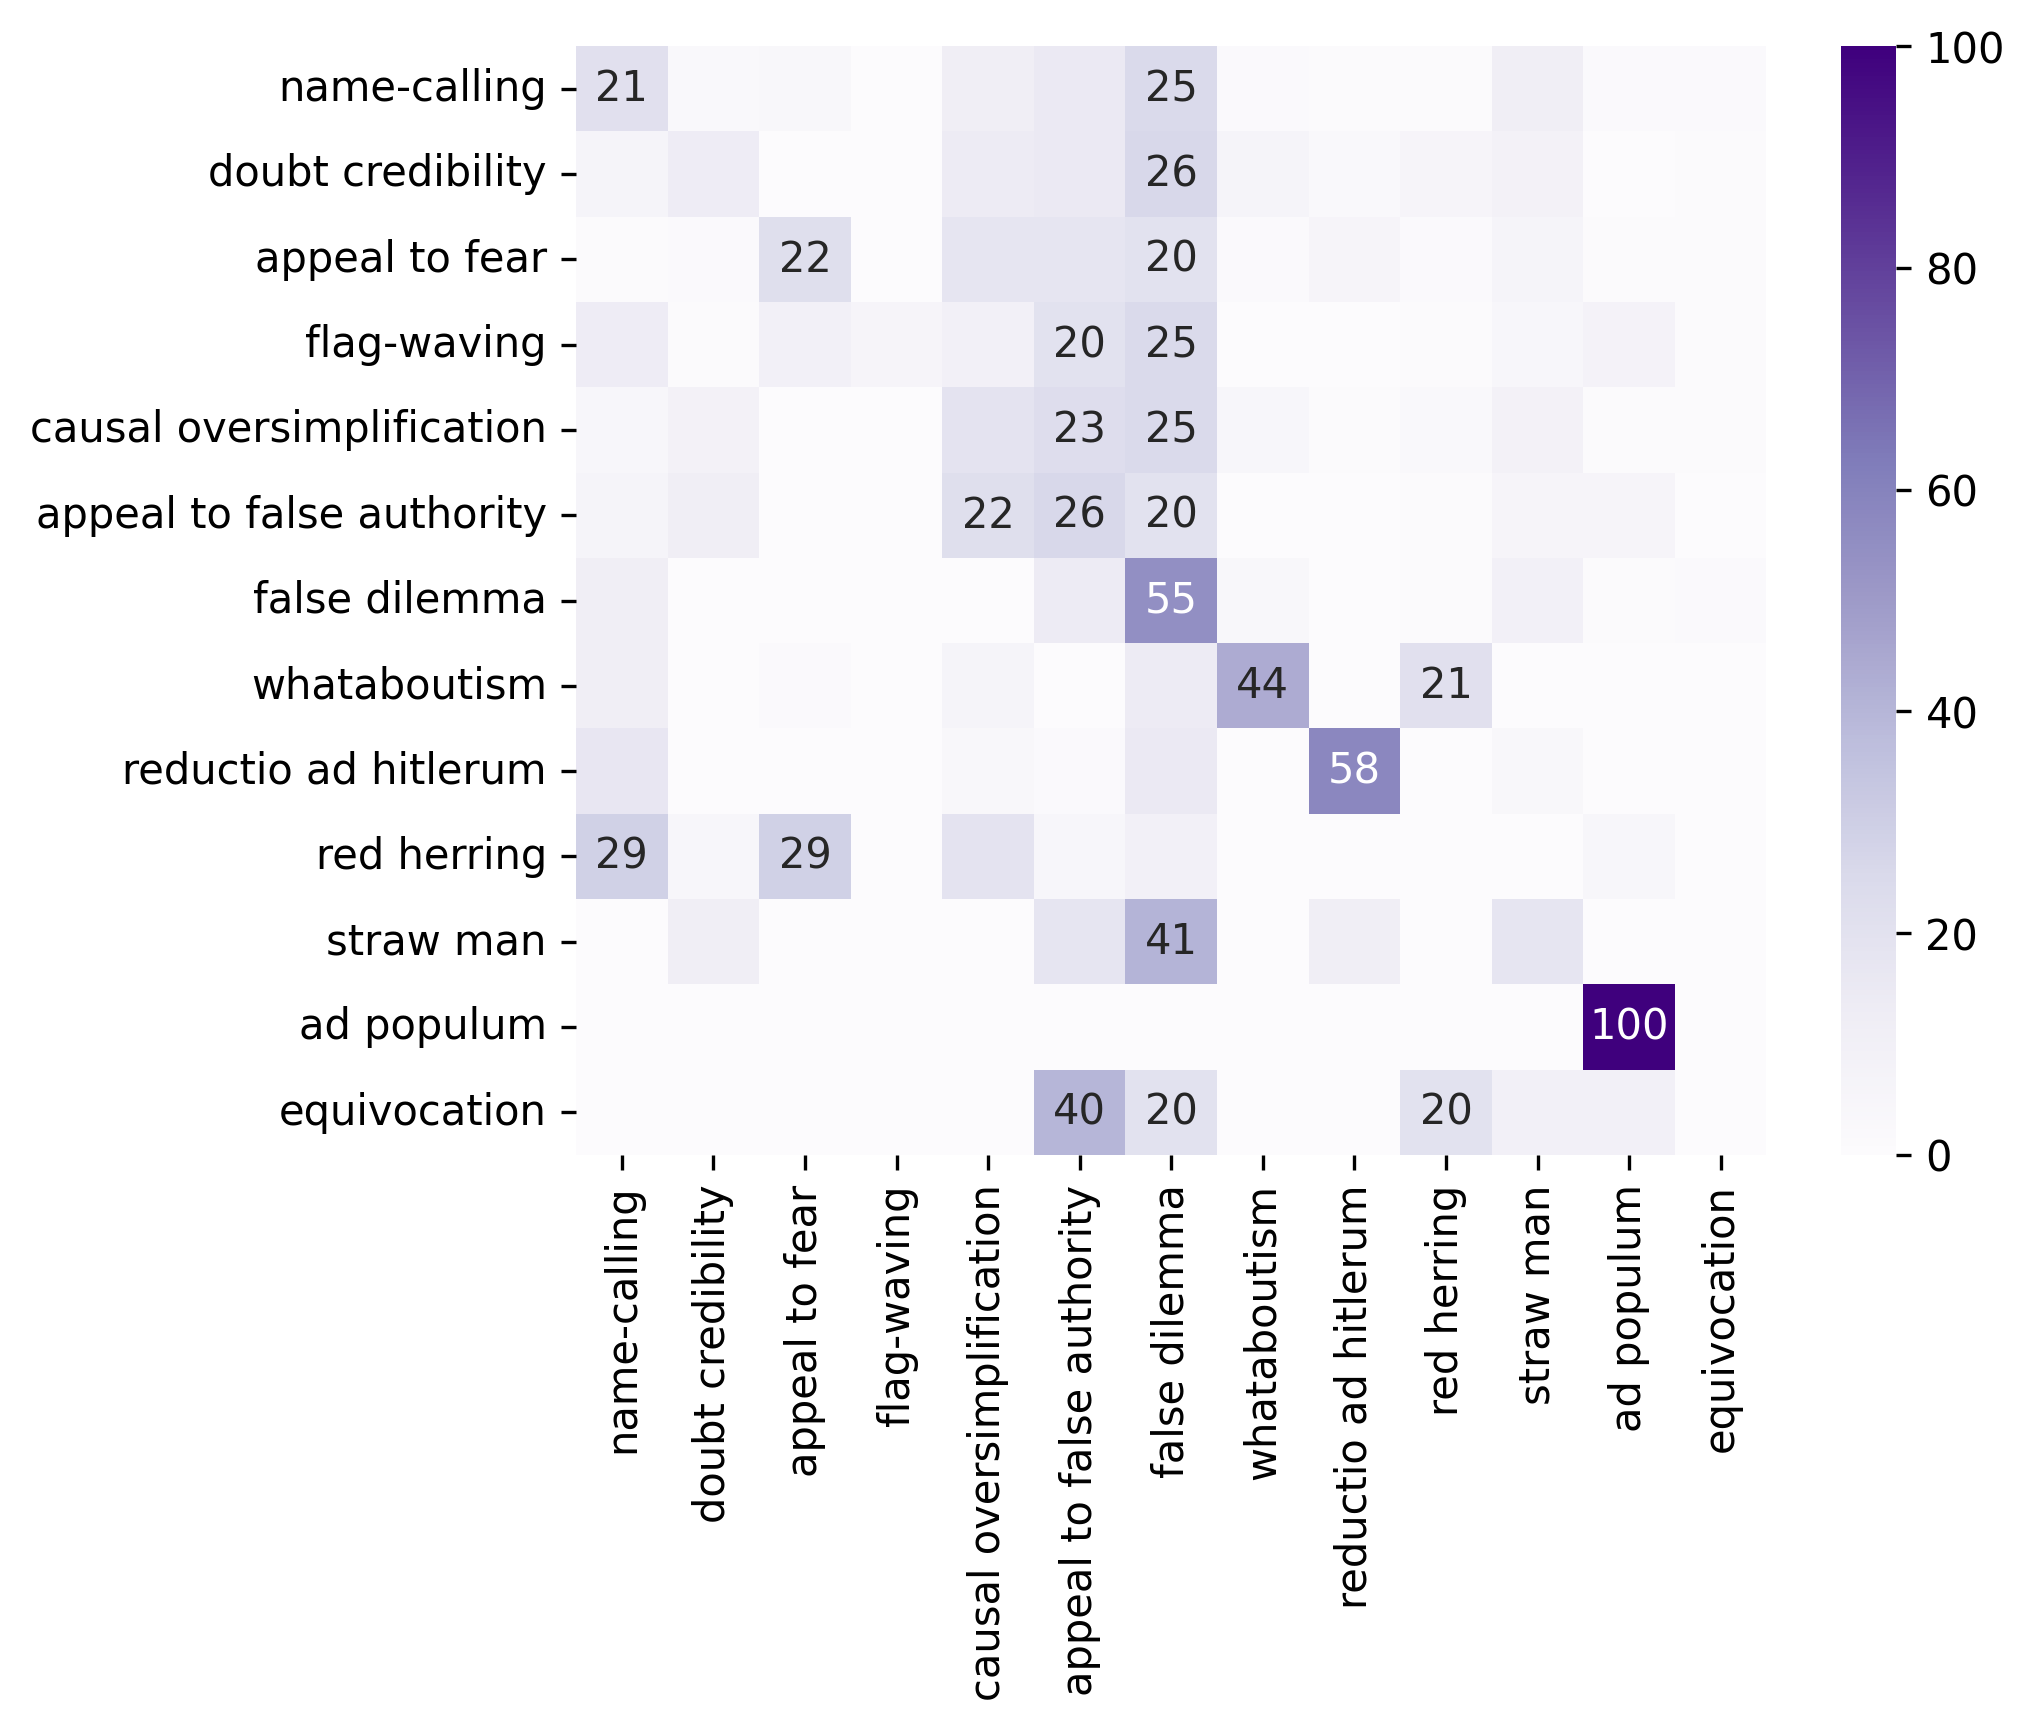

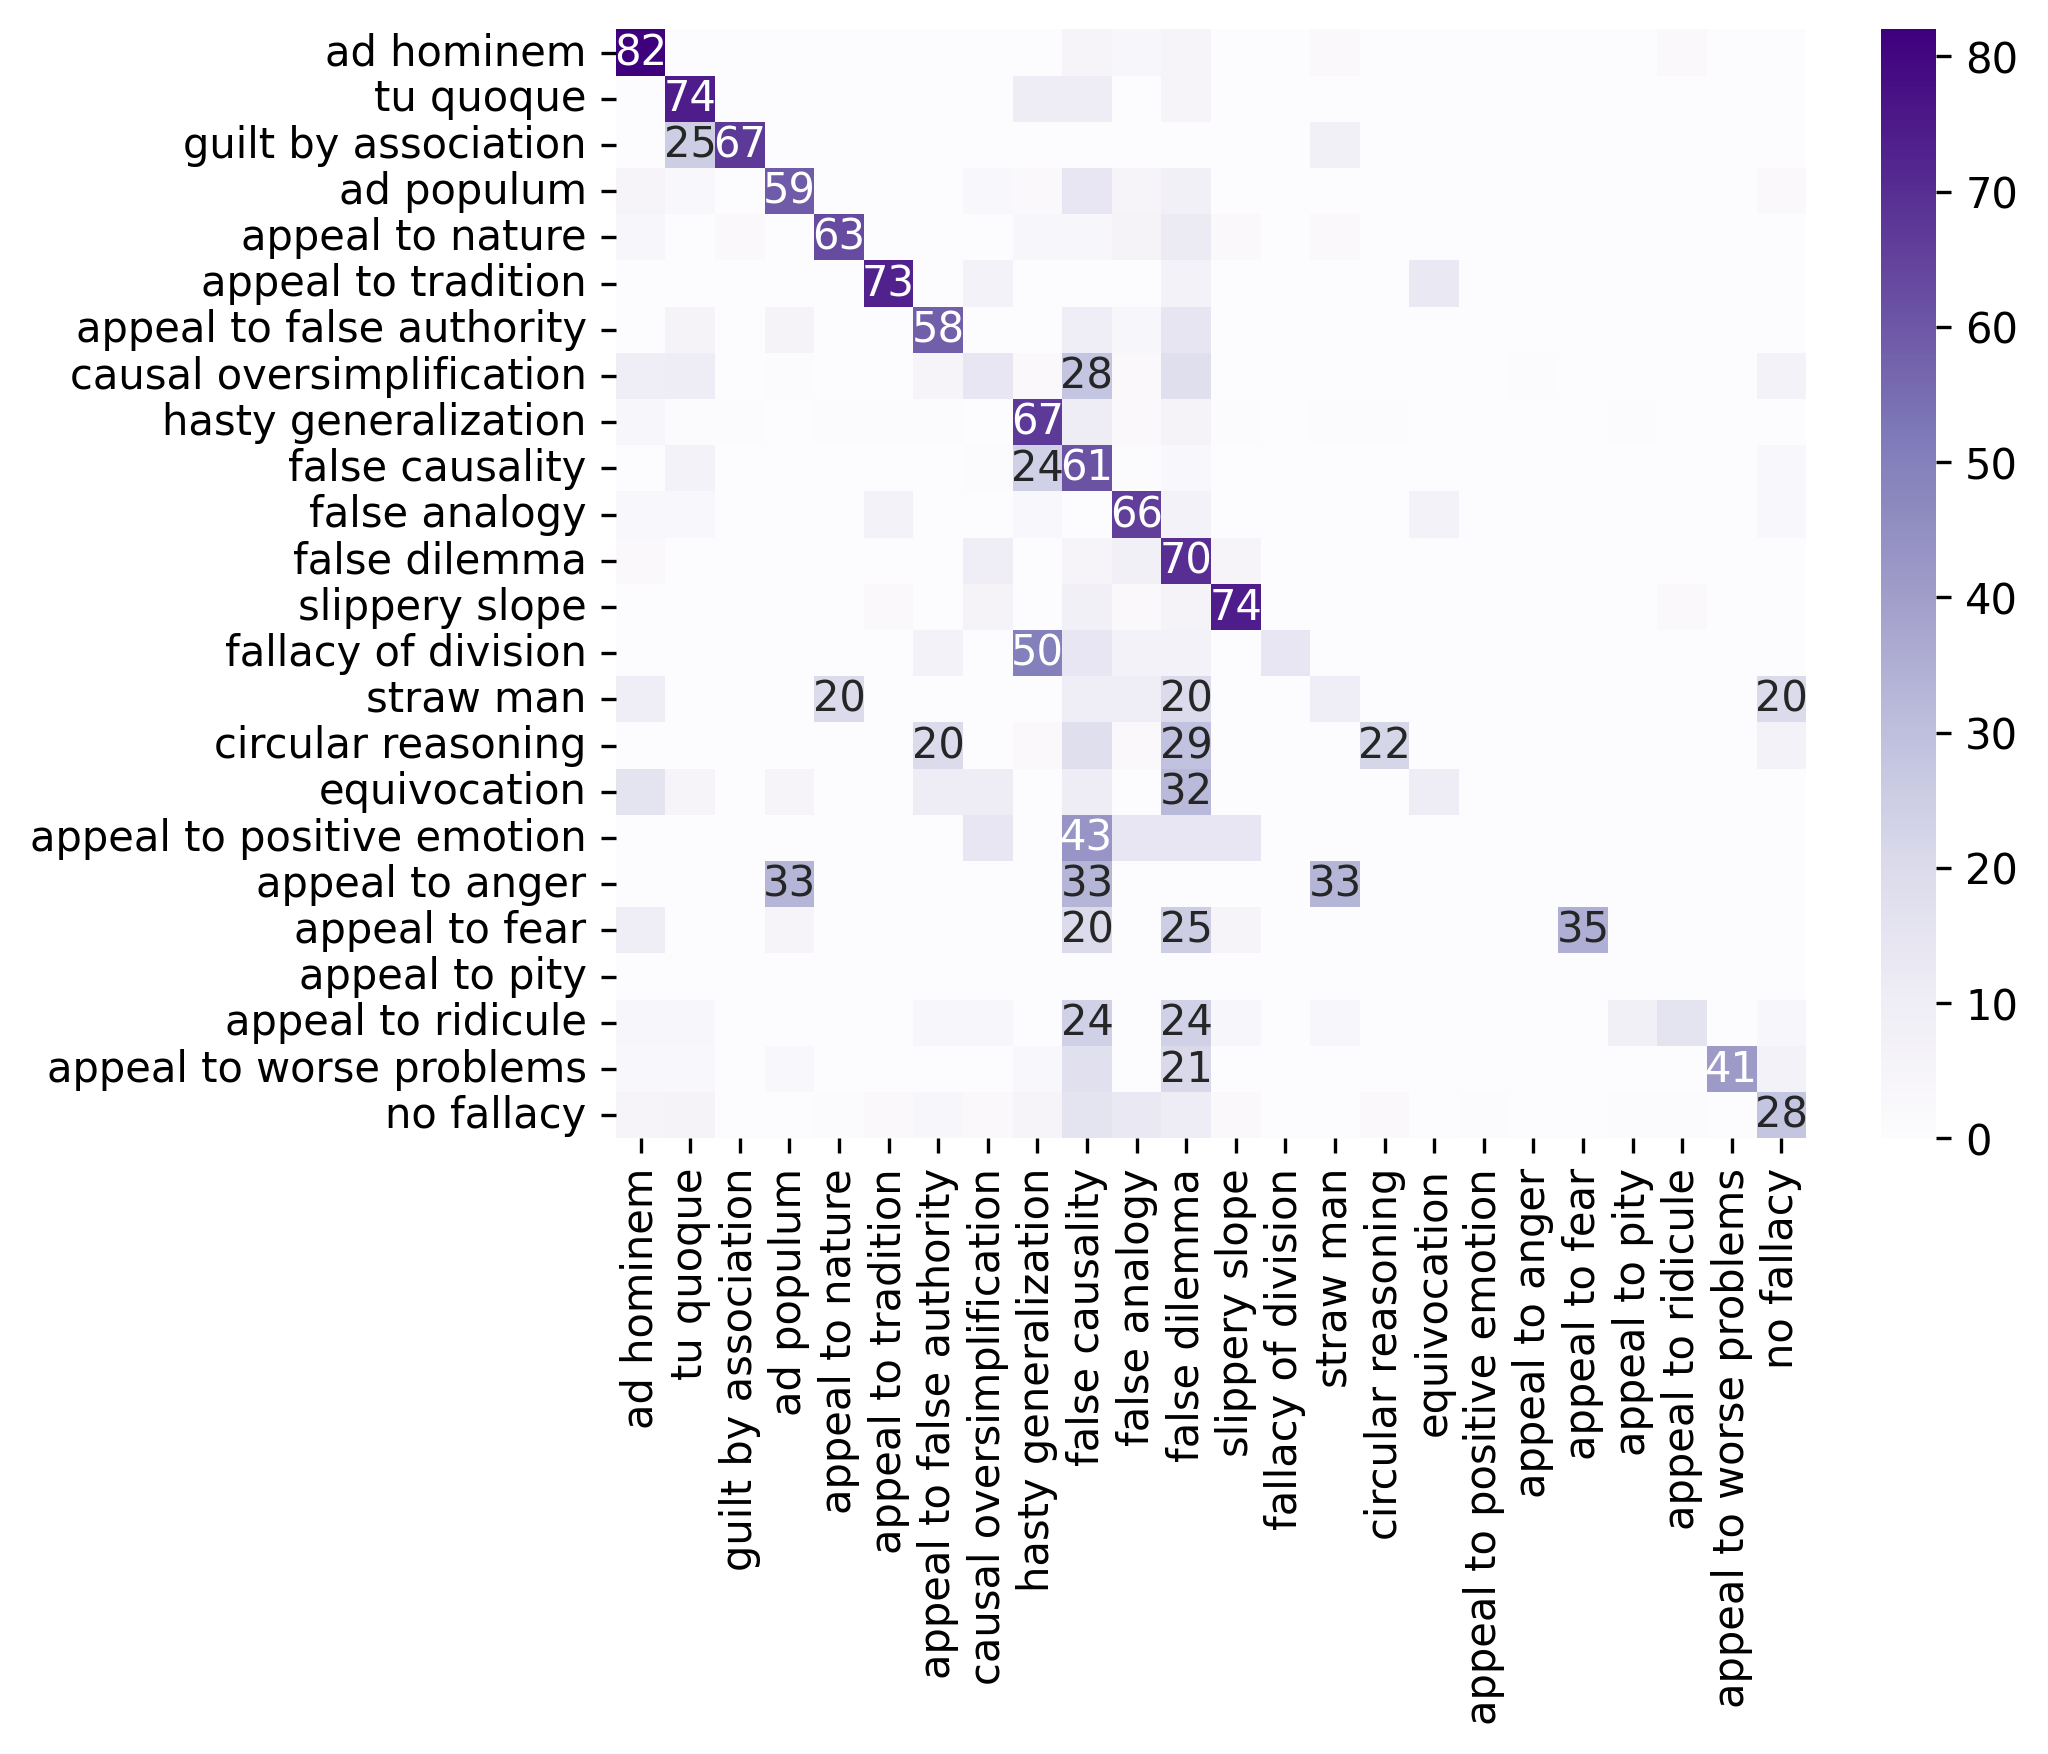

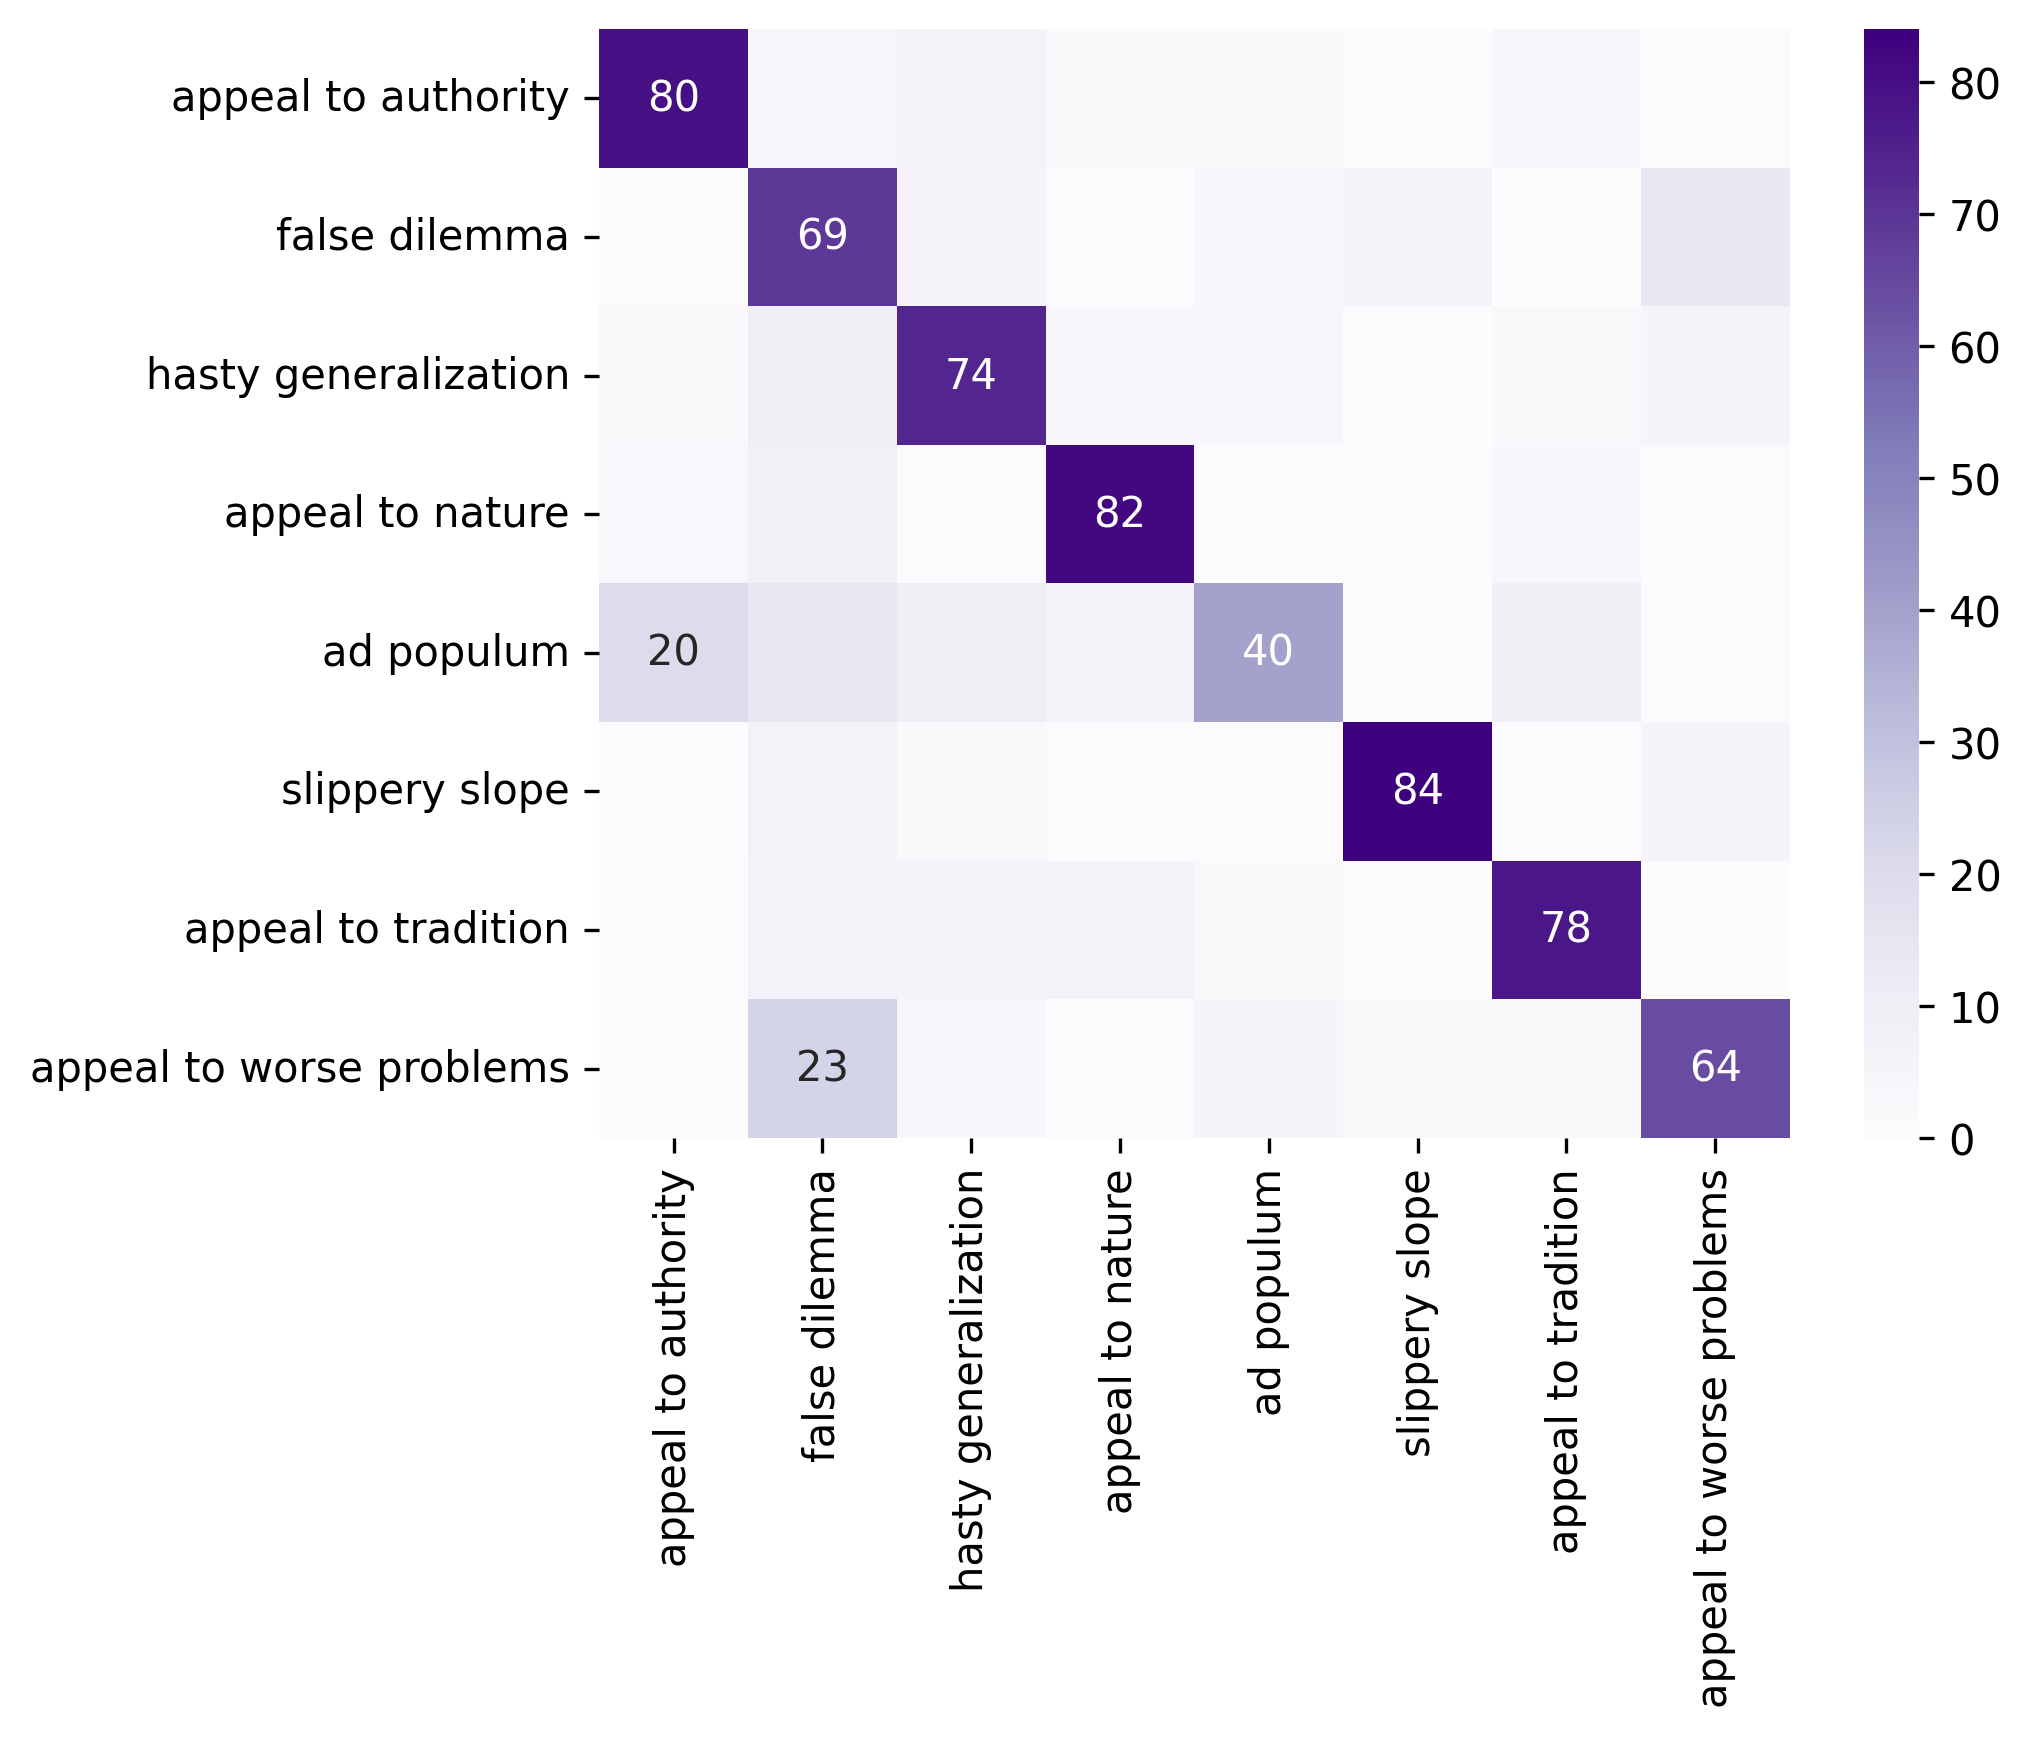

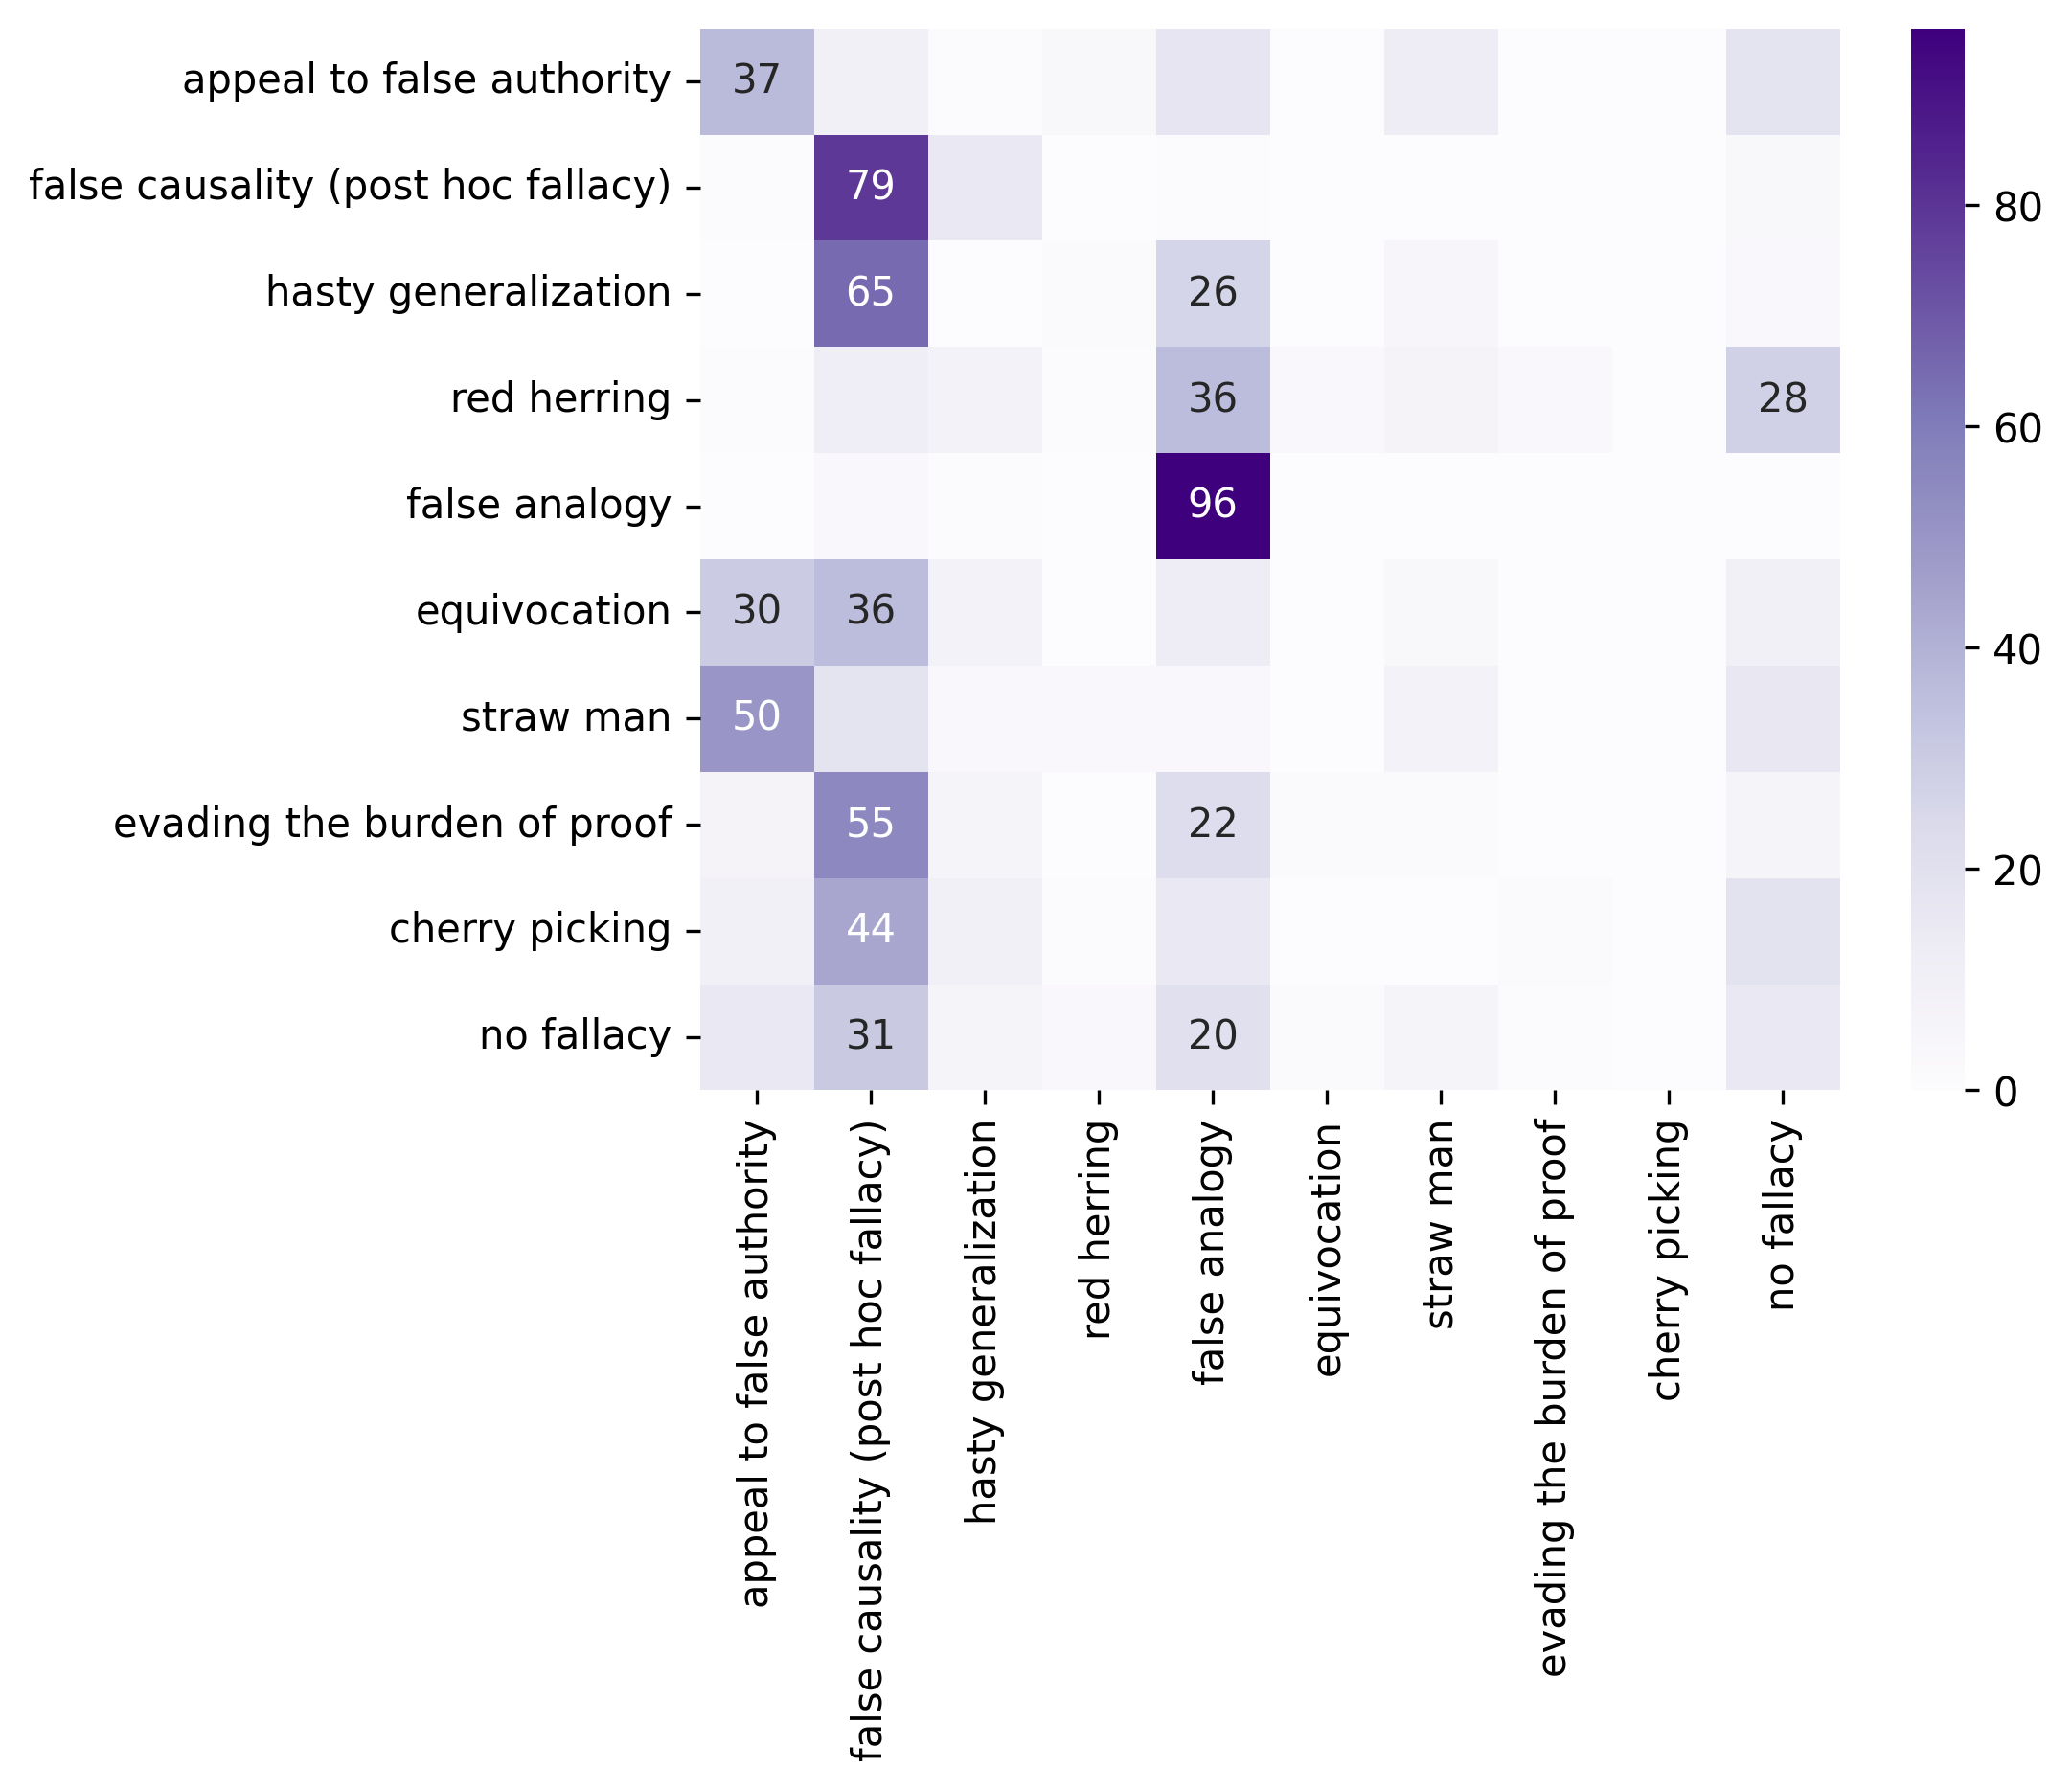

In [42]:
llm_map = {
    'gpt-4-turbo':'GPT-4',
    'gpt-3.5-turbo': 'GPT-3.5',
    'qwen2.5-7bf': 'Qwen2.5-Instruct 7B',
    #'qwen2.5-14bf': 'Qwen2.5-Instruct 14B',
    'llama3-8bf': 'Llama3-Chat 8B',
    'mistral-7bf': 'Mistral-Instruct 7B',
    'llama2-13bf': 'Llama2-Chat 13B'
}
# scheme_ls = {
#     'v1_wo_def': 2, 
#     'v12_wo_def': 1, 
#     'v13_wo_def': 2, 
#     'v14_wo_def': 2
# }

dataset_ls = ['argotario', 'logic', 'elecdebate', 'propaganda', 'mafalda', 'reddit', 'covid']
root = './results'

# View LLM representatives' performance over common fallacies
LLMs = {'gpt-4-turbo': {
        'n_runs': 3,
        'argotario': ['v2_gen_def','w_def', 'v3_cot_wo_def'], #single 排第二
        'logic': ['v12_wo_def', 'w_def', 'v3_cot_wo_def'],#single 排第二
        'reddit': ['v3_cot_wo_def', 'w_def', 'v2_gen_def'],#single 排第二
        'elecdebate': ['v2_gen_def', 'wo_def','v1_wo_def'],#single 排第二
        'propaganda': ['v3_cot_wo_def','v2_gen_def','wo_def'],
        'mafalda': ['v3_cot_wo_def','wo_def', 'v1_wo_def'],#single 排第二
        'covid': ['v3_cot_wo_def', 'w_def', 'v1_wo_def'],#single 排第二
        }, 
        'llama3-8bf': {
        'n_runs':5,
        'argotario': ['v13_wo_def','v14_wo_def','v12_wo_def'],
        'logic': ['v1_wo_def', 'v12_wo_def','v14_wo_def'],
        'reddit': ['v13_wo_def','v14_wo_def','v3_cot_wo_def'],
        'elecdebate': ['v3_cot_wo_def', 'wo_def', 'v2_gen_def'],
        'propaganda': ['v1_wo_def', 'v12_wo_def','v3_cot_wo_def'],
        'mafalda': ['v14_wo_def','v3_cot_wo_def','v12_wo_def'],
        'covid': ['v3_cot_wo_def','v12_wo_def','v1_wo_def'],
    }
}
save_root= './camera-ready/cm'

# View LLM representatives' performance under PEC schemes
focused_scheme = ['v13_wo_def','v14_wo_def']
gpt4_dict, llama3_dict = {'n_runs': 3}, {'n_runs': 5}
gpt4_dict.update({task : focused_scheme for task in dataset_ls})
llama3_dict.update({task : focused_scheme for task in dataset_ls})
LLMs = {'gpt-4-turbo': gpt4_dict, 'llama3-8bf': llama3_dict}
save_root = './camera-ready/PEC'

# LLMs = {'gpt-4-turbo': gpt4_dict, 
#         'llama3-8bf': {
#         'n_runs':5,
#         'argotario': focused_scheme,
#         'logic': focused_scheme,
#         'reddit': focused_scheme,
#         'elecdebate': focused_scheme,
#         'propaganda': focused_scheme,
#         'mafalda': focused_scheme,
#         'covid': focused_scheme,
#         }
# }

label_font_size = 7
# save_root= './res_analysis/0612/cm'
# save_root = './res_analysis/0612/PEC'

do_confusion_matrix = True
do_error_analysis = False
do_context_len = False

llm_fallacy = {}
llm_dataset_fallacy = {}
if do_confusion_matrix:
    scheme_ls = {
    'w_def': 0,
    'wo_def': 0,    
    'v1_wo_def': 2,
    'v12_wo_def': 1,
    'v13_wo_def': 2,
    'v14_wo_def': 2,
    'v2_gen_def': 1,
    'v3_cot_wo_def': 1
    }
    llm_ls = LLMs
    for llm in LLMs:
        llm_fallacy[llm] = {'pred': [], 'gold': [], 'ood_pred':[], 'ood_gold':[]}
    for llm in LLMs:
        llm_dataset_fallacy[llm] = {}
        for task in dataset_ls:
            llm_dataset_fallacy[llm][task] = {'pred': [], 'gold': []}
# if do_context_len:
#     def get_chat_context_length(js):
#         l_count = 0
#         for msg in js['chat_history']:
#             l_count += len(msg['content'].split())
#         return l_count
#     llm_length_acc= {}
#     llm_ls = list(llm_map.keys())
#     for dataset in dataset_ls:
#         llm_length_acc[dataset] = {}
#     for llm in llm_map:
#         llm_length_acc[dataset][llm] = {}
#         for sch in scheme_ls:
#             llm_length_acc[dataset][llm][sch] = {0: [], 1:[]}
# if do_error_analysis:
#     LLMs = {'gpt-4-turbo': {
#         'n_runs': 3,
#         'argotario': focused_scheme, #single 排第二
#         'logic': focused_scheme,#single 排第二
#         'reddit': focused_scheme,#single 排第二
#         'elecdebate': focused_scheme,#single 排第二
#         'propaganda': focused_scheme,
#         'mafalda': focused_scheme,#single 排第二
#         'covid': focused_scheme,#single 排第二
#         }
#     }


    

for mfolder in os.listdir(root):
    mf = os.path.join(root, mfolder)
    if os.path.isdir(mf) and (mfolder in llm_ls):
        for tfolder in os.listdir(mf):
            df = os.path.join(mf, tfolder)
            if os.path.isdir(df) and (tfolder in dataset_ls):
                run_count = {}
                for sch in scheme_ls:
                    run_count[sch] = 0
                for rfolder in os.listdir(df):
                    rf = os.path.join(df, rfolder)
                    if os.path.isdir(rf):
                        if do_error_analysis:
                            pass
        
                        if do_confusion_matrix:
                            setting = rfolder.split("_")[0]
                            if setting != 'fewshot':
                                scheme = "_".join(rfolder.split('_GPU-')[0].split('_')[1:]).rstrip('_012')
                                if scheme in LLMs[mfolder][tfolder]:#scheme_ls
                                    run_count[scheme] += 1
                                    if run_count[scheme] <= LLMs[mfolder]['n_runs']:
                                        if scheme not in ['w_def', 'wo_def']:
                                            pred_file = os.path.join(rf, 'round_'+f"{scheme_ls[scheme]}", 'predictions.json')
                                            assert os.path.exists(pred_file)
                                        else:
                                            pred_file = os.path.join(rf, 'predictions.json')
                                        # 每个数据集整体分类(正确+错误)的confusion matrix
                                        for js in json.load(open(pred_file)):     
                                            pred_ls, gold_ls = per_dataset_get_pred_gold_fallacy(js, tfolder)
                                            for p,g in zip(pred_ls, gold_ls):
                                                llm_dataset_fallacy[mfolder][tfolder]['pred'].append(per_dataset_fallacy_id_map[tfolder][p])
                                                llm_dataset_fallacy[mfolder][tfolder]['gold'].append(per_dataset_fallacy_id_map[tfolder][g])

                                        # 圈定的fallacy types里，错误分类的confusion matrix
                                        if os.path.exists(os.path.join(rf, 'incorrect_updated.json')):
                                            incorrect_file = os.path.join(rf, 'incorrect_updated.json')
                                        else:
                                            incorrect_file = os.path.join(rf, 'incorrect.json')
                                        for js in json.load(open(incorrect_file)):
                                            if len(js['label']) == 1:
                                                do_check = True if confusion_convert_to_name(js['label'][0].lower()) in fallacy_types else False
                                            else:
                                                do_check = False
                                                for a_label in js['label']:
                                                    if confusion_convert_to_name(a_label.lower()) in fallacy_types:
                                                        do_check = True
                                                        break
                                            if do_check:
                                                pred_ls, gold_ls, ood_pred_ls, ood_gold_ls = get_pred_gold_fallacy(js, tfolder)
                                                # if not ((gold_label == 'appeal to emotion') and \
                                                #     ('false causality (post hoc fallacy)' in pred_ls) and \
                                                #     (tfolder =='elecdebate')):
                                                for p, g, in zip(pred_ls, gold_ls):
                                                    llm_fallacy[mfolder]['pred'].append(fallacy_id_map[p])
                                                    llm_fallacy[mfolder]['gold'].append(fallacy_id_map[g])
                                                for op, og in zip(ood_pred_ls, ood_gold_ls):
                                                    llm_fallacy[mfolder]['ood_pred'].append(op)
                                                    llm_fallacy[mfolder]['ood_gold'].append(og)
                                                    # llm_dataset_fallacy[mfolder][tfolder]['pred'].append([fallacy_id_map[p] for p in pred_ls])
                                                    # llm_dataset_fallacy[mfolder][tfolder]['gold'].append(fallacy_id_map[gold_label])
                                              
                                        
                        # else:
                        #     # if scheme not in ['w_def', 'wo_def']:
                        #         #     pred_file = os.path.join(rf, 'round_'+f"{scheme_ls[scheme]}", 'predictions.json')
                        #         #     assert os.path.exists(pred_file)
                        #         # else:
                        #         #     pred_file = os.path.join(rf, 'predictions.json')
                        #     #try:
                        #     #print(scheme)
                        #     #assert scheme in scheme_ls
                        #     #print(scheme_ls)
                        #     if scheme in scheme_ls:
                        #         wrong_ids = []
                        #         for js in json.load(open(incorrect_file)):
                        #             llm_length_acc[tfolder][mfolder][scheme][0].append(get_chat_context_length(js))
                        #             wrong_ids.append(js['id'])
                        #         for js in json.load(open(pred_file)):
                        #             if js['id'] not in wrong_ids:
                        #                 llm_length_acc[tfolder][mfolder][scheme][1].append(get_chat_context_length(js))
                        #     # except:
                        #     #     print(f"Failed to collect results from {rf}.")

############## To view each LLM
llm_fallacy_results = {}
for model, records in llm_fallacy.items():
    y_true = records['gold']
    y_pred = records['pred']
    ood_y_true = records['ood_gold']
    ood_y_pred = records['ood_pred']

    # y_true, y_pred = [], []
    # ood_y_true, ood_y_pred = [], []
    # for pred_ls, gold_ls in zip(records['pred'], records['gold']):

    # for pred_ls, ood_ls, gold, ood_gold in zip(records['pred'], records['ood_pred'], records['gold'], records['ood_gold']):
    #     for p in pred_ls:
    #         y_pred.append(p)
    #         y_true.append(gold)
    #     for op in ood_ls:
    #         y_pred_ood.append(op)
    #         y_true_ood.append(ood_gold)
    print(set(y_true))
    
    cmatrix = {}
    for fal_name, fid in fallacy_id_map.items():
        cmatrix[fid] = {v: 0 for k, v in fallacy_id_map.items()}
        # gold是它， pred是其他    
    for one_pred, one_gold in zip(y_pred, y_true):
        cmatrix[one_gold][one_pred] += 1
    cm_percent = []
    for _, fid in fallacy_id_map.items():
        f_count = sum(list(cmatrix[fid].values())) #行求和为该类的数量
        for id, count in cmatrix[fid].items():
            cmatrix[fid][id] = round(count * 100 / f_count, 0)
        cm_percent.append(list(cmatrix[fid].values()))
    
    llm_fallacy_results[model] = {'focal': confusion_matrix(y_true=y_true, y_pred=y_pred),
                                  'percent': np.array(cm_percent),
                                  'ood': {'pred': ood_y_pred, 'gold': ood_y_true}}
    df_cm = pd.DataFrame(np.array(cm_percent), index = list(fallacy_id_map.keys()),
                  columns = list(fallacy_id_map.keys()))
    fig = plt.figure(dpi=300)
    annotations = np.array(cm_percent).astype('int').astype('str')
    annotations[np.array(cm_percent) < 20] = ""
    sn.heatmap(df_cm, annot=annotations, fmt='',annot_kws={'fontsize':7}, cmap='Blues' if model.startswith('gpt') else 'Purples')
    plt.xticks(fontsize=label_font_size)
    plt.yticks(fontsize=label_font_size)
    os.makedirs(save_root, exist_ok=True)
    plt.savefig(f'{save_root}/{model}_cm.png', dpi=fig.dpi, bbox_inches="tight")

                                  
############## To view each dataset
llm_fallacy_dataset_results = {}
for model, mrecords in llm_dataset_fallacy.items():
    for task, records in mrecords.items():
        y_true, y_pred = records['gold'], records['pred']
        # y_true, y_pred = [], []
        # for pred_ls, gold in zip(records['pred'], records['gold']):
        #     for p in pred_ls:
        #         y_pred.append(p)
        #         y_true.append(gold)
        print(set(y_true))
        # id_fallacy_map = {v: k for k, v in fallacy_id_map.items()}
        # task_fallacy_id_map = {id_fallacy_map[fid]: fid for fid in y_true}
        # print(task_fallacy_id_map)
        task_fallacy_id_map = per_dataset_fallacy_id_map[task]
        cmatrix = {}
        for fal_name, fid in task_fallacy_id_map.items():
            cmatrix[fid] = {v: 0 for k, v in task_fallacy_id_map.items()}   
        for one_pred, one_gold in zip(y_pred, y_true):
            #try:
            cmatrix[one_gold][one_pred] += 1
            # except:
            #     continue
        cm_percent = []
        for _, fid in task_fallacy_id_map.items():
            f_count = sum(list(cmatrix[fid].values())) #行求和为该类的数量
            #print(cmatrix[fid])
            for id, count in cmatrix[fid].items():
                try:
                    cmatrix[fid][id] = round(count * 100 / f_count, 0)
                except:
                    cmatrix[fid][id] = 0.
            cm_percent.append(list(cmatrix[fid].values()))
        
        df_cm_task = pd.DataFrame(np.array(cm_percent), index = list(task_fallacy_id_map.keys()),columns = list(task_fallacy_id_map.keys()))
        fig = plt.figure(dpi=300)
        # plt.figure(figsize=(10,10), dpi=fig.dpi)#figsize = (10,7)
        annotations = np.array(cm_percent).astype('int').astype('str')
        annotations[np.array(cm_percent) < 20] = ""
        sn.heatmap(df_cm_task, annot=annotations, fmt='', cmap='Blues' if model.startswith('gpt') else 'Purples') #annot_kws={'fontsize':7}
        #plt.xticks(fontsize=label_font_size)
        #plt.yticks(fontsize=label_font_size)
        #plt.xticks(rotation=60)
        #g.set_xticklabels(rotation=70)
        os.makedirs(save_root, exist_ok=True)
        plt.savefig(f'{save_root}/{model}_{task}_cm.png', dpi=fig.dpi, bbox_inches="tight")

        llm_fallacy_dataset_results[model] = {'focal': confusion_matrix(y_true=y_true, y_pred=y_pred),
                                            'percent': np.array(cm_percent)}


<Axes: >

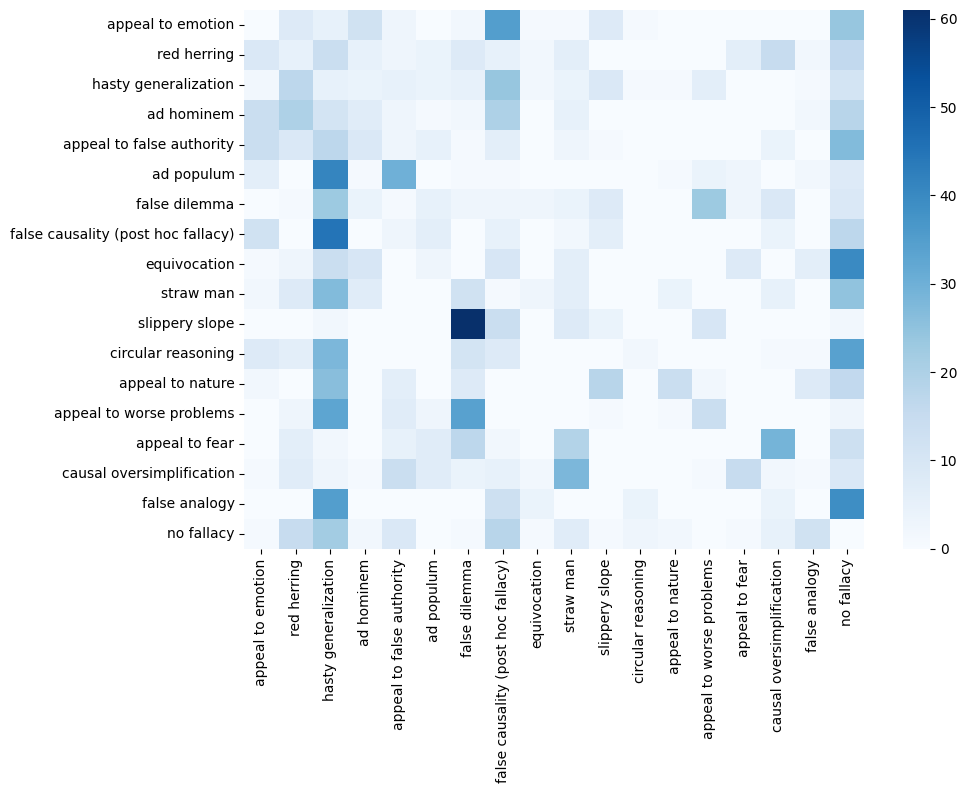

In [82]:
df_cm = pd.DataFrame(llm_fallacy_results['gpt-4-turbo']['percent'], index = list(fallacy_id_map.keys()),
                  columns = list(fallacy_id_map.keys()))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=False, cmap='Blues')

<Axes: >

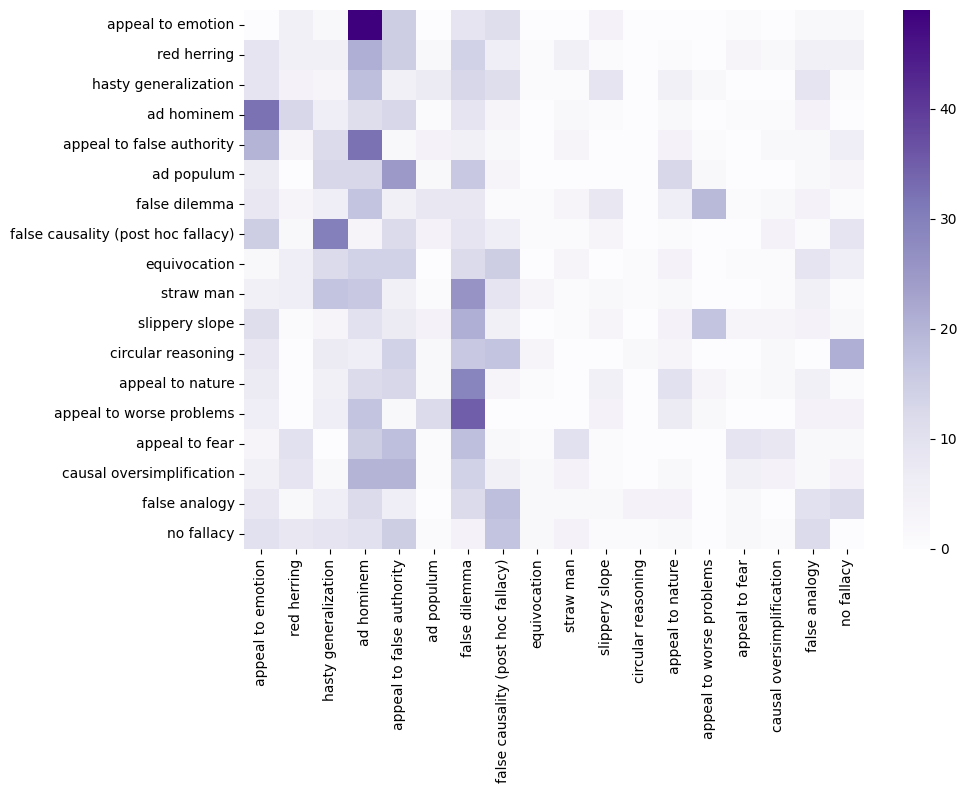

In [83]:
df_cm = pd.DataFrame(llm_fallacy_results['llama3-8bf']['percent'], index = list(fallacy_id_map.keys()),
                  columns = list(fallacy_id_map.keys()))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=False, cmap='Purples')

In [23]:
llm_map = {
    'gpt-4-turbo':'GPT-4',
    'gpt-3.5-turbo': 'GPT-3.5',
    'llama3-8bf': 'Llama3-Chat 8B',
    'mistral-7bf': 'Mistral-Instruct 7B',
    'llama2-13bf': 'Llama2-Chat 13B',
    'llama2-7bf': 'Llama2-Chat 7B', 
}
llm_length_acc.keys()
fig = plt.figure(figsize =(10, 7))
# Creating plot
data = [llm_length_acc['propaganda']['llama3-8bf']['v14_wo_def'][0] + llm_length_acc['propaganda']['llama3-8bf']['v13_wo_def'][0], 
        llm_length_acc['propaganda']['llama3-8bf']['v14_wo_def'][1] + llm_length_acc['propaganda']['llama3-8bf']['v13_wo_def'][1],
        llm_length_acc['propaganda']['llama3-8bf']['v1_wo_def'][0],
        llm_length_acc['propaganda']['llama3-8bf']['v1_wo_def'][1]
        ]
# data = [llm_length_acc['elecdebate']['llama3-8bf']['v14_wo_def'][0] + llm_length_acc['elecdebate']['llama3-8bf']['v13_wo_def'][0], 
#         llm_length_acc['elecdebate']['llama3-8bf']['v14_wo_def'][1] + llm_length_acc['elecdebate']['llama3-8bf']['v13_wo_def'][1],
#         llm_length_acc['elecdebate']['llama3-8bf']['v1_wo_def'][0],
#         llm_length_acc['elecdebate']['llama3-8bf']['v1_wo_def'][1]
#         ]

# data = [llm_length_acc['elecdebate']['gpt-4-turbo']['v14_wo_def'][0] + llm_length_acc['elecdebate']['gpt-4-turbo']['v13_wo_def'][0], 
#         llm_length_acc['elecdebate']['gpt-4-turbo']['v14_wo_def'][1] + llm_length_acc['elecdebate']['gpt-4-turbo']['v13_wo_def'][1],
#         llm_length_acc['elecdebate']['gpt-4-turbo']['v1_wo_def'][0],
#         llm_length_acc['elecdebate']['gpt-4-turbo']['v1_wo_def'][1]
#         ]
#def view_boxplot(record, dataset, model, scheme):
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = ax.boxplot(data)

# plt.boxplot(llm_length_acc['elecdebate']['v1_wo_def'][1])
#plt.boxplot(llm_length_acc['propaganda']['v13_wo_def'][0])
#plt.boxplot(llm_length_acc['propaganda']['v13_wo_def'][1])
# show plot
plt.show()


KeyError: 'propaganda'

<Figure size 1000x700 with 0 Axes>